In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import galpak
#from galpak import DefaultModel, ModelSersic
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import random

import os
import scipy as sc
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates import Angle, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import make_axes_locatable



import mpdaf
from mpdaf.obj import Cube
from mpdaf.drs import PixTable
#from galpak import MoffatPointSpreadFunction, GaussianLineSpreadFunction
from mpdaf.sdetect import Source

from astropy.io import fits 

import pymultinest

# the home made tool package:
import galpak_tools as gt

#import logistic
#import run_covering_2

%load_ext autoreload
%autoreload 2

INFO:GalPaK: PSF:Found package Maoppy version 1.5.0
INFO:GalPaK:Found MPDAF version 3.5
INFO:GalPaK:Found EMCEE version 3.1.1
INFO:GalPaK:Found PyMultinest version 2.11
INFO:GalPaK: Running galpak 2.1.7.dev102+g1c277939.d20230310


In [3]:
bbreak_04 = np.array([5200, 5500])
bbreak_rest = np.round(bbreak_04/(1+0.4))
bbreak_075 = bbreak_rest*(1+0.75)
bbreak_1 = bbreak_rest*(1+1)
bbreak_13 = bbreak_rest*(1+1.3)
bbreak_15 = bbreak_rest*(1+1.5)

print("Balmer break at rest = ", bbreak_rest)
print("Balmer break at z = 0.4 = ", bbreak_04)
print("Balmer break at z = 0.75 = ", bbreak_075)
print("Balmer break at z = 1.0 = ", bbreak_1)
print("Balmer break at z = 1.3 = ", bbreak_13)
print("Balmer break at z = 1.5 = ", bbreak_15)

Balmer break at rest =  [3714. 3929.]
Balmer break at z = 0.4 =  [5200 5500]
Balmer break at z = 0.75 =  [6499.5  6875.75]
Balmer break at z = 1.0 =  [7428. 7858.]
Balmer break at z = 1.3 =  [8542.2 9036.7]
Balmer break at z = 1.5 =  [9285.  9822.5]


In [4]:
r_filt = np.array([5600, 6800])
i_filt = np.array([7100, 8100])
f775 = np.array([7000, 8600])


Li_rest = i_filt/(1+1.5)
Li_rest

array([2840., 3240.])

In [5]:
R = pd.read_csv("results_6_conservative.csv")

With visual inspections of the runs & catalogs we identified several bad runs that should not be taken into account:

In [6]:
bad_runs_ids = [11083, 12121, 23086, 23120, 26056, 26092, 29002, 29084, 28102, 30070, 30093, 31005]

- 11083: no OII, and in consequence no run.
- 12121: no OII
- 23086: no OII
- 23120: src nearby, rerun with src mask.
- 26056: extended source (merger?), [OII] emission do not match other line position... (clump)
- 26092: no OII
- 29002: source merged with QSO (continuum and OII.), Can be tried with OIII or Hbeta
- 29084: faint OII. bad run because QSO nearby...
- 28102: no OII.
- 30070: OII very faint.
- 30093: no OII
- 31005: OII with strange shape. Run is not very good.


- 17068 is suspect...
- 17078 must be rerun
- 20073 is quite bad even if snreff above 3
- 20074 is quite bad even if snreff above 3
- 20077 is quite bad even if snreff above 3
- 21107 no multinest? Rerun..
- 26092 no OII, no run
- 28102 no OII, no run
- 29002 mixed with QSO (bad cont or psf sub)
- 29084 other src nearby
- 30070 no OII (but snr = 10!)

In [7]:
R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/R["sed_logMass"])
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-5)

To obtain the absolute magnitude in the R band in rest-frame, we must apply a K-correction. In the general case for two different filters Q and R:
$M_Q^{rest} = m_R^{obs} - DM(z) - K_{QR}(z)$  
But here Q = R. The $K_{RR}$ is given by:  
$K_{RR} = +(1+\beta).2.5\log(1+z)$  

Pb: what is the value for $\beta$ ??

Above the Balmer break (around 4000 A) we can take $\beta$ ~ -1. Below we can take 0.
But this is in rest-frame spectra. 
So this Balmer break happen around 4000(1+z) ~ 5600 - 9600  
The SDSS r band span from

In [8]:
def Krr(beta, z):
    return (1+beta)*2.5*np.log(1+z)

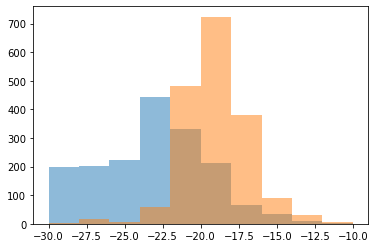

In [9]:
d10 = 10*u.pc
d10 = d10.to(u.m)
R["m_abs_r"] = R["SDSS_r"] - 2.5*np.log10((R["dist_lum"]/d10.value)**2) 
R["m_abs_r_correct"] = R["SDSS_r"] - 2.5*np.log10((R["dist_lum"]/d10.value)**2) - Krr(1, R["Z"]) 

plt.hist(R["m_abs_r_correct"], range = (-30,-10), alpha = 0.5);
plt.hist(R["m_abs_r"], range = (-30,-10), alpha = 0.5);

In [10]:
fzlow_04 = R["Z"] > 0.4
fzlow_05 = R["Z"] > 0.5
fzhigh_15 = R["Z"] < 1.5
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fnoQSO = R["is_QSO"] == 0
fnostar = R["is_star"] == 0

In [11]:
R_lowz = R[fzhigh_15 & fzconf_0 & fnoQSO & fnostar]
R_goodz_goodconf = R[fzlow_04 & fzhigh_15 & fzconf_1 & fnoQSO & fnostar]

print("Number of galaxies at z below 1.5 = ", len(R_lowz))
print("Number of galaxies at z below 1.5  and zconf= 2 or more = ", len(R_goodz_goodconf))

Number of galaxies at z below 1.5 =  1262
Number of galaxies at z below 1.5  and zconf= 2 or more =  960


# Size of the Fov vs size of DM halos

In [12]:
zz = np.linspace(0.4, 1.5, 20)
m11 = 10**(11)
m115 = 10**(11.5)
m12 = 10**(12)
m125 = 10**(12.5)
m13 = 10**(13)
r11 = gt.get_Rvir(m11, zz)
r115 = gt.get_Rvir(m115, zz)
r12 = gt.get_Rvir(m12, zz)
r125 = gt.get_Rvir(m125, zz)
r13 = gt.get_Rvir(m13, zz)

rr_fov = cosmo.kpc_proper_per_arcmin(zz)/2

Text(0, 0.5, 'kpc')

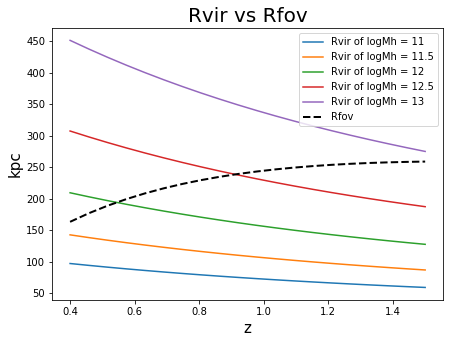

In [13]:
plt.figure(figsize = (7,5))
plt.title("Rvir vs Rfov", size = 20)
plt.plot(zz, r11, label = "Rvir of logMh = 11")
plt.plot(zz, r115, label = "Rvir of logMh = 11.5")
plt.plot(zz, r12, label = "Rvir of logMh = 12")
plt.plot(zz, r125, label = "Rvir of logMh = 12.5")
plt.plot(zz, r13, label = "Rvir of logMh = 13")

plt.plot(zz, rr_fov, label = "Rfov", c = "black", linewidth = 2, linestyle = "--")
plt.legend()
plt.xlabel("z", size = 15)
plt.ylabel("kpc", size = 15)

**So the size of the FOV is larger than Rvir of halos of logM < 12 down to low z of 0.5**

The conlusion of what we studied above is, first, that we can study galaxies of logM > 9 because we are complete until this mass. Second that we can look at isolated galaxies relatively to halo of size below logMh = 1e12 which is large enough. For more massive halos for inst 1e13 Msun, we would expect groups of galaxies, so galaxies would not be isolated anyway.

# Isolated galaxies

We Study galaxies with logM above 1e9 Msun. We define isolated galaxies as galaxies alone within an impact parameter corresponding to a given Rvir of a fixed halo mass of 1e12 (so it varies with z).

In [14]:
def isolated_auto_modif3(df, Mh = 1e12, b_sep = 30, dv = 1e6, group_threshold = 4, logm_sat = 9):
    R = df.copy()
    isol = []
    isol_dist = []
    Rfov = []
    
    for i, r in R.iterrows():
        p = 0
        b_max = gt.get_Rvir(Mh, r["Z"]).value
        
        # a galaxy can be primary only if within 100kpc
        if (r["sed_logMass"] > logm_sat) and (r["B_KPC"] < b_max) and (r["is_QSO"] == 0) and \
        (r["is_star"] == 0) and (r["Z"]< 1.5):
            # we then compute the number of neighbours within B + b_sep kpc:
            f1 = np.abs(R["Z"] - r["Z"])*const.c.value/(1+r["Z"])<dv
            f2 = R["field_id"] == r["field_id"]
            f3 = R["B_KPC"] <= r["B_KPC"] + b_sep
            f4 = R["B_KPC"] <= b_max
            f5 = R["sed_logMass"] > logm_sat
            Fbmax = R[f1 & f2 & f4 & f5]
            Fbsep = R[f1 & f2 & f3 & f5]
            
            # We don't consider galaxies in groups as primary:
            if r["N2000_LOS"] <= group_threshold:
                # to be primary, the galaxy must alone.. 
                if (len(Fbmax) == 1) & (len(Fbsep)==1):
                    p = 1
                # .. or the closest one (not taking into account satellites)
                else:
                    p = 0
        isol.append(p)
        isol_dist.append(b_max)
        Rfov.append((cosmo.kpc_proper_per_arcmin(r["Z"])/2).value)
        
    ISOL = np.array(isol)
    ISOL_DIST = np.array(isol_dist)
    RFOV = np.array(Rfov)

    R["isolated_auto"] = ISOL
    R["isolation_dist"] = ISOL_DIST
    R["Rfov"] = RFOV
    return R

We apply these isolation criteria to R_lowz in order to keep galaxies with ZCONF = 1. Indeed we want to be sure that isolated galaxies don't have potential neighbors (even ZCONF = 1 neighbors). We will select ZCONF > 1 galaxies afterward.

In [15]:
R = isolated_auto_modif3(R, Mh = 10**(11.7), b_sep = 0, dv = 0.5e6, group_threshold = 4, logm_sat = 0)
R = gt.get_closest(R, dv = 0.5e6, group_threshold = 4, logm_sat = 0, ZCONF_lim = 1)

In [16]:
print(len(R))

2020


In [17]:
len(R[R["isolated_auto"] == 1])

261

There is one absorption associated with 2 isolated galaxies (which is problematic!) due to the fact that the Dv used for isolation is equal to the one for abs-gal association (it should be the double to be rigorous but we would then remove too many galaxies). The abs 128 is associated with 2 galaxies, but one is closer in B, in dv and is heavier so we consider that the other one is not associated with the absorption 

In [18]:
R.loc[R["ID"] == 14113, "bool_absorption"] = 0
R.loc[R["ID"] == 14113, "REW_2796"] = 0

In [19]:
f2 = R["N100_neighb"]<= 1
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
f4 = R["REW_2796"]>=0.3
f5 = R["REW_2796"]>=0.01
f6 = R["inclination_convergence"] == 1
f7 = R["pa_convergence"] == 1
f8 = R["snr_eff"]>=3
f9 = R["snr_eff"]>=10
f10 = R["inclination"] >= 30 
f11 = R["inclination"] >= 60
f12 = R["N100_abs"] == 1
f13 = R["N100_abs"] <= 2
f14 = R["bool_absorption"] == 1
f15 = R["N100_neighb"]<= 1
f16 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 3000 #from Zabl 2019
f16b = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 1500 #from Zabl 2019
f17 = R["N50_neighb"]== 0
f18 = R["N50_neighb"]<= 1
f19 = R["alpha"] <= 40
f20 = R["is_QSO"] == 0
f21 = R["N2000_abs"] <= 4
f22 = R["is_closest"] == 1
f23 = R["B_KPC_NEIGHB"] >= 30
f24 = R["Z"] < 2
fzlow = R["Z"] > 0.4
fzlow_08 = R["Z"] > 0.8
fzhigh = R["Z"] < 1.5
fzhigh_1 = R["Z"] < 1
fzhigh_09 = R["Z"] < 0.9
fzhigh_08 = R["Z"] < 0.8
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
f25 = R["N2000_LOS"] <= 4
f26 = R["is_star"] == 0
f27_1 = R["alpha"] <= 33
f27_2 = (R["alpha"] >= 33) & (R["alpha"] <= 66)
f27_3 = R["alpha"] >= 66
f28 = R["inclination"] >= 35
#f29 = R["current"] == 1
f30 = R["isolated_auto"] == 1
f31 = R["primary_auto"] == 1
#f32 = R["galpak_score"] != 0
f33 = R["score_auto"] >= 1
f34 = R["score_auto"] >= 2
f35 = R["score_auto"] >= 3
f36 = R["sed_logMass"] >= 9
f37 = R["run_convergence_global"] >= 0.99
f38 = R["ID"].isin(bad_runs_ids)
f39 = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
f40 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 300
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
fnomass = R["sed_logMass"] == 6

In [20]:
Rforeground = R[fnoQSO & fnostar & fbehind & fzconf_0]
Rforeground_zconf1 = R[fnoQSO & fnostar & fbehind & fzconf_1]
Rforeground_mass = R[fnoQSO & fnostar & fbehind & fzconf_0 & ~fnomass]
Rforeground_zconf1_mass = R[fnoQSO & fnostar & fbehind & fzconf_1 & ~fnomass]
Rforeground_nomass = R[fnoQSO & fnostar & fbehind & fzconf_0 & fnomass]
Rforeground_zconf1_nomass = R[fnoQSO & fnostar & fbehind & fzconf_0 & fnomass]

R_04_15 = R[fzlow & fzhigh & fnoQSO & fnostar & fbehind & fzconf_0 & ~fnomass]
R_04_15_zconf1 = R[fzlow & fzhigh & fnoQSO & fnostar & fbehind & fzconf_1 & ~fnomass]
R_08_15_zconf1 = R[fzlow_08 & fzhigh & fnoQSO & fnostar & fbehind & fzconf_1 & ~fnomass]

R_04_1 = R[fzlow & fzhigh_1 & fnoQSO & fnostar & fbehind & fzconf_0 & ~fnomass]
R_04_1_zconf1 = R[fzlow & fzhigh_1 & fnoQSO & fnostar & fbehind & fzconf_1 & ~fnomass]
R_04_09 = R[fzlow & fzhigh_09 & fnoQSO & fnostar & fbehind & fzconf_0 & ~fnomass]
R_04_09_zconf1 = R[fzlow & fzhigh_09 & fnoQSO & fnostar & fbehind & fzconf_1 & ~fnomass]
R_04_08 = R[fzlow & fzhigh_08 & fnoQSO & fnostar & fbehind & fzconf_0 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fnoQSO & fnostar & fbehind & fzconf_1 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fnoQSO & fnostar & fbehind & fzconf_1 & ~fnomass]

 


prim = R[f20 & f31]
R_9 = R[f20 & f100 & fzlow & fzhigh & fzconf_1 & fbehind & f36]
R100 = R[f20 & fzlow & fzhigh & fbehind & f100] 
R150 = R[f20 & fzlow & fzhigh & fbehind & f150]
R200 = R[f20 & fzlow & fzhigh & fbehind & f200]

isol = R[f20 & f30 & fbehind] #isolated galaxies
isol_abs = R[f20 & f30 & f14 & fbehind]
isol_noabs = R[f20 & f30 & ~f14 & fbehind]
isol_zconf = R[f20 & f30 & fzconf_1 & fbehind]
isol_zconf_abs = R[f20 & f30 & fzconf_1 & f14 & fbehind]
isol_zconf_noabs = R[f20 & f30 & fzconf_1 & ~f14 & fbehind]
isol_zselec = R[f20 &f30 & fzlow & fzhigh & fbehind] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[f20 & f30 & fzconf_1 & fzlow & fzhigh & fbehind & ~f39] 
isol_zselec_nomass = R[f20 & f30 & fzconf_1 & fzlow & fzhigh & fbehind & f39]
isol_zconf_1 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & ~f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f14 & fbehind]
isol_lowM_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & ~f14 & fbehind]
isol_9_convergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & fbehind] # idem with good convergence
isol_9_noconvergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & ~f37 & fbehind] # idem with good convergence
isol_lowM_convergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f37 & fbehind]
isol_snr3 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & fbehind] # idem with good snr
isol_lowM_snr3 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f37 & f8 & fbehind]
isol_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & ~f38 & fbehind] # good runs
isol_notgood_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f38 & fbehind]
isol_snr3_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & fbehind] # good runs
isol_snr3_notgood_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f38 & fbehind]
isol_snr3_good_runs_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & f14 & fbehind] # good runs
isol_snr3_good_runs_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & ~f14 & fbehind] # good runs
isol_incl_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind] # good runs
isol_incl_good_runs_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & f14 & fbehind] # good runs
isol_incl_good_runs_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & ~f14 & fbehind] # good runs


closest = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind]
closest_abs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f14]
closest_noabs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & ~f14]
closest_9 = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f36]
closest_9_abs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f14 & f36]
closest_9_noabs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & ~f14 & f36]
closest_9_snr3_good_runs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f36 & f8 & ~f38]
closest_9_snr3_good_runs_abs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f14 & f36 & f8 & ~f38]
closest_9_snr3_good_runs_noabs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & ~f14 & f36 & f8 & ~f38]

closest_incl = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f36 & f8 & ~f38 & f10]
closest_incl_abs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f14 & f36 & f8 & ~f38 & f10]
closest_incl_noabs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & ~f14 & f36 & f8 & ~f38 & f10]


isol_high_alpha = R[f20 & f10 & f27_3 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]
isol_mid_alpha = R[f20 & f10 & f27_2 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]
isol_low_alpha = R[f20 & f10 & f27_1 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]

print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of primaries = ", len(prim))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and good convergence and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good runs and snr_eff > 3  = ", len(isol_snr3_good_runs))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good galpak runs and incl>40 = ", len(isol_incl_good_runs))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 ", len(closest))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9", len(closest_9))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and abs", len(closest_9_abs))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of primaries =  191
Number of isolated =  259
Number of isolated with abs =  45
Number of distinct absorptions associated with isolated  =  44
Number of isolated with zconf >= 2  207
Number of isolated at 0.4 < z < 1.5 =  178
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  146
and with mass =  146
or without mass =  0
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  74
Number of isolated with logM > 9 and multinest run =  73
Number of isolated with logM > 9 with abs =  35
Number of isolated with logM > 9 without abs =  39
Number of isolated with logM > 9 and good convergence =  73
Number of isolated with logM > 9 and good convergence and snr_eff > 3  =  62
Number of isolated with logM > 9 and good runs and snr_eff > 3  =  55
Number of isolated with logM > 9 and good galpak runs  =  66
Number of isolated with logM > 9 and good galpak runs and incl>40 =  

# Completeness

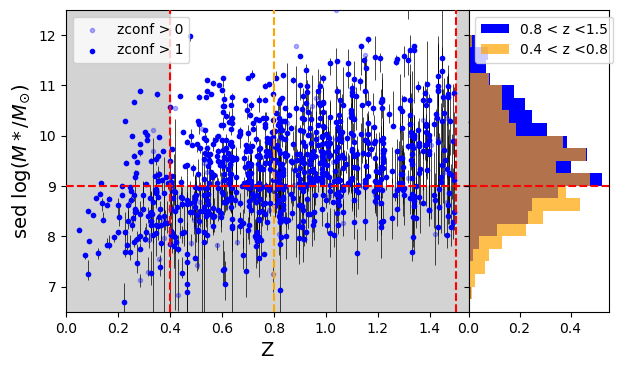

In [21]:
# Créer une figure et un axe principal pour le scatter plot
Mmax = 12.5
Mmin = 6.5
fig, ax = plt.subplots(figsize=(7, 4), dpi = 100)
ax.vlines(Rforeground_mass["Z"], Rforeground_mass["sed_logMass_l95"], Rforeground_mass["sed_logMass_u95"], \
          color = "black", linewidth = 0.5, zorder = 2)
ax.scatter(Rforeground_mass["Z"], Rforeground_mass["sed_logMass"],  marker='.', c = "blue", alpha = 0.3,\
                zorder = 3, label = "zconf > 0")
ax.scatter(Rforeground_zconf1_mass["Z"], Rforeground_zconf1_mass["sed_logMass"],  marker='.', c = "blue",\
           alpha = 1, zorder = 4, label = "zconf > 1")
ax.scatter(Rforeground_nomass["Z"], np.ones(len(Rforeground_nomass))*4.15,  marker='$\downarrow$', \
           c = "blue", alpha = 0.3, zorder = 3)
ax.scatter(Rforeground_zconf1_nomass["Z"], np.ones(len(Rforeground_zconf1_nomass))*4.15,  marker='$\downarrow$', \
           c = "blue", zorder = 3)
plt.ylim((Mmin, Mmax))
plt.xlim((0, 1.55))
plt.xlabel("Z", size = 14)
plt.ylabel("sed $\log(M*/M_{\odot}$)", size = 14)
plt.legend()
# Créer un axe pour l'histogramme à droite du scatter plot
plt.axvline(0.4, c = 'r', linestyle = "--", zorder = 4)
plt.axvline(1.5, c = 'r', linestyle = "--", zorder = 4)
plt.axvline(0.8, c = 'orange', linestyle = "--", zorder = 4)
plt.axhline(9, c = 'r', linestyle = "--", zorder = 4)
ax.axvspan(0, 0.4, color='lightgray', alpha=1, zorder = 1)
ax.axvspan(1.5, 2., color='lightgray', alpha=1, zorder = 1)
ax.axhspan(3, 9., color='lightgray', alpha=1,zorder = 1)


divider = make_axes_locatable(ax);
ax_hist = divider.append_axes("right", size=1.4, pad=0.)


# Plotter l'histogramme
binsize = 0.25

nbins = int((Mmax - Mmin)/binsize)
ax_hist.hist(R_08_15_zconf1["sed_logMass"], bins = nbins, range = (Mmin,Mmax), \
             orientation='horizontal', color='blue', label = "0.8 < z <1.5", density = True);
ax_hist.hist(R_04_08_zconf1["sed_logMass"], bins = nbins,  range = (Mmin,Mmax),\
             orientation='horizontal', color='orange', label = "0.4 < z <0.8", alpha = 0.7, density = True);
ax_hist.set_yticklabels([]);
plt.axhline(9, c = 'r', linestyle = "--", zorder = 2)
plt.ylim((Mmin, Mmax))
plt.legend()

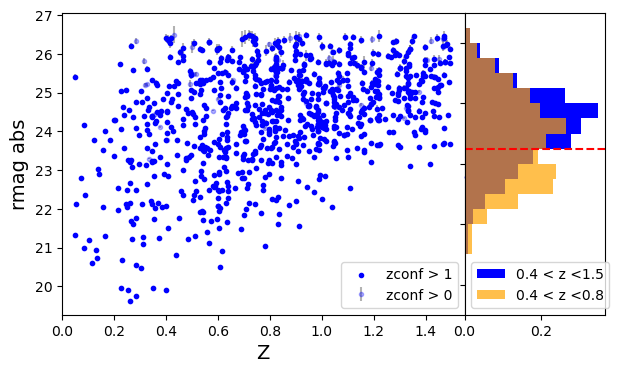

In [22]:
# Créer une figure et un axe principal pour le scatter plot
Mmax = -13
Mmin = -23
fig, ax = plt.subplots(figsize=(7, 4), dpi = 100)
#ax.vlines(Rforeground_mass["Z"], Rforeground_mass["m_abs_r"], Rforeground_mass["sed_logMass_u95"], \
#          color = "black", linewidth = 0.5, zorder = 2)
ax.errorbar(np.array(Rforeground_mass["Z"]), np.array(Rforeground_mass["SDSS_r"]), \
            yerr = np.array(Rforeground_mass["SDSS_r_ERR"]),\
            marker='.', c = "blue", alpha = 0.3, linestyle = "None", ecolor = "black",\
                zorder = 3, label = "zconf > 0")
#ax.scatter(Rforeground_mass["Z"], -Rforeground_mass["m_abs_r_correct"],  marker='.', c = "orange", alpha = 0.3,\
#                zorder = 3, label = "zconf > 0")
ax.scatter(Rforeground_zconf1_mass["Z"], Rforeground_zconf1_mass["SDSS_r"],  marker='.', c = "blue",\
           alpha = 1, zorder = 4, label = "zconf > 1")
#ax.scatter(Rforeground_nomass["Z"], np.ones(len(Rforeground_nomass))*4.15,  marker='$\downarrow$', \
#           c = "blue", alpha = 0.3, zorder = 3)
#ax.scatter(Rforeground_zconf1_nomass["Z"], np.ones(len(Rforeground_zconf1_nomass))*4.15,  marker='$\downarrow$', \
#           c = "blue", zorder = 3)
#plt.ylim((Mmin, Mmax))
plt.xlim((0, 1.55))
#plt.ylim((-13, -23))
plt.xlabel("Z", size = 14)
plt.ylabel("rmag abs", size = 14)
plt.legend()
# Créer un axe pour l'histogramme à droite du scatter plot
#plt.vlines([0.4, 1.5],  [-18.5, -18.5], [-24, -24], color = 'r', linestyle = "--", zorder = 4)
#plt.hlines([-18.5],  [0.4], [1.5], color = 'r', linestyle = "--", zorder = 4)

#plt.vlines([0.4, 0.8],  [-17, -17], [-24, -24], color = 'orange', linestyle = "-.", zorder = 4)
#plt.hlines([-17],  [0.4], [0.8], color = 'orange', linestyle = "-.", zorder = 4)

#plt.axvline(1.5, c = 'r', linestyle = "--", zorder = 4)
#plt.axvline(0.8, c = 'orange', linestyle = "--", zorder = 4)
#plt.axhline(9, c = 'r', linestyle = "--", zorder = 4)
#ax.axvspan(0, 0.4, color='lightgray', alpha=1, zorder = 1)
#ax.axvspan(1.5, 2., color='lightgray', alpha=1, zorder = 1)
#ax.axhspan(3, 9., color='lightgray', alpha=1,zorder = 1)


divider = make_axes_locatable(ax);
ax_hist = divider.append_axes("right", size=1.4, pad=0.)


# Plotter l'histogramme
binsize = 0.5

nbins = int((Mmax - Mmin)/binsize)
ax_hist.hist(R_04_15_zconf1["m_abs_r"], bins = nbins, range = (Mmin,Mmax), \
             orientation='horizontal', color='blue', label = "0.4 < z <1.5", density = True);
ax_hist.hist(R_04_08_zconf1["m_abs_r"], bins = nbins,  range = (Mmin,Mmax),\
             orientation='horizontal', color='orange', label = "0.4 < z <0.8", alpha = 0.7, density = True);
ax_hist.set_yticklabels([]);
plt.axhline(-18.5, c = 'r', linestyle = "--", zorder = 2)
plt.ylim((Mmax, Mmin))
plt.legend()

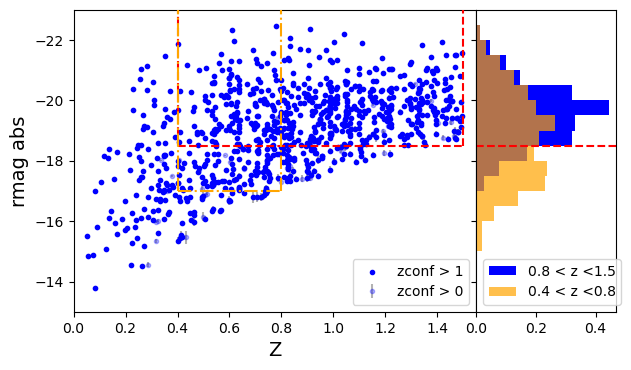

In [30]:
# Créer une figure et un axe principal pour le scatter plot
Mmax = -13
Mmin = -23
fig, ax = plt.subplots(figsize=(7, 4), dpi = 100)
#ax.vlines(Rforeground_mass["Z"], Rforeground_mass["m_abs_r"], Rforeground_mass["sed_logMass_u95"], \
#          color = "black", linewidth = 0.5, zorder = 2)
ax.errorbar(np.array(Rforeground_mass["Z"]), np.array(Rforeground_mass["m_abs_r"]), \
            yerr = np.array(Rforeground_mass["SDSS_r_ERR"]),\
            marker='.', c = "blue", alpha = 0.3, linestyle = "None", ecolor = "black",\
                zorder = 3, label = "zconf > 0")
#ax.scatter(Rforeground_mass["Z"], -Rforeground_mass["m_abs_r_correct"],  marker='.', c = "orange", alpha = 0.3,\
#                zorder = 3, label = "zconf > 0")
ax.scatter(Rforeground_zconf1_mass["Z"], Rforeground_zconf1_mass["m_abs_r"],  marker='.', c = "blue",\
           alpha = 1, zorder = 4, label = "zconf > 1")
#ax.scatter(Rforeground_nomass["Z"], np.ones(len(Rforeground_nomass))*4.15,  marker='$\downarrow$', \
#           c = "blue", alpha = 0.3, zorder = 3)
#ax.scatter(Rforeground_zconf1_nomass["Z"], np.ones(len(Rforeground_zconf1_nomass))*4.15,  marker='$\downarrow$', \
#           c = "blue", zorder = 3)
#plt.ylim((Mmin, Mmax))
plt.xlim((0, 1.55))
plt.ylim((Mmax, Mmin))
plt.xlabel("Z", size = 14)
plt.ylabel("rmag abs", size = 14)
plt.legend()
# Créer un axe pour l'histogramme à droite du scatter plot
plt.vlines([0.4, 1.5],  [-18.5, -18.5], [-24, -24], color = 'r', linestyle = "--", zorder = 4)
plt.hlines([-18.5],  [0.4], [1.5], color = 'r', linestyle = "--", zorder = 4)

plt.vlines([0.4, 0.8],  [-17, -17], [-24, -24], color = 'orange', linestyle = "-.", zorder = 4)
plt.hlines([-17],  [0.4], [0.8], color = 'orange', linestyle = "-.", zorder = 4)

#plt.axvline(1.5, c = 'r', linestyle = "--", zorder = 4)
#plt.axvline(0.8, c = 'orange', linestyle = "--", zorder = 4)
#plt.axhline(9, c = 'r', linestyle = "--", zorder = 4)
#ax.axvspan(0, 0.4, color='lightgray', alpha=1, zorder = 1)
#ax.axvspan(1.5, 2., color='lightgray', alpha=1, zorder = 1)
#ax.axhspan(3, 9., color='lightgray', alpha=1,zorder = 1)


divider = make_axes_locatable(ax);
ax_hist = divider.append_axes("right", size=1.4, pad=0.)


# Plotter l'histogramme
binsize = 0.5

nbins = int((Mmax - Mmin)/binsize)
ax_hist.hist(R_08_15_zconf1["m_abs_r"], bins = nbins, range = (Mmin,Mmax), \
             orientation='horizontal', color='blue', label = "0.8 < z <1.5", density = True);
ax_hist.hist(R_04_08_zconf1["m_abs_r"], bins = nbins,  range = (Mmin,Mmax),\
             orientation='horizontal', color='orange', label = "0.4 < z <0.8", alpha = 0.7, density = True);
ax_hist.set_yticklabels([]);
plt.axhline(-18.5, c = 'r', linestyle = "--", zorder = 2)
plt.ylim((Mmax, Mmin))
plt.legend()

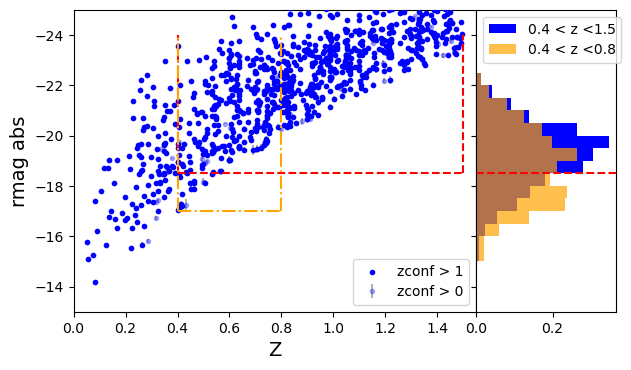

In [24]:
# Créer une figure et un axe principal pour le scatter plot
Mmax = -13
Mmin = -25
fig, ax = plt.subplots(figsize=(7, 4), dpi = 100)
#ax.vlines(Rforeground_mass["Z"], Rforeground_mass["m_abs_r"], Rforeground_mass["sed_logMass_u95"], \
#          color = "black", linewidth = 0.5, zorder = 2)
ax.errorbar(np.array(Rforeground_mass["Z"]), np.array(Rforeground_mass["m_abs_r_correct"]), \
            yerr = np.array(Rforeground_mass["SDSS_r_ERR"]),\
            marker='.', c = "blue", alpha = 0.3, linestyle = "None", ecolor = "black",\
                zorder = 3, label = "zconf > 0")
#ax.scatter(Rforeground_mass["Z"], -Rforeground_mass["m_abs_r_correct"],  marker='.', c = "orange", alpha = 0.3,\
#                zorder = 3, label = "zconf > 0")
ax.scatter(Rforeground_zconf1_mass["Z"], Rforeground_zconf1_mass["m_abs_r_correct"],  marker='.', c = "blue",\
           alpha = 1, zorder = 4, label = "zconf > 1")
#ax.scatter(Rforeground_nomass["Z"], np.ones(len(Rforeground_nomass))*4.15,  marker='$\downarrow$', \
#           c = "blue", alpha = 0.3, zorder = 3)
#ax.scatter(Rforeground_zconf1_nomass["Z"], np.ones(len(Rforeground_zconf1_nomass))*4.15,  marker='$\downarrow$', \
#           c = "blue", zorder = 3)
#plt.ylim((Mmin, Mmax))
plt.xlim((0, 1.55))
plt.ylim((Mmax, Mmin))
plt.xlabel("Z", size = 14)
plt.ylabel("rmag abs", size = 14)
plt.legend()
# Créer un axe pour l'histogramme à droite du scatter plot
plt.vlines([0.4, 1.5],  [-18.5, -18.5], [-24, -24], color = 'r', linestyle = "--", zorder = 4)
plt.hlines([-18.5],  [0.4], [1.5], color = 'r', linestyle = "--", zorder = 4)

plt.vlines([0.4, 0.8],  [-17, -17], [-24, -24], color = 'orange', linestyle = "-.", zorder = 4)
plt.hlines([-17],  [0.4], [0.8], color = 'orange', linestyle = "-.", zorder = 4)

divider = make_axes_locatable(ax);
ax_hist = divider.append_axes("right", size=1.4, pad=0.)


# Plotter l'histogramme
binsize = 0.5
nbins = int((Mmax - Mmin)/binsize)
ax_hist.hist(R_04_15_zconf1["m_abs_r"], bins = nbins, range = (Mmin,Mmax), \
             orientation='horizontal', color='blue', label = "0.4 < z <1.5", density = True);
ax_hist.hist(R_04_08_zconf1["m_abs_r"], bins = nbins,  range = (Mmin,Mmax),\
             orientation='horizontal', color='orange', label = "0.4 < z <0.8", alpha = 0.7, density = True);
ax_hist.set_yticklabels([]);
plt.axhline(-18.5, c = 'r', linestyle = "--", zorder = 2)
plt.ylim((Mmax, Mmin))
plt.legend()

# Inclination

Text(0.5, 0, 'inclination')

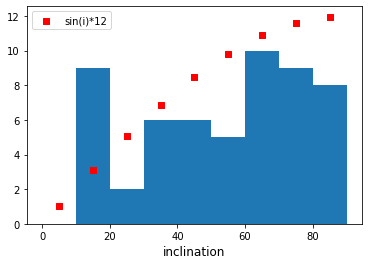

In [63]:
ii = np.linspace(5, 85, 9)
plt.hist(isol_snr3_good_runs["inclination"], bins = 9, range = (0,90));
plt.scatter(ii, np.sin(ii*2*np.pi/360)*12, c = "r", zorder = 3, marker = "s", label = "sin(i)*12")
plt.legend()
plt.xlabel("inclination", size = 12)

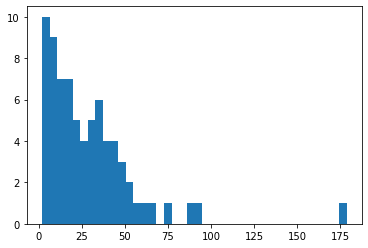

In [64]:
plt.hist(isol_9["velocity_dispersion"], bins = 40);

We have 2 galaxies of logM above 9 but no multinest run. After inspection, it is because there is no OII:

In [65]:
K = isol_9[isol_9["run_name"] != "run_OII_multinest"]
K[["field_id", "ID", "run_name"]]

field_id     ID run_name
65  J0014m0028  11083      NaN

In [66]:
R_all = pd.read_csv("results_6_conservative.csv")
R_all["ZCONF"].unique()

array([3, 2, 1])

(1, 100)

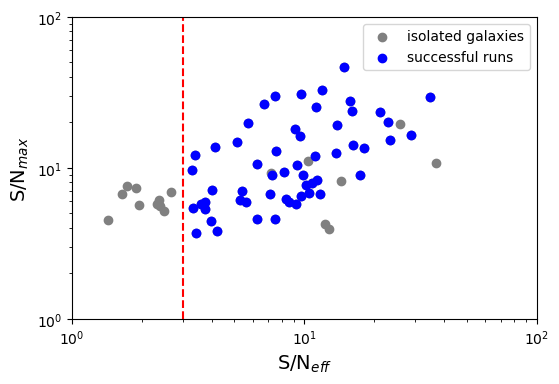

In [67]:
plt.figure(dpi = 100)
plt.scatter(isol_9["snr_eff"], isol_9["snr_max"], c = "gray", label = "isolated galaxies")
plt.scatter(isol_snr3_good_runs["snr_eff"], isol_snr3_good_runs["snr_max"], c = "blue", label = "successful runs")
plt.legend()
plt.xlabel("S/N$_{eff}$", size = 14)
plt.ylabel("S/N$_{max}$", size = 14)
plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlim((1,100))
plt.ylim((1,100))

(0.2, 10)

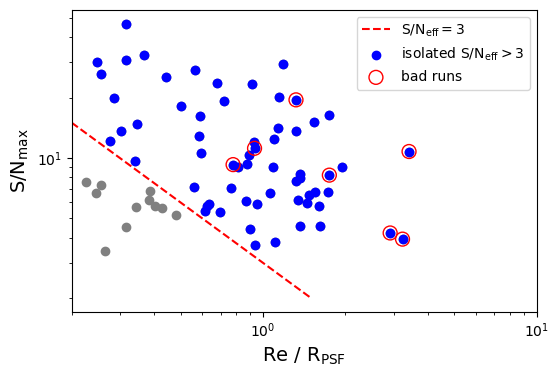

In [68]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
muse_sampling = 0.2
plt.figure(dpi = 100)
plt.scatter(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"], isol_9["snr_max"], c = "gray",)
plt.scatter(isol_snr3["radius"]*muse_sampling/isol_snr3["psf_fwhm"], isol_snr3["snr_max"], c = "blue", \
            label = "isolated S/N$_{\mathrm{eff}} > 3$")
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
plt.scatter(isol_notgood_runs["radius"]*muse_sampling/isol_notgood_runs["psf_fwhm"], isol_notgood_runs["snr_max"], \
            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
plt.plot(xx, yy, c = "red", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 3$")
plt.xlabel("Re / R$_{\mathrm{PSF}}$", size = 14)
plt.ylabel("S/N$_{\mathrm{max}}$", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim((0.2,10))
#plt.ylim((1,100))

In [69]:
isol_snr3_good_runs[["ID", "radius", "psf_fwhm", "snr_max", "snr_eff"]]

ID    radius  psf_fwhm    snr_max    snr_eff
74    11097  1.119244  0.610611  32.514164  11.919630
94    11117  1.458430  0.514718  27.624088  15.654317
230   12108  2.586147  0.880050  16.266750   9.560412
294   13063  5.684392  0.783887   5.949630   8.628805
354   13128  5.567285  0.818209   8.329474  11.335138
355   13129  4.292910  0.809910   6.686465   7.088289
439   14112  2.892715  0.667197   6.096214   5.286175
474   14148  4.219630  0.617005   7.912512  10.822558
509   15040  0.840110  0.679303  30.080204   7.440184
577   16063  1.366625  0.904447  13.637854   4.121375
583   16070  2.034073  0.810398  18.200698   9.136638
591   16079  2.445452  0.825310  10.587440   6.274267
673   17066  2.164893  0.740576  12.920636   7.554068
687   17080  0.993869  0.718478  12.208898   3.377711
709   17102  5.534809  0.721445  15.171674  23.278918
755   18063  2.103038  0.687072   5.439654   3.330013
788   18097  3.425957  0.741421  11.966047  11.058544
834   19072  3.220095  0.590027   9.016454   9.841535
865   19103  5.193842  0.536151   8.973103  17.384979
910   20052  0.888391  0.511684  14.802696   5.140120
924   20066  2.625093  0.478816  12.472245  13.675729
935   20077  3.832533  0.473340   4.600445   7.449773
1023  21107  2.497614  0.714196   5.362483   3.750629
1027  21111  3.629754  0.547670  13.593753  18.018866
1033  21117  2.096290  0.671510   5.758951   3.595608
1042  21126  0.993564  0.693725  19.919413   5.705776
1043  21127  2.738123  0.613550  10.375156   9.260360
1091  22047  0.842022  0.660343  26.320401   6.712381
1092  22048  0.929704  0.588087  30.677753   9.699658
1110  22066  4.242569  0.619419   4.573412   6.264909
1195  23092  1.025663  0.651676  46.827874  14.740341
1204  23102  4.754559  0.709108   6.188036   8.298140
1224  23122  4.351771  0.661175   7.687262  10.119326
1303  24052  4.356195  0.785101   3.788536   4.204198
1390  25087  1.752265  0.626435   7.153291   4.001842
1397  25095  2.342135  0.649045  19.230959  13.879322
1483  26095  4.138203  0.534209   6.765230  10.481249
1571  27094  4.785696  0.596685   5.741318   9.209622
1579  27102  4.772747  0.646595   6.547470   9.665841
1581  28002  2.627101  0.553981   5.905207   5.600760
1624  28055  3.256390  0.549170  29.279233  34.723160
1625  28056  1.834890  0.542338  23.784074  16.093697
1722  29059  2.635849  0.578569  23.306438  21.235933
1729  29066  1.247734  0.561667  25.233729  11.211256
1736  29073  0.861085  0.505988   9.612055   3.271536
1740  29077  2.218739  0.494406   4.423698   3.970430
1779  30015  1.887178  0.404871   3.683968   3.434335
1802  30047  2.639838  0.461899  20.111453  22.988112
1812  30060  4.174940  0.480023  16.447746  28.610433
1902  31079  3.865527  0.884281   9.382639   8.203016
1910  31087  2.789517  0.880979   5.901543   3.737310
1930  31107  3.019750  0.792901   7.071478   5.386322
1994  32055  3.106570  0.545412  14.136494  16.103777
1998  32059  2.233774  0.552228   8.970884   7.257483
2019  32081  4.868006  0.564860   6.743377  11.622981

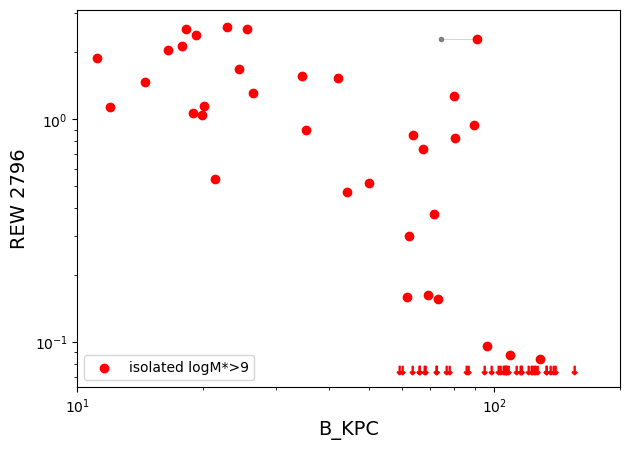

In [70]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((10, 200))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

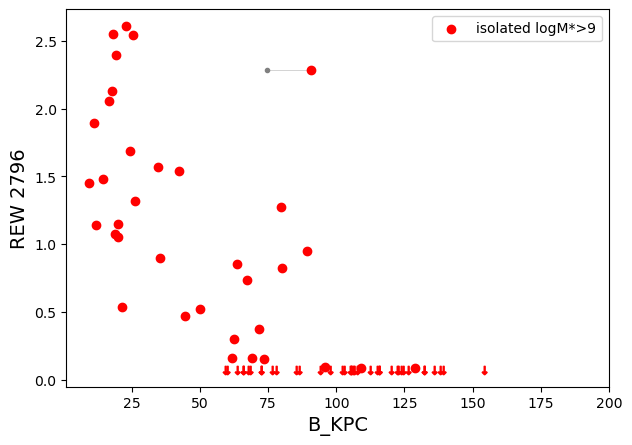

In [71]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

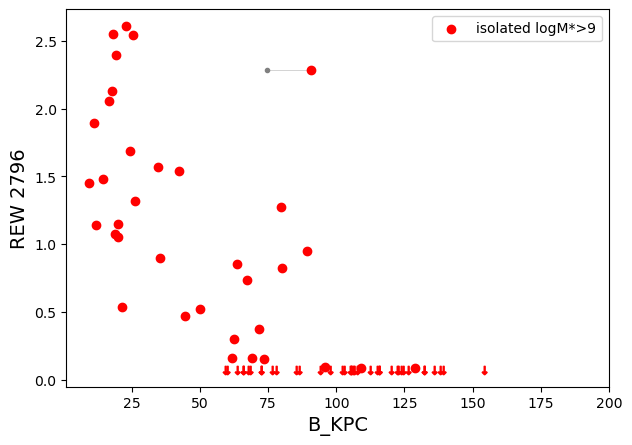

In [72]:
plt.figure(dpi = 100, figsize = (7, 5))
#plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

Text(0, 0.5, 'REW 2796')

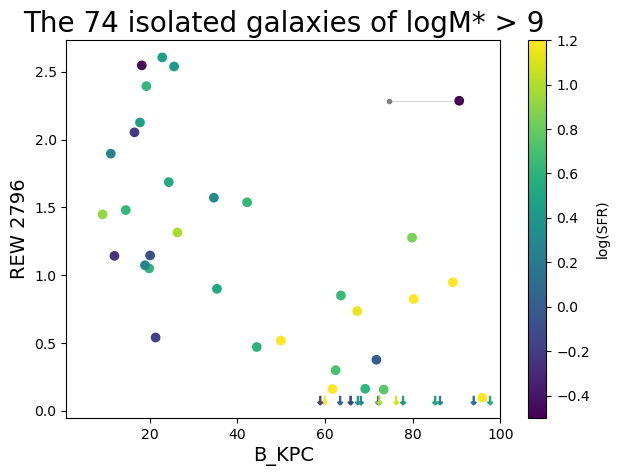

In [73]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"],\
                c = np.log10(isol_9_abs["SFR_gilbank"]), vmin = -0.5, vmax = 1.2,
                 label = "isolated logM*>9", zorder = 2)
plt.colorbar(label = "log(SFR)")
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"],\
            c = np.log10(isol_9_noabs["SFR_gilbank"]), vmin = -0.5, vmax = 1.2,
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 100))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
#plt.legend()

le SFR cause des vents stellaires. Mais il y a un décalage entre le moment ou les étoiles sont formées et le moment ou le gaz arrive dans la ligne de visée. Le temps mis par du gaz pour arriver dans la ligne de visée est de l'ordre de : 

In [74]:
dlos = 50*u.kpc #kpc
vout = 200*u.km/u.s#km/s

t = dlos/vout
t.to(u.Myr)

<Quantity 244.44805542 Myr>

# Closest galaxies

Text(0, 0.5, '$W^{2796}_r$')

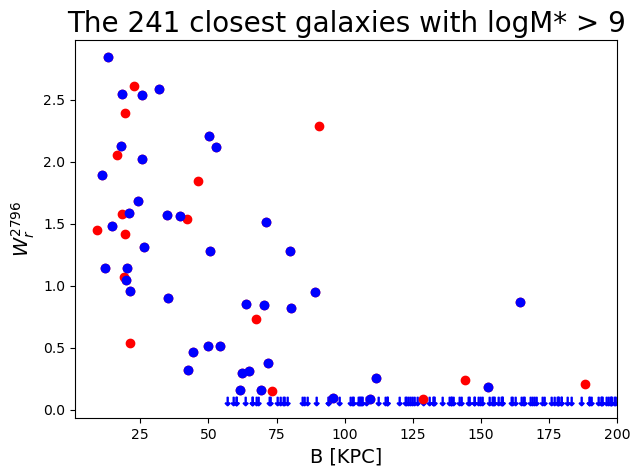

In [75]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(closest_9)) + " closest galaxies with logM* > 9", size = 20)
plt.scatter(closest_9_abs["B_KPC"], closest_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(closest_9_snr3_good_runs_abs["B_KPC"], closest_9_snr3_good_runs_abs["REW_2796"], c = 'b',\
                 label = "with snreff > 3 and good runs", zorder = 2)

plt.scatter(closest_9_noabs["B_KPC"], closest_9_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")

#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B [KPC]", size = 14)
plt.ylabel("$W^{2796}_r$", size = 14)
#plt.legend()

Text(0, 0.5, 'abs Dv')

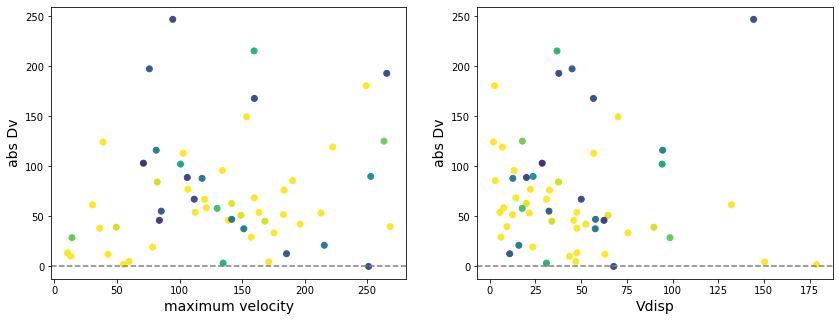

In [76]:
plt.figure(figsize = (14,5))
plt.subplot(121)
plt.scatter(closest_9_abs["maximum_velocity"], \
            closest_9_abs["vel_absorption_dist"]/1e3, c = closest_9_abs["snr_eff"], vmin = 0, vmax = 8)
#plt.plot([50, 250], [50, 250], c = "r", linestyle = "-.")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("maximum velocity", size = 14)
plt.ylabel("abs Dv", size = 14)

plt.subplot(122)
plt.scatter(closest_9_abs["velocity_dispersion"], \
            closest_9_abs["vel_absorption_dist"]/1e3, c = closest_9_abs["snr_eff"], vmin = 0, vmax = 8)
#plt.plot([50, 250], [50, 250], c = "r", linestyle = "-.")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("Vdisp", size = 14)
plt.ylabel("abs Dv", size = 14)

Text(0, 0.5, 'abs Dv')

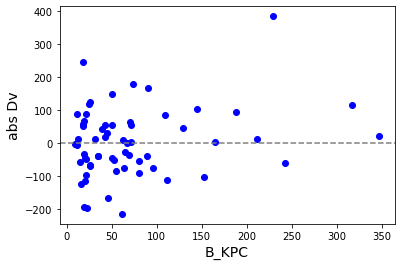

In [77]:
plt.scatter(closest_9_abs["B_KPC"], \
            const.c.value*(closest_9_abs["z_absorption"] - closest_9_abs["Z"])/(1+closest_9_abs["Z"])/1e3,\
            c = "blue")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("abs Dv", size = 14)

(0.0, 200.0)

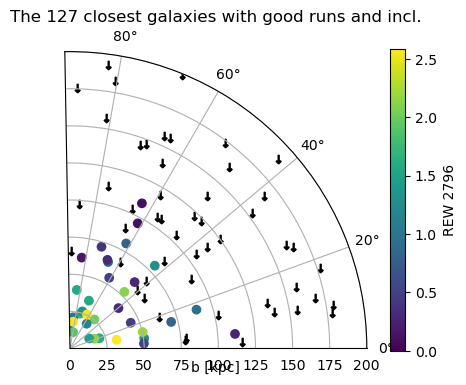

In [78]:
fig = plt.figure(dpi = 100)
ax = fig.add_subplot(projection='polar')
ax.set_title("The "+ str(len(closest_incl)) + " closest galaxies with good runs and incl.", size = 12)

c = ax.scatter(closest_incl_abs["alpha"]*2*np.pi/360, closest_incl_abs["B_KPC"], \
               c = closest_incl_abs["REW_2796"], vmin = 0)
fig.colorbar(c, label = "REW 2796")
c2 = ax.scatter(closest_incl_noabs["alpha"]*2*np.pi/360, closest_incl_noabs["B_KPC"], \
                marker = "$\downarrow$", c = "black")
plt.xlim((0,91*2*np.pi/360))
plt.xlabel("b [kpc]")
plt.ylim((0,200))

## Alpha dependence

For that we must only use the galaxies with good runs (82) and sufficient inclination to obtain a robust alpha. The 121 galaxies are then reduced to 58.

In [79]:
print("Nb of galaxies with snr 3 = ", len(isol_snr3))
print("Nb of galaxies with snr 3 and good runs = ", len(isol_snr3_good_runs))
print("Nb of galaxies with snr 3 and good runs rotation dominated with abs= ", len(isol_snr3_good_runs_abs))
print("Nb of galaxies with snr 3 and good runs rotation dominated without abs= ", len(isol_snr3_good_runs_noabs))

Nb of galaxies with snr 3 =  62
Nb of galaxies with snr 3 and good runs =  55
Nb of galaxies with snr 3 and good runs rotation dominated with abs=  24
Nb of galaxies with snr 3 and good runs rotation dominated without abs=  31


Text(0, 0.5, 'REW 2796')

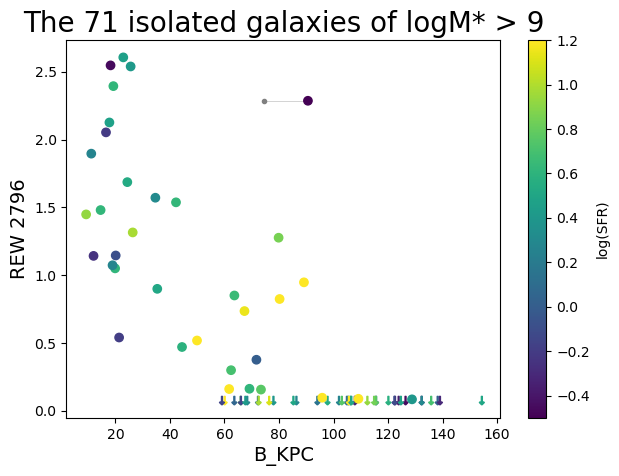

In [80]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_snr3_good_runs_rot)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"],\
                c = np.log10(isol_9_abs["SFR_gilbank"]), vmin = -0.5, vmax = 1.2,
                 label = "isolated logM*>9", zorder = 2)
plt.colorbar(label = "log(SFR)")
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"],\
            c = np.log10(isol_9_noabs["SFR_gilbank"]), vmin = -0.5, vmax = 1.2,
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
#plt.xlim((1, 100))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
#plt.legend()

Text(0, 0.5, 'REW 2796')

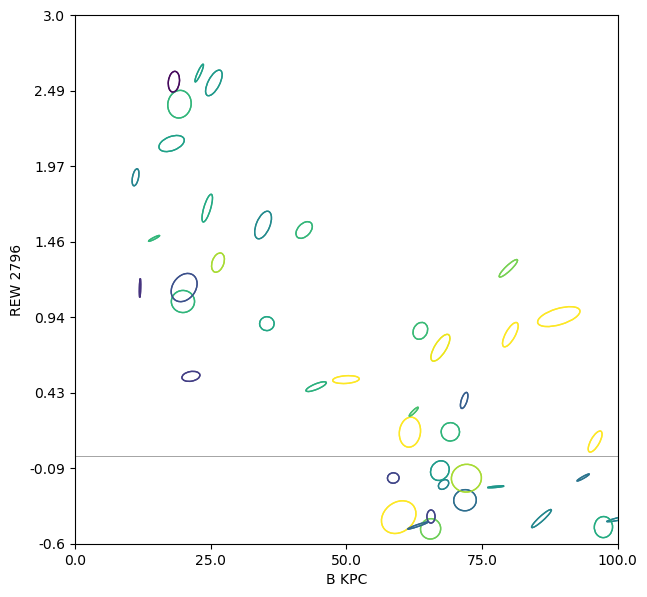

In [81]:
fig = plt.figure(figsize = (7,7), dpi = 100)
#plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = "blue", label = "all")
#plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"],c = "blue", marker = "$\downarrow$")

ymin = -0.6
ymax = 3.
xmin = 0
xmax = 100
massmin = 9
massmax = 12
ss_min = 0.02
ss_max = 0.1
vmin = -0.5
vmax = 1.2

for i, g in isol_good_runs.iterrows():
    xx = (g["B_KPC"] - xmin)/(xmax - xmin)
    yy = (g["REW_2796"] - ymin)/(ymax - ymin)
    if g["REW_2796"] == 0:
        randy = random.uniform(-0.5, -0.05)
        yy = (randy - ymin)/(ymax - ymin)
    
    mass = g["sed_logMass"]
    incl = g["inclination"]
    alpha = g["alpha"]
    logSFR = np.log10(g["SFR_gilbank"])
    z = g["Z"]
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=alpha,\
                        edgecolor = plt.cm.viridis((logSFR - vmin) / (vmax - vmin)), fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
    else:
        plt.scatter(xx, yy)
    
#plotting the 0 line
plt.axhline(-ymin/(ymax - ymin), c = "gray", linewidth = 0.5)

# Now for the axis:
step = 5
xdata = np.linspace(0, 1, 5)
xvalues = np.linspace(xmin, xmax, 5)
ydata = np.linspace(0,1, 8)
yvalues = np.round(np.linspace(ymin, ymax, 8),2)
    
plt.xlim((0, 1))
plt.ylim((0, 1))
# Set custom tick values for the x-axis
plt.xticks(xdata, xvalues)
plt.yticks(ydata, yvalues)

plt.xlabel("B KPC")
plt.ylabel("REW 2796")

In [82]:
fig = plt.figure(figsize = (7,7), dpi = 100)
#plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = "blue", label = "all")
#plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"],c = "blue", marker = "$\downarrow$")

ymin = 0
ymax = 300
xmin = 0
xmax = 100
massmin = 9
massmax = 12
ss_min = 0.02
ss_max = 0.1
vmin = -0.5
vmax = 1.2

for i, g in isol_good_runs_abs.iterrows():
    xx = (g["B_KPC"] - xmin)/(xmax - xmin)
    yy = (g["vel_absorption_dist"]/1e3 - ymin)/(ymax - ymin)
    #if g["REW_2796"] == 0:
    #    randy = random.uniform(-0.5, -0.05)
    #    yy = (randy - ymin)/(ymax - ymin)
    
    mass = g["sed_logMass"]
    incl = g["inclination"]
    alpha = g["alpha"]
    logSFR = np.log10(g["SFR_gilbank"])
    z = g["Z"]
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=alpha,\
                        #edgecolor = plt.cm.viridis((logSFR - vmin) / (vmax - vmin)), fill = False)
                                             fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
    else:
        plt.scatter(xx, yy)
    
#plotting the 0 line
plt.axhline(-ymin/(ymax - ymin), c = "gray", linewidth = 0.5)

# Now for the axis:
step = 5
xdata = np.linspace(0, 1, 5)
xvalues = np.linspace(xmin, xmax, 5)
ydata = np.linspace(0,1, 8)
yvalues = np.round(np.linspace(ymin, ymax, 8),2)
    
plt.xlim((0, 1))
plt.ylim((0, 1))
# Set custom tick values for the x-axis
plt.xticks(xdata, xvalues)
plt.yticks(ydata, yvalues)

plt.xlabel("B KPC")
plt.ylabel("vel abs (km/s)")

NameError: name 'isol_good_runs_abs' is not defined

<Figure size 700x700 with 0 Axes>

Text(0.5, 0, 'b [kpc]')

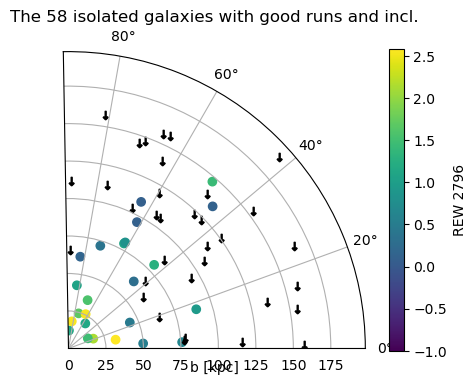

In [44]:
fig = plt.figure(dpi = 100)
ax = fig.add_subplot(projection='polar')
ax.set_title("The "+ str(len(isol_incl_good_runs)) + " isolated galaxies with good runs and incl.", size = 12)

c = ax.scatter(isol_incl_good_runs_abs["alpha"]*2*np.pi/360, isol_incl_good_runs_abs["B_KPC"], \
               c = isol_incl_good_runs_abs["REW_2796"], vmin = -1)
fig.colorbar(c, label = "REW 2796")
c2 = ax.scatter(isol_incl_good_runs_noabs["alpha"]*2*np.pi/360, isol_incl_good_runs_noabs["B_KPC"], \
                marker = "$\downarrow$", c = "black")
plt.xlim((0,91*2*np.pi/360))
plt.xlabel("b [kpc]")

Text(0.5, 0, 'b [kpc]')

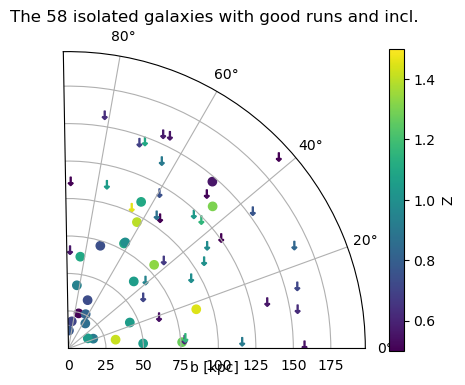

In [45]:
fig = plt.figure(dpi = 100)
ax = fig.add_subplot(projection='polar')
ax.set_title("The "+ str(len(isol_incl_good_runs)) + " isolated galaxies with good runs and incl.", size = 12)

c = ax.scatter(isol_incl_good_runs_abs["alpha"]*2*np.pi/360, isol_incl_good_runs_abs["B_KPC"], \
               c = isol_incl_good_runs_abs["Z"], vmin = 0.5, vmax = 1.5)
fig.colorbar(c, label = "Z")
c2 = ax.scatter(isol_incl_good_runs_noabs["alpha"]*2*np.pi/360, isol_incl_good_runs_noabs["B_KPC"], \
                marker = "$\downarrow$", c = isol_incl_good_runs_noabs["Z"], vmin = 0.5, vmax = 1.5)
plt.xlim((0,91*2*np.pi/360))
plt.xlabel("b [kpc]")

Text(0.5, 0, 'b [kpc]')

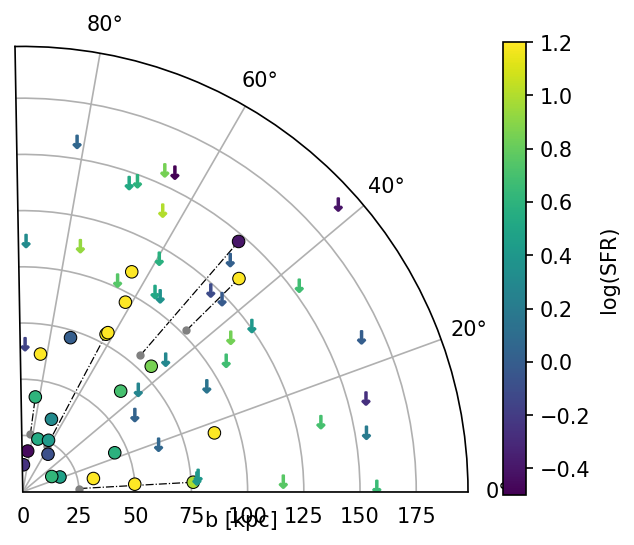

In [46]:
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(projection='polar')
#ax.set_title("The "+ str(len(isol_incl_good_runs)) + " isolated galaxies with good runs and incl.", size = 12)
for i, g in isol_incl_good_runs_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    gmin = K[K["B_KPC"] == bmin]
    angle = g["alpha"]*2*np.pi/360
    plt.plot([angle, angle], [bmin, bmax], color = "black", linewidth = 0.6, linestyle = "-.", zorder = 1)
    plt.scatter(angle, bmin, marker = ".", c = "grey", zorder = 2)
    
    
c = ax.scatter(isol_incl_good_runs_abs["alpha"]*2*np.pi/360, isol_incl_good_runs_abs["B_KPC"], \
               c = np.log10(isol_incl_good_runs_abs["SFR_gilbank"]), vmin = -0.5, vmax = 1.2, zorder = 2,\
              edgecolor = "black", linewidths = 0.5)
#              s = (isol_incl_good_runs_abs["sed_logMass"]-9)*100)
fig.colorbar(c, label = "log(SFR)")
c2 = ax.scatter(isol_incl_good_runs_noabs["alpha"]*2*np.pi/360, isol_incl_good_runs_noabs["B_KPC"], \
                marker = "$\downarrow$", \
                c = np.log10(isol_incl_good_runs_noabs["SFR_gilbank"]), vmin = -0.5, vmax = 1.2, zorder = 2)
plt.xlim((0,91*2*np.pi/360))
plt.xlabel("b [kpc]")

**We have a bit more absorption cases at high alpha. But it seems to play a minor role in the presence and strength of absorption nonetheless**. Between 20 and 40° there are several cases of low B and no abs.

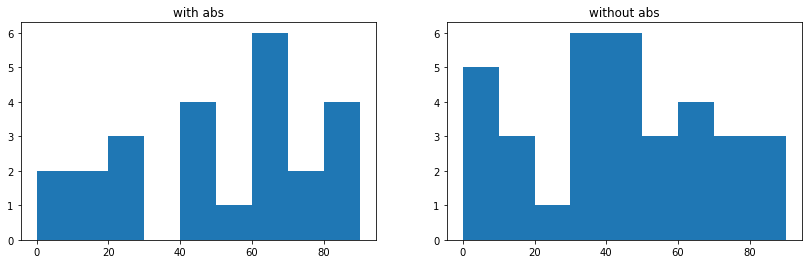

In [47]:
plt.figure(figsize = (14, 4))
plt.subplot(121)
plt.title("with abs")
plt.hist(isol_incl_good_runs_abs["alpha"], bins = 9, range = (0,90));
plt.subplot(122)
plt.title("without abs")
plt.hist(isol_incl_good_runs_noabs["alpha"], bins = 9, range = (0,90));

In [1277]:
isol_incl_good_runs_100 = isol_incl_good_runs[isol_incl_good_runs["B_KPC"]<100]
isol_incl_good_runs_50_100 = isol_incl_good_runs_100[isol_incl_good_runs_100["B_KPC"]>50]
isol_good_runs_100 = isol_good_runs[isol_good_runs["B_KPC"]<100]
isol_good_runs_50_100 = isol_good_runs_100[isol_good_runs_100["B_KPC"]>50]
isol_100 = isol_9[isol_9["B_KPC"]<100]
isol_50 = isol_9[isol_9["B_KPC"]<50]
isol_50_100 = isol_100[isol_100["B_KPC"]>50]

isol_incl_good_runs_100_abs = isol_incl_good_runs_100[isol_incl_good_runs_100["REW_2796"]> 0]
isol_incl_good_runs_100_noabs = isol_incl_good_runs_100[isol_incl_good_runs_100["REW_2796"]== 0]
isol_good_runs_100_abs = isol_good_runs_100[isol_good_runs_100["REW_2796"]> 0]
isol_good_runs_100_noabs = isol_good_runs_100[isol_good_runs_100["REW_2796"]== 0]
isol_incl_good_runs_50_100_abs = isol_incl_good_runs_50_100[isol_incl_good_runs_50_100["REW_2796"]> 0]
isol_incl_good_runs_50_100_noabs = isol_incl_good_runs_50_100[isol_incl_good_runs_50_100["REW_2796"]== 0]

isol_incl_good_runs_50_100_abs = isol_incl_good_runs_50_100[isol_incl_good_runs_50_100["REW_2796"]> 0]
isol_incl_good_runs_50_100_noabs = isol_incl_good_runs_50_100[isol_incl_good_runs_50_100["REW_2796"]== 0]

isol_50_100_abs = isol_50_100[isol_50_100["REW_2796"]> 0]
isol_50_100_noabs = isol_50_100[isol_50_100["REW_2796"]== 0]

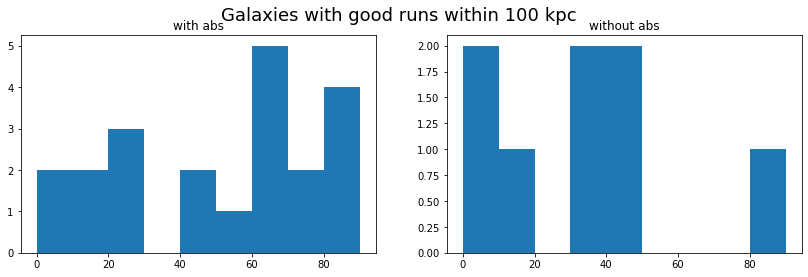

In [49]:
plt.figure(figsize = (14, 4))
plt.suptitle("Galaxies with good runs within 100 kpc", size = 18)
plt.subplot(121)
plt.title("with abs")
plt.hist(isol_incl_good_runs_100_abs["alpha"], bins = 9, range = (0,90));
plt.subplot(122)
plt.title("without abs")
plt.hist(isol_incl_good_runs_100_noabs["alpha"], bins = 9, range = (0,90));

Text(0.5, 0, 'alpha')

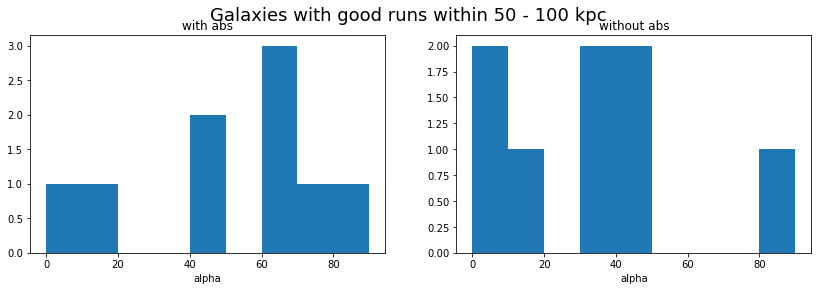

In [50]:
plt.figure(figsize = (14, 4))
plt.suptitle("Galaxies with good runs within 50 - 100 kpc", size = 18)
plt.subplot(121)
plt.title("with abs")
plt.hist(isol_incl_good_runs_50_100_abs["alpha"], bins = 9, range = (0,90));
plt.xlabel("alpha")
plt.subplot(122)
plt.title("without abs")
plt.hist(isol_incl_good_runs_50_100_noabs["alpha"], bins = 9, range = (0,90));
plt.xlabel("alpha")

Text(0.5, 0, 'log(SFR)')

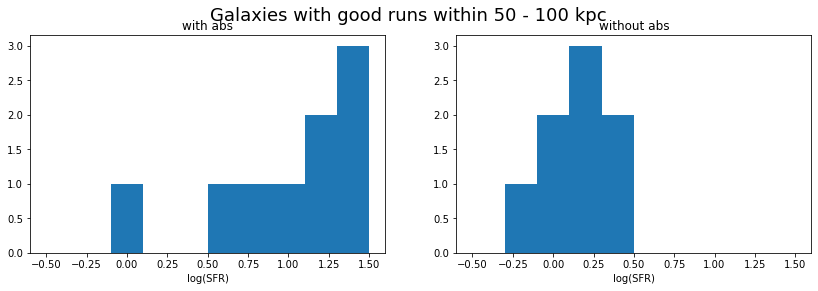

In [51]:
plt.figure(figsize = (14, 4))
plt.suptitle("Galaxies with good runs within 50 - 100 kpc", size = 18)
plt.subplot(121)
plt.title("with abs")
plt.hist(np.log10(isol_incl_good_runs_50_100_abs["SFR_gilbank"]), bins = 10, range = (-0.5,1.5));
plt.xlabel("log(SFR)")
plt.subplot(122)
plt.title("without abs")
plt.hist(np.log10(isol_incl_good_runs_50_100_noabs["SFR_gilbank"]), bins = 10, range = (-0.5,1.5));
plt.xlabel("log(SFR)")

Text(0.5, 0, 'log(SFR)')

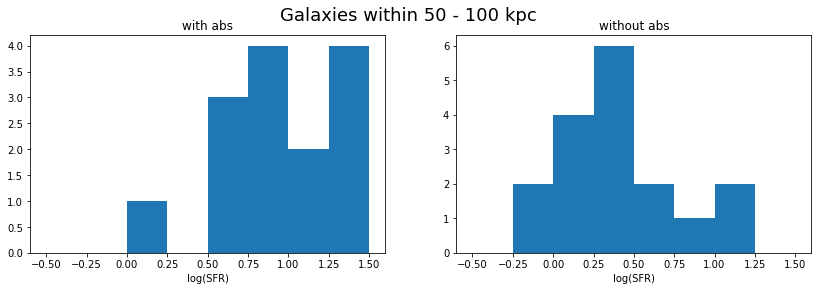

In [127]:
plt.figure(figsize = (14, 4))
plt.suptitle("Galaxies within 50 - 100 kpc", size = 18)
plt.subplot(121)
plt.title("with abs")
plt.hist(np.log10(isol_50_100_abs["SFR_gilbank"]), bins = 8, range = (-0.5,1.5));
plt.xlabel("log(SFR)")
plt.subplot(122)
plt.title("without abs")
plt.hist(np.log10(isol_50_100_noabs["SFR_gilbank"]), bins = 8, range = (-0.5,1.5));
plt.xlabel("log(SFR)")

Text(0.5, 0, 'alpha')

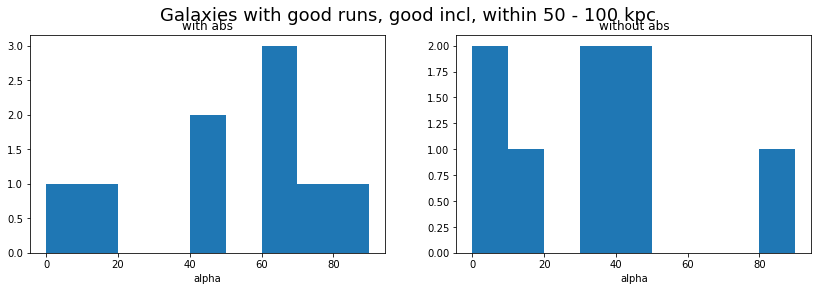

In [133]:
plt.figure(figsize = (14, 4))
plt.suptitle("Galaxies with good runs, good incl, within 50 - 100 kpc", size = 18)
plt.subplot(121)
plt.title("with abs")
plt.hist(isol_incl_good_runs_50_100_abs["alpha"], bins = 9, range = (0,90));
plt.xlabel("alpha")
plt.subplot(122)
plt.title("without abs")
plt.hist(isol_incl_good_runs_50_100_noabs["alpha"], bins = 9, range = (0,90));
plt.xlabel("alpha")

Text(0, 0.5, 'log(SFR)')

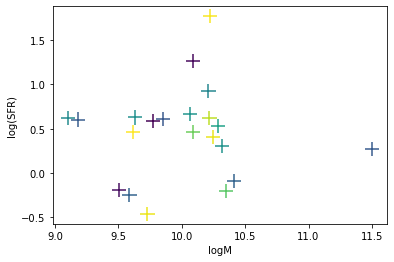

In [1279]:
plt.scatter(isol_50["sed_logMass"], np.log10(isol_50["SFR_gilbank"]), \
            c = isol_50["REW_2796"], marker = "+", s = 200, facecolors = "none")
plt.xlabel("logM")
plt.ylabel("log(SFR)")

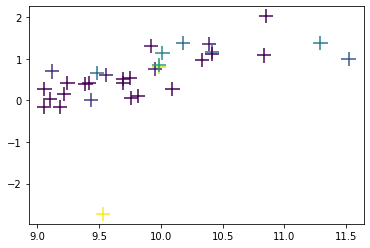

In [1275]:
plt.scatter(isol_50_100["sed_logMass"], np.log10(isol_50_100["SFR_gilbank"]), \
            c = isol_50_100["REW_2796"], marker = "+", s = 200, facecolors = "none")

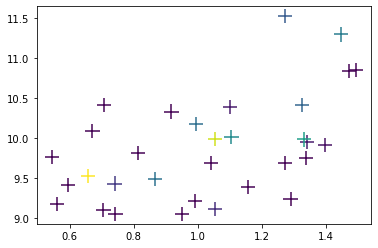

In [1283]:
plt.scatter(isol_50_100["Z"], isol_50_100["sed_logMass"], \
            c = isol_50_100["REW_2796"], marker = "+", s = 200, facecolors = "none")

(-2.0, 2.0)

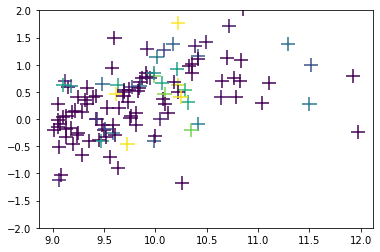

In [1281]:
plt.scatter(isol_9["sed_logMass"], np.log10(isol_9["SFR_gilbank"]), \
            c = isol_9["REW_2796"], marker = "+", s = 200, facecolors = "none")
plt.ylim((-2,2))

In [130]:
print("Out of the ", len(R100), "galaxies with ZCONF > 0 in 100 kpc, ", \
      len(R100[R100["run_name"] == "run_OII_multinest"]), " have a multinest run")
print("Out of the ", len(R150), "galaxies with ZCONF > 0 in 150 kpc, ", \
      len(R150[R150["run_name"] == "run_OII_multinest"]), " have a multinest run")
print("Out of the ", len(R200), "galaxies with ZCONF > 0 in 200 kpc, ", \
      len(R200[R200["run_name"] == "run_OII_multinest"]), " have a multinest run")

Out of the  227 galaxies with ZCONF > 0 in 100 kpc,  202  have a multinest run
Out of the  420 galaxies with ZCONF > 0 in 150 kpc,  386  have a multinest run
Out of the  671 galaxies with ZCONF > 0 in 200 kpc,  407  have a multinest run


In [54]:
input_path = "/muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/"
output_path = "/muse/MG2QSO/private/analysis/galpak_dr2/"
#gt.build_catalog(isol_9, output_path, output_path, file_name = "isolated_catalog_2023_10_18")

In [55]:
#gt.substract_continuum_on_ids(R150, input_path, output_path, snr_min = 0, line = "OII")

In [56]:
#gt.run_galpak_on_ids(input_path, output_path, R150, snr_min = 0.5, mag_sdss_r_max = 28,\
#                   flux_profile = "sersic", rotation_curve = "Salucci",autorun = False, mcmc_method = "multinest",\
#                   save = True, line = "OII", overwrite = False, suffix = "multinest")

Logically we should see (at least for the winds) a relation between the inclination and the velocity difference with the absorption.

In [57]:
winds = isol_incl_good_runs[isol_incl_good_runs["alpha"] > 66]
accretions = isol_incl_good_runs[isol_incl_good_runs["alpha"] < 33]

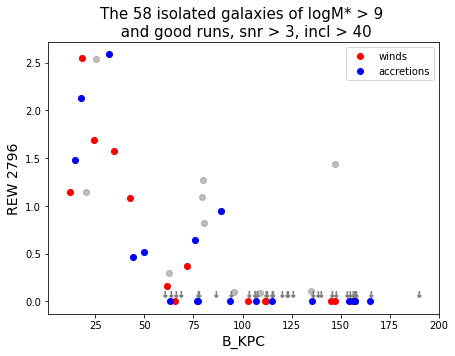

In [58]:
plt.figure(figsize = (7, 5))
plt.title("The " + str(len(isol_incl_good_runs)) + \
          " isolated galaxies of logM* > 9 \n and good runs, snr > 3, incl > 40",\
          size = 15)

plt.scatter(isol_incl_good_runs_abs["B_KPC"], isol_incl_good_runs_abs["REW_2796"], c = "gray",\
                 alpha = 0.5)
plt.scatter(isol_incl_good_runs_noabs["B_KPC"], isol_incl_good_runs_noabs["detection_limit_p75"], c = "gray",\
             marker = "$\downarrow$")

plt.scatter(winds["B_KPC"], winds["REW_2796"], c = "r", label = "winds")

plt.scatter(accretions["B_KPC"], accretions["REW_2796"], c = "b", label = "accretions")

#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

In [59]:
winds_abs = winds[winds["bool_absorption"] == 1]
accretions_abs = accretions[accretions["bool_absorption"] == 1]

Text(0, 0.5, 'Dv abs')

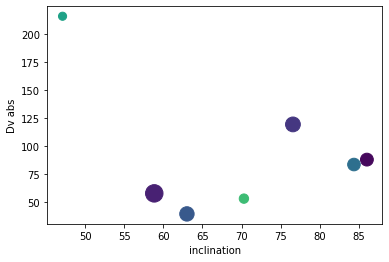

In [131]:
plt.scatter(winds_abs["inclination"], winds_abs["vel_absorption_dist"]/1e3, \
            c = winds_abs["B_KPC"], vmin = 10, vmax = 100, s = winds_abs["REW_2796"]*100+50)
plt.xlabel("inclination")
plt.ylabel("Dv abs")

Text(0, 0.5, 'Dv abs')

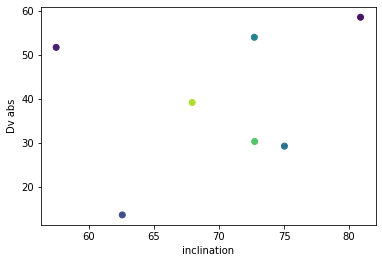

In [132]:
plt.scatter(accretions_abs["inclination"], accretions_abs["vel_absorption_dist"]/1e3, \
           c = accretions_abs["B_KPC"], vmin = 10, vmax = 100)
plt.xlabel("inclination")
plt.ylabel("Dv abs")

In [62]:
isol_good_runs_multinest = isol_good_runs.copy()

Is there a relation between the distance and the Dv at which is the absorption??

Text(0, 0.5, 'abs Dv')

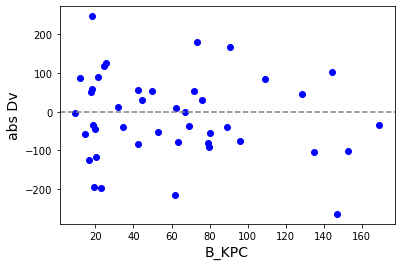

In [63]:
plt.scatter(isol_9_abs["B_KPC"], \
            const.c.value*(isol_9_abs["z_absorption"] - isol_9_abs["Z"])/(1+isol_9_abs["Z"])/1e3, c = "blue")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("abs Dv", size = 14)

Text(0, 0.5, 'abs Dv')

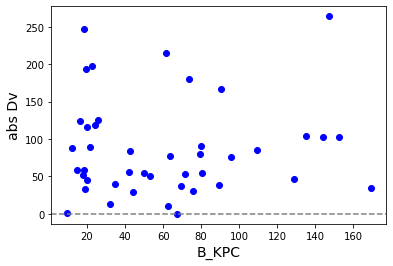

In [64]:
plt.scatter(isol_9_abs["B_KPC"], \
            isol_9_abs["vel_absorption_dist"]/1e3, c = "blue")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("abs Dv", size = 14)

Text(0, 0.5, 'abs Dv')

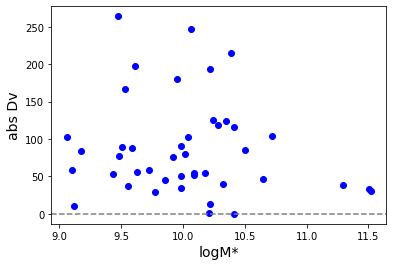

In [65]:
plt.scatter(isol_9_abs["sed_logMass"], \
            isol_9_abs["vel_absorption_dist"]/1e3, c = "blue")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("logM*", size = 14)
plt.ylabel("abs Dv", size = 14)

Text(0, 0.5, 'abs Dv')

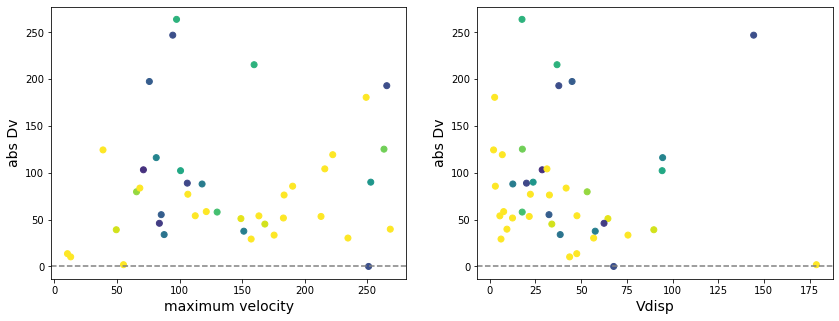

In [66]:
plt.figure(figsize = (14,5))
plt.subplot(121)
plt.scatter(isol_9_abs["maximum_velocity"], \
            isol_9_abs["vel_absorption_dist"]/1e3, c = isol_9_abs["snr_eff"], vmin = 0, vmax = 8)
#plt.plot([50, 250], [50, 250], c = "r", linestyle = "-.")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("maximum velocity", size = 14)
plt.ylabel("abs Dv", size = 14)

plt.subplot(122)
plt.scatter(isol_9_abs["velocity_dispersion"], \
            isol_9_abs["vel_absorption_dist"]/1e3, c = isol_9_abs["snr_eff"], vmin = 0, vmax = 8)
#plt.plot([50, 250], [50, 250], c = "r", linestyle = "-.")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("Vdisp", size = 14)
plt.ylabel("abs Dv", size = 14)

Text(0, 0.5, 'abs Dv')

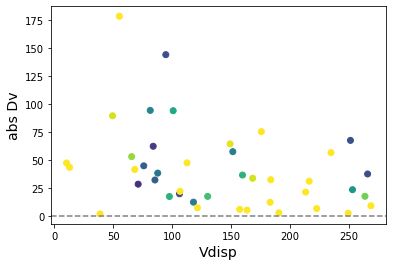

In [67]:
plt.scatter(isol_9_abs["maximum_velocity"], \
            isol_9_abs["velocity_dispersion"], c = isol_9_abs["snr_eff"], vmin = 0, vmax = 8)
#plt.plot([50, 250], [50, 250], c = "r", linestyle = "-.")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("Vdisp", size = 14)
plt.ylabel("abs Dv", size = 14)

# Investigations on low mass galaxies

In [69]:
R_lowz['sed_logMass'] = R['sed_logMass'].fillna(6)

In [70]:
R_lowz = isolated_auto_modif3(R_lowz, Mh = 1e12, b_sep = 20, dv = 0.5e6, group_threshold = 4, logm_sat = 0)

In [71]:
R = R_lowz.copy()
print(len(R))

1262


There is one absorption associated with 2 isolated galaxies (which is problematic!) due to the fact that the Dv used for isolation is equal to the one for abs-gal association (it should be the double to be rigorous but we would then remove too many galaxies). The abs 128 is associated with 2 galaxies, but one is closer in B, in dv and is heavier so we consider that the other one is not associated with the absorption 

In [72]:
R.loc[R["ID"] == 14113, "bool_absorption"] = 0
R.loc[R["ID"] == 14113, "REW_2796"] = 0

In [73]:
f2 = R["N100_neighb"]<= 1
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
f4 = R["REW_2796"]>=0.3
f5 = R["REW_2796"]>=0.01
f6 = R["inclination_convergence"] == 1
f7 = R["pa_convergence"] == 1
f8 = R["snr_eff"]>=3
f9 = R["snr_eff"]>=10
f10 = R["inclination"] >= 40 
f11 = R["inclination"] >= 60
f12 = R["N100_abs"] == 1
f13 = R["N100_abs"] <= 2
f14 = R["bool_absorption"] == 1
f15 = R["N100_neighb"]<= 1
f16 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 3000 #from Zabl 2019
f16b = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 1500 #from Zabl 2019
f17 = R["N50_neighb"]== 0
f18 = R["N50_neighb"]<= 1
f19 = R["alpha"] <= 40
f20 = R["is_QSO"] == 0
f21 = R["N2000_abs"] <= 4
f22 = R["is_closest"] == 1
f23 = R["B_KPC_NEIGHB"] >= 30
f24 = R["Z"] < 2
fzlow = R["Z"] > 0.4
fzhigh = R["Z"] < 1.5
fzconf_1 = R["ZCONF"] > 1
f25 = R["N2000_LOS"] <= 4
f26 = R["is_star"] == 0
f27_1 = R["alpha"] <= 33
f27_2 = (R["alpha"] >= 33) & (R["alpha"] <= 66)
f27_3 = R["alpha"] >= 66
f28 = R["inclination"] >= 35
#f29 = R["current"] == 1
f30 = R["isolated_auto"] == 1
f31 = R["primary_auto"] == 1
#f32 = R["galpak_score"] != 0
f33 = R["score_auto"] >= 1
f34 = R["score_auto"] >= 2
f35 = R["score_auto"] >= 3
f36 = R["sed_logMass"] >= 9
#f37 = R["run_convergence_global"] >= 0.99
f38 = R["ID"].isin(bad_runs_ids)
f39 = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
f40 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 300
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)

In [74]:
prim = R[f20 & f31]
R_9 = R[f20 & f100 & fzlow & fzhigh & fzconf_1 & fbehind & f36]
R100 = R[f20 & fzlow & fzhigh & fbehind & f100] 
R150 = R[f20 & fzlow & fzhigh & fbehind & f150]
R200 = R[f20 & fzlow & fzhigh & fbehind & f200]

isol = R[f20 & f30 & fbehind] #isolated galaxies
isol_abs = R[f20 & f30 & f14 & fbehind]
isol_noabs = R[f20 & f30 & ~f14 & fbehind]
isol_zconf = R[f20 & f30 & fzconf_1 & fbehind]
isol_zconf_abs = R[f20 & f30 & fzconf_1 & f14 & fbehind]
isol_zconf_noabs = R[f20 & f30 & fzconf_1 & ~f14 & fbehind]
isol_zselec = R[f20 &f30 & fzlow & fzhigh & fbehind] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[f20 & f30 & fzconf_1 & fzlow & fzhigh & fbehind & ~f39] 
isol_zselec_nomass = R[f20 & f30 & fzconf_1 & fzlow & fzhigh & fbehind & f39]
isol_zconf_1 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & ~f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_no9 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_no9_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_no9_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & ~f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9

isol_lowM = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f14 & fbehind]
isol_lowM_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & ~f14 & fbehind]
isol_9_convergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & fbehind] # idem with good convergence
isol_9_noconvergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & ~f37 & fbehind] # idem with good convergence
isol_lowM_convergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f37 & fbehind]
isol_snr3 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & fbehind] # idem with good snr
isol_lowM_snr3 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f37 & f8 & fbehind]
isol_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & fbehind] # good runs
isol_notgood_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f38 & fbehind]
isol_good_runs_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & f14 & fbehind] # good runs
isol_good_runs_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & ~f14 & fbehind] # good runs
isol_incl_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind] # good runs
isol_incl_good_runs_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & f14 & fbehind] # good runs
isol_incl_good_runs_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & ~f14 & fbehind] # good runs

isol_high_alpha = R[f20 & f10 & f27_3 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]
isol_mid_alpha = R[f20 & f10 & f27_2 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]
isol_low_alpha = R[f20 & f10 & f27_1 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]

print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of primaries = ", len(prim))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and good convergence and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good galpak runs and incl>40 = ", len(isol_incl_good_runs))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of primaries =  191
Number of isolated =  294
Number of isolated with abs =  35
Number of distinct absorptions associated with isolated  =  34
Number of isolated with zconf >= 2  233
Number of isolated at 0.4 < z < 1.5 =  215
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  172
and with mass =  172
or without mass =  0
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  87
Number of isolated with logM > 9 and multinest run =  85
Number of isolated with logM > 9 with abs =  27
Number of isolated with logM > 9 without abs =  60
Number of isolated with logM > 9 and good convergence =  85
Number of isolated with logM > 9 and good convergence and snr_eff > 3  =  64
Number of isolated with logM > 9 and good galpak runs  =  57
Number of isolated with logM > 9 and good galpak runs and incl>40 =  39


      field_id     ID        Z  ZCONF  sed_logMass  B_KPC  REW_2796
47  J0014m0028  11053  0.65901      1          NaN  74.58     2.286
65  J0014m0028  11083  0.65600      2      9.52899  90.61     2.286


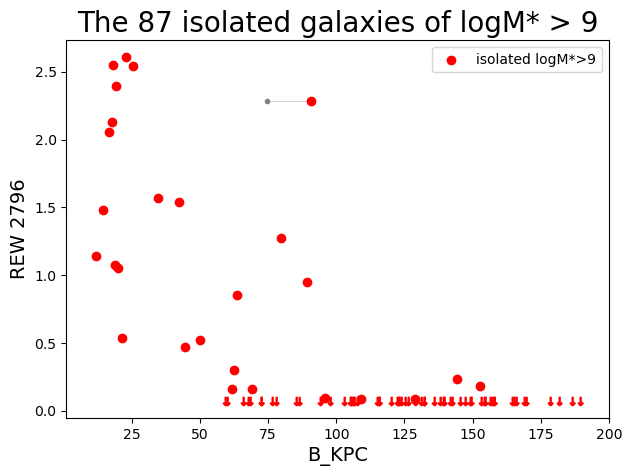

In [75]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    if len(K) > 1:
        print(K[["field_id", "ID", "Z", "ZCONF", "sed_logMass", "B_KPC", "REW_2796"]])
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

In [76]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_no9)) + " isolated galaxies of logM* < 9", size = 20)

dv = 0.5e6
for i, g in isol_no9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    #k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_no9_abs["B_KPC"], isol_no9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(isol_no9_noabs["B_KPC"], isol_no9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((0, 250))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
#plt.legend()

Text(0, 0.5, 'REW 2796')

# Random Forest = what are the determining parameters??

In [877]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Johannes did the job with the following parameters: ['Z', 'B_KPC', 'sed_logMass', 'max_mass_win', 'n_gal_win', 'logOIIsfr', 'max_logOIIsfr_win', 'logOIIssfr', 'max_logOIIssfr_win']

The parameters that could have an impact according to me are:
- Z
- B kpc
- sed_logMass
- max_mass_win
- N_gal_win (in isolation radius)
- logSFR
- max_logSFR_win
- logSSFR
- max_logSSFR
- alpha
- mass_closest_gal_win

We now have to build these parameters

In [878]:
R = pd.read_csv("results_6_conservative.csv")

R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/R["sed_logMass"])
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-5)

R["orientation"] = 1 #an alternative method is to use a flag. 0 = accretion, 1 = middle, 2 = wind.
R.loc[R["alpha"] < 20, "orientation"] = 0
R.loc[R["alpha"] > 70, "orientation"] = 2

In [879]:
fzlow_04 = R["Z"] > 0.4
fzlow_05 = R["Z"] > 0.5
fzhigh_15 = R["Z"] < 1.5
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fnoQSO = R["is_QSO"] == 0
fnostar = R["is_star"] == 0
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
f150 = R["B_KPC"] < 150
fsnr3 = R["snr_eff"] >= 3
fmultin = R["run_name"] == "run_OII_multinest"
fincl = R["inclination"] >= 35


In [880]:
R_goodz = R[fzlow_05 & fzhigh_15 & fzconf_0 & fnoQSO & fnostar & fbehind]
R_all150 = R[fzlow_05 & fzhigh_15 & fzconf_0 & fnoQSO & fnostar & fbehind & f150]
R_150_multin = R[fzlow_05 & fzhigh_15 & fzconf_0 & fnoQSO & fnostar & fbehind & f150 & fmultin]
R_150_snr3 = R[fzlow_05 & fzhigh_15 & fzconf_0 & fnoQSO & fnostar & fbehind & f150 & fmultin & fsnr3 & fincl]

print("Number of galaxies at z below 1.5 = ", len(R_goodz))
print("Number of galaxies at z below 1.5 in 150 kpc = ", len(R_all150))
print("Number of galaxies at z below 1.5 in 150 kpc and with multinest runs = ", len(R_150_multin))
print("Number of galaxies at z below 1.5 in 150 kpc and with multinest runs and snr>= 3 = ", len(R_150_snr3))

Number of galaxies at z below 1.5 =  972
Number of galaxies at z below 1.5 in 150 kpc =  378
Number of galaxies at z below 1.5 in 150 kpc and with multinest runs =  353
Number of galaxies at z below 1.5 in 150 kpc and with multinest runs and snr>= 3 =  173


For the "window" parameter we use the full catalog in order to keep any potential neihbour rather than just neighbour from the same sample (for ex with logM above 9)

In [881]:
def build_RF_param(df, Rall, Mh = 1e12, dv = 0.5e6):
    R = df.copy()
    Nlos = []
    isol_dist = []
    Rfov = []
    max_mass_win = []
    n_gal_win = []
    max_logSFR_win = []
    max_logSSFR_win = []
    B_heaviest = []
    B_closest = []
    mass_closest = []
    orientation_closest = []
    #print(len(Rall[Rall["sed_logMass"].isna()]))
    
    for i, r in R.iterrows():
        b_max = gt.get_Rvir(Mh, r["Z"]).value
        
        # we then compute the number of neighbours within B + b_sep kpc:
        f1 = np.abs(Rall["Z"] - r["Z"])*const.c.value/(1+r["Z"])<dv
        f2 = Rall["field_id"] == r["field_id"]
        f4 = Rall["B_KPC"] <= b_max
        #Fbmax = Rall[f1 & f2 & f4]
        Fbmax = Rall[f1 & f2]
        smallest_b = np.min(Fbmax["B_KPC"])
        max_mass = np.max(Fbmax["sed_logMass"])
        heaviest = Fbmax[Fbmax["sed_logMass"] == max_mass]
        closest_gal = Fbmax[Fbmax["B_KPC"] == smallest_b]
        #print(np.max(Fbmax["sed_logMass"]))
        
        max_mass_win.append(np.max(Fbmax["sed_logMass"]))
        n_gal_win.append(len(Fbmax["sed_logMass"]))
        max_logSFR_win.append(np.max(Fbmax["logSFR"]))
        max_logSSFR_win.append(np.max(Fbmax["logSSFR"]))
        mass_closest.append(np.max(closest_gal["sed_logMass"]))
        orientation_closest.append(np.max(closest_gal["orientation"]))
        B_closest.append(smallest_b)
        B_heaviest.append(heaviest.iloc[0]["B_KPC"])

        
    
    ISOL_DIST = np.array(isol_dist)
    RFOV = np.array(Rfov)

    R["max_mass_win"] = np.array(max_mass_win)
    R["n_gal_win"] = np.array(n_gal_win)
    R["max_logSFR_win"] = np.array(max_logSFR_win)
    R["max_logSSFR_win"] = np.array(max_logSSFR_win)
    R["B_closest"] = np.array(B_closest)
    R["B_heaviest"] = np.array(B_heaviest)
    R["mass_closest"] = np.array(mass_closest)
    R["orientation_closest"] = np.array(orientation_closest)
    return R

In [882]:
R_RF = build_RF_param(R_goodz, R, Mh = 1e12, dv = 0.5e6)
R_150_RF = build_RF_param(R_all150, R, Mh = 1e12, dv = 0.5e6)
R_150_snr3_RF = build_RF_param(R_150_snr3, R, Mh = 1e12, dv = 0.5e6)

In [883]:
R_RF_X = R_RF[["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "n_gal_win", "max_mass_win", "max_logSFR_win", \
             "max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest"]]
R_RF_Y = R_RF[["bool_absorption"]]

R_150_RF_X = R_150_RF[["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "n_gal_win", "max_mass_win", "max_logSFR_win", \
             "max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest"]]
R_150_RF_Y = R_150_RF[["bool_absorption"]]

R_150_snr3_RF_X = R_150_snr3_RF[["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "orientation", \
            "n_gal_win", "max_mass_win", "max_logSFR_win", \
             "max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest", "orientation_closest"]]
R_150_snr3_RF_Y = R_150_snr3_RF[["bool_absorption"]]

In [1455]:
R_RF_X.dtypes

[autoreload of galpak_tools failed: Traceback (most recent call last):
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/cherrey/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/home/cherrey/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/muse/MG2QSO/private/analysis/galpak_dr2/galpak_tools.py", line 2529
    - B closest
        ^
SyntaxError: invalid syntax
]


Z                  float64
B_KPC              float64
sed_logMass        float64
logSFR             float64
logSSFR            float64
alpha              float64
Rvir               float64
n_gal_win            int64
max_mass_win       float64
max_logSFR_win     float64
max_logSSFR_win    float64
B_heaviest         float64
dtype: object

In [884]:
RF = RandomForestClassifier(n_estimators=500)
RF.fit(R_RF_X, R_RF_Y)

RF_150 = RandomForestClassifier(n_estimators=500)
RF_150.fit(R_150_RF_X, R_150_RF_Y)

RF_150_snr3 = RandomForestClassifier(n_estimators=500)
RF_150_snr3.fit(R_150_snr3_RF_X, R_150_snr3_RF_Y)

/tmp/ipykernel_3292137/2898498947.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(R_RF_X, R_RF_Y)
/tmp/ipykernel_3292137/2898498947.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_150.fit(R_150_RF_X, R_150_RF_Y)
/tmp/ipykernel_3292137/2898498947.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_150_snr3.fit(R_150_snr3_RF_X, R_150_snr3_RF_Y)


RandomForestClassifier(n_estimators=500)

In [885]:
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF))+" galaxies in 0.5 < z < 1.5", size = 18)
plt.bar(range(len(R_RF_X.columns)), RF.feature_importances_, tick_label = R_RF_X.columns)
plt.ylabel("feature importance", size = 14)

Text(0, 0.5, 'feature importance')

In [886]:
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_150_RF))+" galaxies in 0.5 < z < 1.5 and 150 kpc", size = 18)
plt.bar(range(len(R_150_RF_X.columns)), RF_150.feature_importances_, tick_label = R_150_RF_X.columns)
plt.ylabel("feature importance", size = 14)

Text(0, 0.5, 'feature importance')

Text(0, 0.5, 'feature importance')

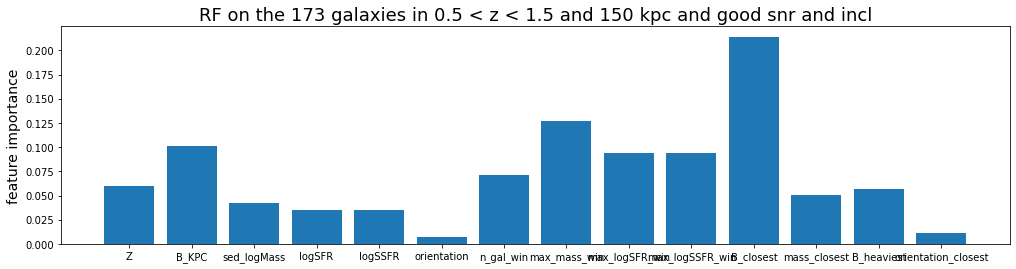

In [887]:
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_150_snr3_RF))+" galaxies in 0.5 < z < 1.5 and 150 kpc and good snr and incl", size = 18)
plt.bar(range(len(R_150_snr3_RF_X.columns)), RF_150_snr3.feature_importances_, tick_label = R_150_snr3_RF_X.columns)
plt.ylabel("feature importance", size = 14)

### For isolated galaxies

In [888]:
isol_9['sed_logMass'] = isol_9['sed_logMass'].fillna(6)
isol_9.loc[isol_9['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
isol_9["logSFR"] = np.log10(isol_9["SFR_gilbank"])
isol_9["logSSFR"] = np.log10(isol_9["SFR_gilbank"]/isol_9["sed_logMass"])
isol_9['logSFR'] = isol_9['logSFR'].fillna(-2)
isol_9['logSSFR'] = isol_9['logSSFR'].fillna(-5)

In [889]:
R_RF2 = build_RF_param(isol_9, R, Mh = 1e12, dv = 0.5e6)
print(len(R_RF2))
R_RF2_X = R_RF2[["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "n_gal_win", "max_mass_win", "max_logSFR_win", \
             "max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest"]]
R_RF2_Y = R_RF2[["bool_absorption"]]

121


In [890]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(R_RF2_X, R_RF2_Y)

/tmp/ipykernel_3292137/2846893727.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(R_RF2_X, R_RF2_Y)


RandomForestClassifier(n_estimators=500)

Text(0, 0.5, 'feature importance')

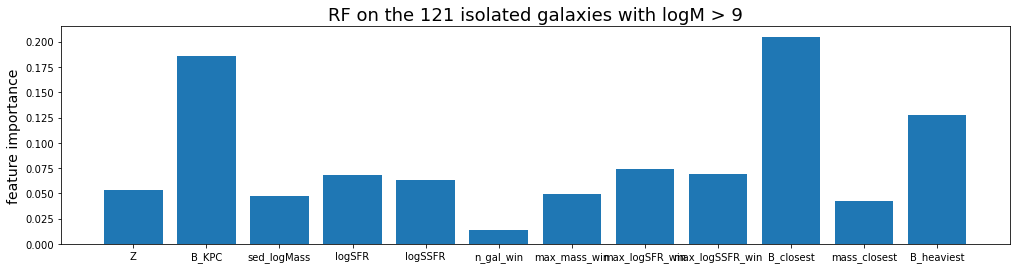

In [891]:
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF2))+" isolated galaxies with logM > 9", size = 18)
plt.bar(range(len(R_RF2_X.columns)), random_forest.feature_importances_, tick_label = R_RF2_X.columns)
plt.ylabel("feature importance", size = 14)

### For isolated galaxies with good incl and alpha

In [895]:
isol_incl_good_runs['sed_logMass'] = isol_incl_good_runs['sed_logMass'].fillna(6)
isol_incl_good_runs.loc[isol_incl_good_runs['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
isol_incl_good_runs["logSFR"] = np.log10(isol_incl_good_runs["SFR_gilbank"])
isol_incl_good_runs["logSSFR"] = np.log10(isol_incl_good_runs["SFR_gilbank"]/isol_incl_good_runs["sed_logMass"])
isol_incl_good_runs['logSFR'] = isol_incl_good_runs['logSFR'].fillna(-2)
isol_incl_good_runs['logSSFR'] = isol_incl_good_runs['logSSFR'].fillna(-5)

In [896]:
R_RF3 = build_RF_param(isol_incl_good_runs, R, Mh = 1e12, dv = 0.5e6)

print(len(R_RF3))

R_RF3_X = R_RF3[["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "n_gal_win", "max_mass_win", "max_logSFR_win", \
             "max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest"]]
R_RF3_Y = R_RF3[["bool_absorption"]]

58


In [897]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(R_RF3_X, R_RF3_Y)

/tmp/ipykernel_3292137/3718472198.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(R_RF3_X, R_RF3_Y)


RandomForestClassifier(n_estimators=500)

/tmp/ipykernel_3292137/1527700499.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(R_RF3_X, R_RF3_Y)


Text(0, 0.5, 'feature importance')

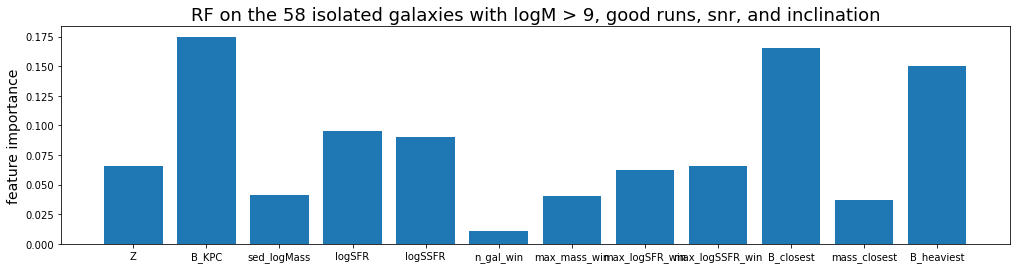

In [898]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(R_RF3_X, R_RF3_Y)
#print(R_RF3_X.columns)
#print(random_forest.feature_importances_)
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF3))+" isolated galaxies with logM > 9, good runs, snr, and inclination", size = 18)
plt.bar(range(len(R_RF3_X.columns)), random_forest.feature_importances_, tick_label = R_RF3_X.columns)
plt.ylabel("feature importance", size = 14)

So we obtain similar results. Now if we add the alpha parameter:

In [899]:
def f(x):
    return -np.abs(x - 45) + 45

In [904]:
R_RF3["alpha_modif"] = f(R_RF3["alpha"]) # get the alpha in 0 - 45. If alpha = 90 it goes to 0, if 65 it goes to 25.

R_RF3["orientation"] = 1 #an alternative method is to use a flag. 0 = accretion, 1 = middle, 2 = wind.
R_RF3.loc[R_RF3["alpha"] < 30, "orientation"] = 0
R_RF3.loc[R_RF3["alpha"] > 60, "orientation"] = 2

R_RF3_X = R_RF3[["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "alpha", "n_gal_win", "max_mass_win", \
                 "max_logSFR_win","max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest"]]
R_RF3_Y = R_RF3[["bool_absorption"]]

In [905]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(R_RF3_X, R_RF3_Y)
#print(R_RF3_X.columns)
#print(random_forest.feature_importances_)
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF3))+" isolated galaxies with logM > 9, good runs, snr, and inclination", size = 18)
plt.bar(range(len(R_RF3_X.columns)), random_forest.feature_importances_, tick_label = R_RF3_X.columns)
plt.ylabel("feature importance", size = 14)

/tmp/ipykernel_3292137/1527700499.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(R_RF3_X, R_RF3_Y)


Text(0, 0.5, 'feature importance')

So with that test we obtain that alpha is of very low importance. Lower than Z, SFR or the mass of the closest galaxy.

In [101]:
estimator = random_forest.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot',
                feature_names = ["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "alpha", "n_gal_win", "max_mass_win", \
                 "max_logSFR_win","max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
    
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Non isolated galaxies

Here we try to have a similar rigorous approach but for the cases where we have more galaxies in the FOV (up to 5) of logM above 9. This is tricky, specially to take into account satellites etc.

In [102]:
def isolated_auto_modif4(df, Mh = 1e12, b_sep = 30, dv = 1e6, group_threshold = 4, logm_sat = 9):
    R = df.copy()
    Nlos = []
    isol_dist = []
    Rfov = []
    
    for i, r in R.iterrows():
        p = 0
        b_max = gt.get_Rvir(Mh, r["Z"]).value
        
        # a galaxy can be primary only if within 100kpc
        if (r["sed_logMass"] > logm_sat) and (r["B_KPC"] < b_max) and (r["is_QSO"] == 0) and \
        (r["is_star"] == 0) and (r["Z"]< 1.5):
            # we then compute the number of neighbours within B + b_sep kpc:
            f1 = np.abs(R["Z"] - r["Z"])*const.c.value/(1+r["Z"])<dv
            f2 = R["field_id"] == r["field_id"]
            f3 = R["B_KPC"] <= r["B_KPC"] + b_sep
            f4 = R["B_KPC"] <= b_max
            f5 = R["sed_logMass"] > logm_sat
            Fbmax = R[f1 & f2 & f4 & f5]
            Fbsep = R[f1 & f2 & f3 & f5]
            
            # We don't consider galaxies in groups as primary:
            #if r["N2000_LOS"] <= group_threshold:
                # to be primary, the galaxy must alone.. 
            p = len(Fbmax)
            
        Nlos.append(p)
        isol_dist.append(b_max)
        Rfov.append((cosmo.kpc_proper_per_arcmin(r["Z"])/2).value)
        
    NLOS = np.array(Nlos)
    ISOL_DIST = np.array(isol_dist)
    RFOV = np.array(Rfov)

    R["Nlos"] = NLOS
    R["isolation_dist"] = ISOL_DIST
    R["Rfov"] = RFOV
    return R

In [103]:
R_lowz = R_lowz[R_lowz["ZCONF"]>1]

In [104]:
R_lowz = isolated_auto_modif4(R_lowz, Mh = 1e12, b_sep = 20, dv = 0.5e6, group_threshold = 10, logm_sat = 9)

In [105]:
R = R_lowz.copy()
print(len(R))

1073


In [106]:
f2 = R["N100_neighb"]<= 1
f3 = R["B_KPC"] <= 100
f4 = R["REW_2796"]>=0.3
f5 = R["REW_2796"]>=0.01
f6 = R["inclination_convergence"] == 1
f7 = R["pa_convergence"] == 1
f8 = R["snr_eff"]>=3
f9 = R["snr_eff"]>=10
f10 = R["inclination"] >= 40 
f11 = R["inclination"] >= 60
f12 = R["N100_abs"] == 1
f13 = R["N100_abs"] <= 2
f14 = R["bool_absorption"] == 1
f15 = R["N100_neighb"]<= 1
f16 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 3000 #from Zabl 2019
f16b = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 1500 #from Zabl 2019
f17 = R["N50_neighb"]== 0
f18 = R["N50_neighb"]<= 1
f19 = R["alpha"] <= 40
f20 = R["is_QSO"] == 0
f21 = R["N2000_abs"] <= 4
f22 = R["is_closest"] == 1
f23 = R["B_KPC_NEIGHB"] >= 30
f24 = R["Z"] < 2
fzlow = R["Z"] > 0.4
fzhigh = R["Z"] < 1.5
fzconf_1 = R["ZCONF"] > 1
f25 = R["N2000_LOS"] <= 4
f26 = R["is_star"] == 0
f27_1 = R["alpha"] <= 33
f27_2 = (R["alpha"] >= 33) & (R["alpha"] <= 66)
f27_3 = R["alpha"] >= 66
f28 = R["inclination"] >= 35
#f29 = R["current"] == 1
f30 = R["isolated_auto"] == 1
f31 = R["primary_auto"] == 1
#f32 = R["galpak_score"] != 0
f33 = R["score_auto"] >= 1
f34 = R["score_auto"] >= 2
f35 = R["score_auto"] >= 3
f36 = R["sed_logMass"] >= 9
f37 = R["run_convergence_global"] >= 0.99
f38 = R["ID"].isin(bad_runs_ids)
f39 = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
f40 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 300
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
f41 = R["Nlos"] > 0
f42 = R["Nlos"] == 1
f43 = R["Nlos"] == 2
f44 = R["Nlos"] == 3
f45 = R["Nlos"] == 4
f46 = R["Nlos"] == 5
f47 = R["Nlos"] == 6

In [107]:
in_isol = R[f20 & f41 & fbehind]
in_isol_zconf = R[f20 & f41 & fzconf_1 & fbehind]
in_isol_zconf_abs = R[f20 & f41 & fzconf_1 & f14 & fbehind]
in_isol_zconf_noabs = R[f20 & f41 & fzconf_1 & ~f14 & fbehind]
in_isol_zselec = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind]
in_isol_zselec_abs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & f14 & fbehind]
in_isol_zselec_noabs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & ~f14 & fbehind]
isol_1 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f42]
isol_1_abs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f42 & f14]
isol_1_noabs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f42 & ~f14]
isol_2 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f43]
isol_2_abs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f43 & f14]
isol_2_noabs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f43 & ~f14]
isol_3 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f44]
isol_3_abs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f44 & f14]
isol_3_noabs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f44 & ~f14]
isol_4 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f45]
isol_5 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f46]
isol_6 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f47]



print("Number of galaxies in Rvir12 = ", len(in_isol))
print("Number of galaxies in Rvir12 and zconf = 2+ = ", len(in_isol_zconf))
print("Number of galaxies in Rvir12 and zconf = 2+ with abs  = ", len(in_isol_zconf_abs))
print("Number of galaxies in Rvir12 in 0.4 < z < 1.5 = ", len(in_isol_zselec))
print("Number of isolated galaxies in Rvir12 in 0.4 < z < 1.5 = ", len(isol_1))


Number of galaxies in Rvir12 =  291
Number of galaxies in Rvir12 and zconf = 2+ =  291
Number of galaxies in Rvir12 and zconf = 2+ with abs  =  154
Number of galaxies in Rvir12 in 0.4 < z < 1.5 =  263
Number of isolated galaxies in Rvir12 in 0.4 < z < 1.5 =  128


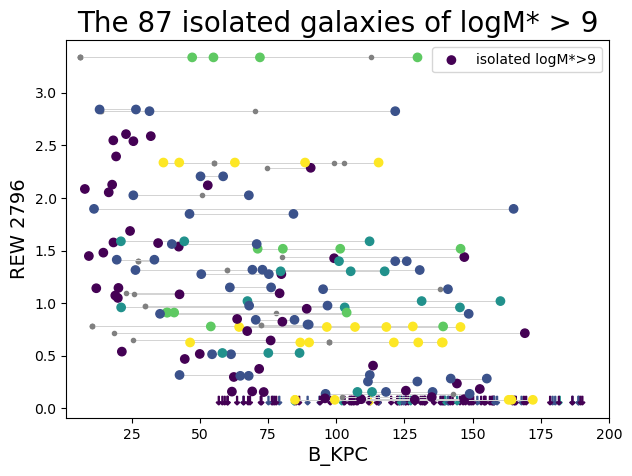

In [108]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in in_isol_zselec_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(in_isol_zselec_abs["B_KPC"], in_isol_zselec_abs["REW_2796"], c = in_isol_zselec_abs["Nlos"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

plt.scatter(in_isol_zselec_noabs["B_KPC"], in_isol_zselec_noabs["detection_limit_p75"], \
            c = in_isol_zselec_noabs["Nlos"], marker = "$\downarrow$", vmin = 1, vmax = 5)
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

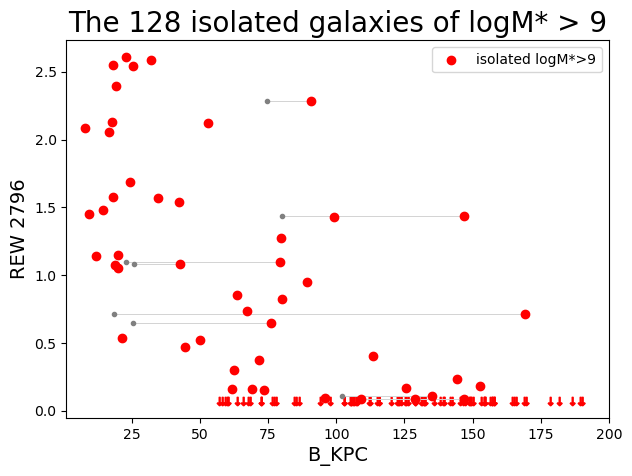

In [109]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_1)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_1.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_1_abs["B_KPC"], isol_1_abs["REW_2796"], c = "r",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

plt.scatter(isol_1_noabs["B_KPC"], isol_1_noabs["detection_limit_p75"], \
            c = "r", marker = "$\downarrow$", vmin = 1, vmax = 5)
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

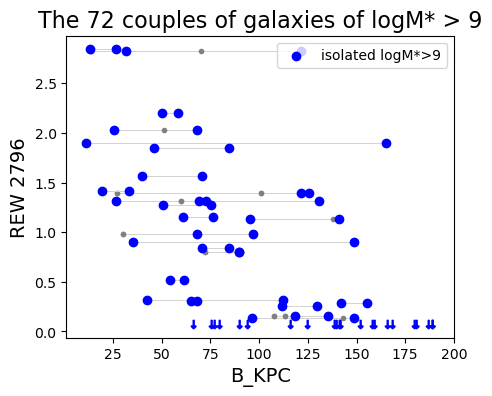

In [110]:
plt.figure(dpi = 100, figsize = (5, 4))
plt.title("The " + str(len(isol_2)) + " couples of galaxies of logM* > 9", size = 16)

dv = 0.5e6
for i, g in isol_2.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_2_abs["B_KPC"], isol_2_abs["REW_2796"], c = "b",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

plt.scatter(isol_2_noabs["B_KPC"], isol_2_noabs["detection_limit_p75"], \
            c = "b", marker = "$\downarrow$", vmin = 1, vmax = 5)
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

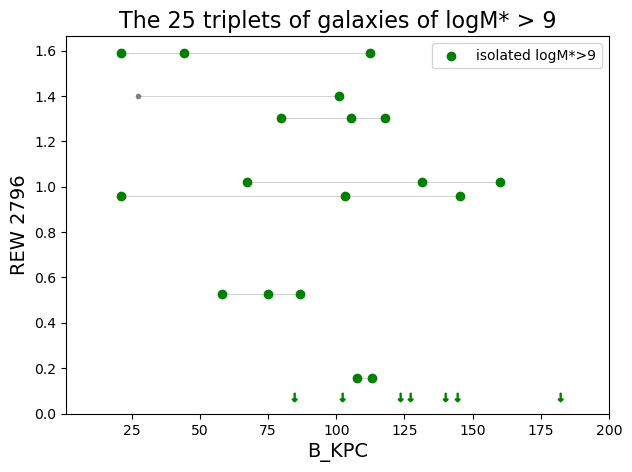

In [111]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_3)) + " triplets of galaxies of logM* > 9", size = 16)

dv = 0.5e6
for i, g in isol_3.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_3_abs["B_KPC"], isol_3_abs["REW_2796"], c = "g",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

plt.scatter(isol_3_noabs["B_KPC"], isol_3_noabs["detection_limit_p75"], \
            c = "g", marker = "$\downarrow$", vmin = 1, vmax = 5)
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

In [112]:
isol_3_abs[["field_id", "ID", "Z", "B_KPC", "ZCONF", "isolation_dist", "Nlos", "abs_id", "REW_2796"]]

field_id     ID        Z   B_KPC  ZCONF  isolation_dist  Nlos  abs_id  \
693   J0134p0051  17086  0.40274  107.76      3      208.928832     3     141   
708   J0134p0051  17101  0.40075  113.11      3      209.157510     3     141   
793   J0800p1849  19005  0.84323  103.09      3      166.906915     3      29   
835   J0800p1849  19073  0.84331   21.08      3      166.900631     3      29   
842   J0800p1849  19080  0.60688  160.21      3      187.460913     3      28   
855   J0800p1849  19093  0.60601  131.31      3      187.544533     3      28   
866   J0800p1849  19104  0.84295  145.36      3      166.928914     3      29   
867   J0800p1849  19105  0.60800   67.41      2      187.353357     3      28   
1214  J1107p1021  23112  1.29556   58.22      3      137.121196     3      50   
1217  J1107p1021  23115  1.29566   86.53      3      137.115698     3      50   
1220  J1107p1021  23118  1.29513   75.06      2      137.144843     3      50   
1286  J1107p1757  24035  1.16329  112.21      2      144.768108     3      46   
1292  J1107p1757  24041  1.16179   44.23      3      144.859321     3      46   
1296  J1107p1757  24045  1.16328   20.99      3      144.768716     3      46   
1528  J1352p0614  27049  1.13689  100.99      3      146.388996     3      84   
1833  J1509p1506  30082  0.97036  105.29      3      157.425579     3      82   
1852  J1509p1506  30101  0.97172  117.74      3      157.329379     3      82   
1861  J1509p1506  30110  0.97000   79.59      3      157.451061     3      82   

      REW_2796  
693      0.157  
708      0.157  
793      0.960  
835      0.960  
842      1.020  
855      1.020  
866      0.960  
867      1.020  
1214     0.527  
1217     0.527  
1220     0.527  
1286     1.588  
1292     1.588  
1296     1.588  
1528     1.399  
1833     1.303  
1852     1.303  
1861     1.303

In [113]:
f1 = np.abs(R["Z"] - 1.13689)*const.c.value/(1+1.13689) < 0.5e6
f2 = R["field_id"] == "J1352p0614"
f4 = R["B_KPC"] <= 146.4
f5 = R["sed_logMass"] > 9
KK = R[f1 & f2 & f4 & f5]

In [114]:
len(KK)

3

In [115]:
KK[["ID", "Z", "ZCONF", "sed_logMass", "B_KPC", "Nlos"]]

ID        Z  ZCONF  sed_logMass   B_KPC  Nlos
1524  27045  1.13582      3    10.027198  121.62     2
1528  27049  1.13689      3    11.773106  100.99     3
1538  27060  1.14022      3    10.611500  125.84     2

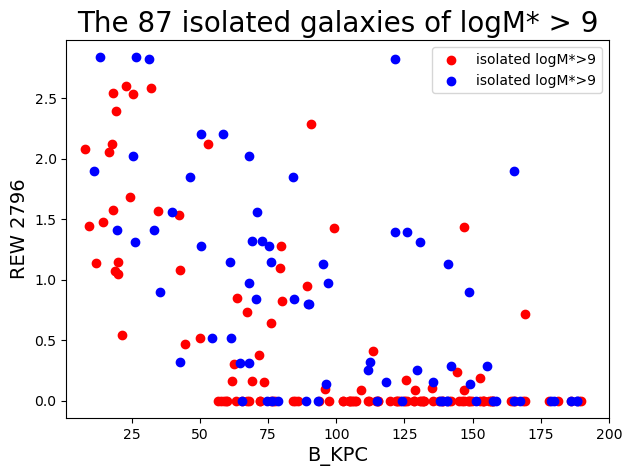

In [116]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(isol_1["B_KPC"], isol_1["REW_2796"], c = "r",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

plt.scatter(isol_2["B_KPC"], isol_2["REW_2796"], c = "b",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

#plt.scatter(isol_3["B_KPC"], isol_3["REW_2796"], c = "g",\
#                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)


#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

Text(0, 0.5, 'REW 2796')

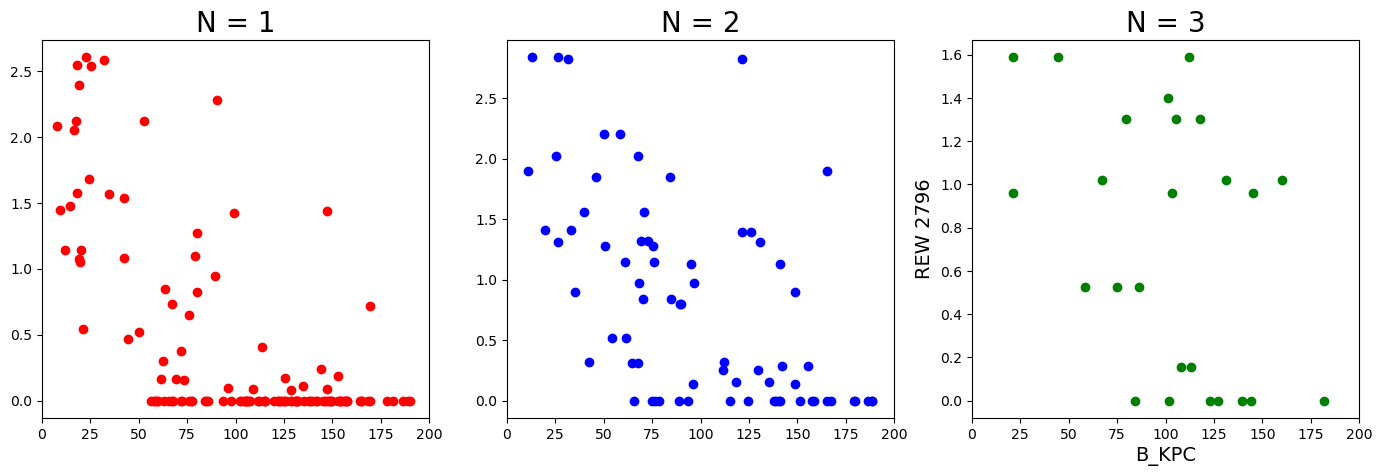

In [117]:
plt.figure(dpi = 100, figsize = (17, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
plt.subplot(131)
plt.title("N = 1", size = 20)
plt.scatter(isol_1["B_KPC"], isol_1["REW_2796"], c = "r",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))

plt.subplot(132)
plt.title("N = 2", size = 20)
plt.scatter(isol_2["B_KPC"], isol_2["REW_2796"], c = "b",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))

plt.subplot(133)
plt.title("N = 3", size = 20)
plt.scatter(isol_3["B_KPC"], isol_3["REW_2796"], c = "g",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))


#plt.colorbar(label = "N2000")

#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)

Text(0, 0.5, 'REW 2796')

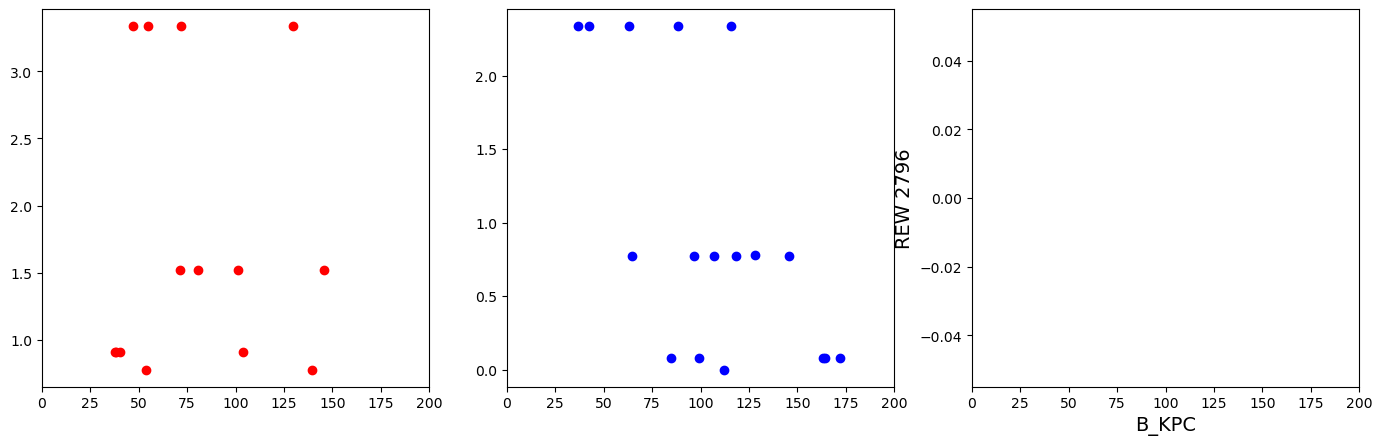

In [118]:
plt.figure(dpi = 100, figsize = (17, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
plt.subplot(131)
plt.scatter(isol_4["B_KPC"], isol_4["REW_2796"], c = "r",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))

plt.subplot(132)
plt.scatter(isol_5["B_KPC"], isol_5["REW_2796"], c = "b",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))

plt.subplot(133)
plt.scatter(isol_6["B_KPC"], isol_6["REW_2796"], c = "g",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))


#plt.colorbar(label = "N2000")

#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)

In [119]:
isol_3[["field_id", "ID", "Z", "B_KPC", "abs_id", "Nlos", "sed_logMass"]]

field_id     ID        Z   B_KPC  abs_id  Nlos  sed_logMass
693   J0134p0051  17086  0.40274  107.76     141     3     9.007995
708   J0134p0051  17101  0.40075  113.11     141     3    10.576167
793   J0800p1849  19005  0.84323  103.09      29     3     9.921810
835   J0800p1849  19073  0.84331   21.08      29     3     9.594076
842   J0800p1849  19080  0.60688  160.21      28     3     9.583120
855   J0800p1849  19093  0.60601  131.31      28     3    11.133873
866   J0800p1849  19104  0.84295  145.36      29     3     9.653000
867   J0800p1849  19105  0.60800   67.41      28     3    10.593911
1214  J1107p1021  23112  1.29556   58.22      50     3     9.056438
1217  J1107p1021  23115  1.29566   86.53      50     3     9.547503
1220  J1107p1021  23118  1.29513   75.06      50     3    10.157862
1286  J1107p1757  24035  1.16329  112.21      46     3    10.034609
1292  J1107p1757  24041  1.16179   44.23      46     3     9.633361
1296  J1107p1757  24045  1.16328   20.99      46     3    10.646333
1515  J1352p0614  27035  0.97572  139.58      84     3    10.648456
1528  J1352p0614  27049  1.13689  100.99      84     3    11.773106
1539  J1352p0614  27061  0.97661  126.84      84     3     9.463187
1540  J1352p0614  27062  0.60811  181.52      86     3     9.240011
1571  J1352p0614  27094  0.97622  101.57      84     3    10.986945
1801  J1509p1506  30044  0.54003  122.89      80     3     9.919818
1833  J1509p1506  30082  0.97036  105.29      82     3     9.804630
1844  J1509p1506  30093  0.54201   83.99      80     3    10.884262
1846  J1509p1506  30095  0.54065  143.89      80     3    10.758931
1852  J1509p1506  30101  0.97172  117.74      82     3    10.888730
1861  J1509p1506  30110  0.97000   79.59      82     3    10.217569

# Disk - halo decomposition

In [25]:
R = pd.read_csv("results_decomp_2.csv")

In [26]:
R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/R["sed_logMass"])
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-5)

R["orientation"] = 1 #an alternative method is to use a flag. 0 = accretion, 1 = middle, 2 = wind.
R.loc[R["alpha"] < 30, "orientation"] = 0
R.loc[R["alpha"] > 60, "orientation"] = 2

In [27]:
Q = R[R["run_name"] == "run_OII_decomp_logX"]
len(Q)

9

In [28]:
fzlow_04 = R["Z"] > 0.4
fzlow_05 = R["Z"] > 0.5
fzhigh_15 = R["Z"] < 1.5
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fnoQSO = R["is_QSO"] == 0
fnostar = R["is_star"] == 0

In [29]:
R_lowz = R[fzhigh_15 & fzconf_0 & fnoQSO & fnostar]
R_goodz_goodconf = R[fzlow_04 & fzhigh_15 & fzconf_1 & fnoQSO & fnostar]

print("Number of galaxies at z below 1.5 = ", len(R_lowz))
print("Number of galaxies at z below 1.5  and zconf= 2 or more = ", len(R_goodz_goodconf))

Number of galaxies at z below 1.5 =  1262
Number of galaxies at z below 1.5  and zconf= 2 or more =  960


In [30]:
R_lowz = gt.isolated_auto_modif3(R_lowz, Mh = 1e12, b_sep = 20, dv = 0.5e6, group_threshold = 4, logm_sat = 9)
R_lowz = gt.get_closest(R_lowz, dv = 0.5e6, group_threshold = 4, logm_sat = 0, ZCONF_lim = 1)

In [31]:
R = R_lowz.copy()
print(len(R))

1262


In [32]:
bad_runs_id = [11083, 12121, 23086, 23120, 26056, 26092, 29002, 29084, 28102, 30070, 30093, 31005]

- 17068 is suspect...
- 17078 must be rerun
- 20073 is quite bad even if snreff above 3
- 20074 is quite bad even if snreff above 3
- 20077 is quite bad even if snreff above 3
- 21107 no multinest? Rerun..
- 26092 no OII, no run
- 28102 no OII, no run
- 29002 mixed with QSO (bad cont or psf sub)
- 29084 other src nearby
- 30070 no OII (but snr = 10!)

In [33]:
R.loc[R["ID"] == 14113, "bool_absorption"] = 0
R.loc[R["ID"] == 14113, "REW_2796"] = 0

In [36]:
f2 = R["N100_neighb"]<= 1
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
f4 = R["REW_2796"]>=0.3
f5 = R["REW_2796"]>=0.01
f6 = R["inclination_convergence"] == 1
f7 = R["pa_convergence"] == 1
f8 = R["snr_eff"]>=3
f9 = R["snr_eff"]>=10
f10 = R["inclination"] >= 30 
f11 = R["inclination"] >= 60
f12 = R["N100_abs"] == 1
f13 = R["N100_abs"] <= 2
f14 = R["bool_absorption"] == 1
f15 = R["N100_neighb"]<= 1
f16 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 3000 #from Zabl 2019
f16b = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 1500 #from Zabl 2019
f17 = R["N50_neighb"]== 0
f18 = R["N50_neighb"]<= 1
f19 = R["alpha"] <= 40
f20 = R["is_QSO"] == 0
f21 = R["N2000_abs"] <= 4
f22 = R["is_closest"] == 1
f23 = R["B_KPC_NEIGHB"] >= 30
f24 = R["Z"] < 2
fzlow = R["Z"] > 0.4
fzhigh = R["Z"] < 1.5
fzconf_1 = R["ZCONF"] > 1
f25 = R["N2000_LOS"] <= 4
f26 = R["is_star"] == 0
f27_1 = R["alpha"] <= 33
f27_2 = (R["alpha"] >= 33) & (R["alpha"] <= 66)
f27_3 = R["alpha"] >= 66
f28 = R["inclination"] >= 35
#f29 = R["current"] == 1
f30 = R["isolated_auto"] == 1
f31 = R["primary_auto"] == 1
#f32 = R["galpak_score"] != 0
f33 = R["score_auto"] >= 1
f34 = R["score_auto"] >= 2
f35 = R["score_auto"] >= 3
f36 = R["sed_logMass"] >= 9
f37 = R["run_convergence_global"] >= 0.99
f38 = R["ID"].isin(bad_runs_ids)
f39 = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
f40 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 300
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
frot = (R["v22"]+0.01)/R["velocity_dispersion_2Re"] > 1

In [37]:
prim = R[f20 & f31]
R_9 = R[f20 & f100 & fzlow & fzhigh & fzconf_1 & fbehind & f36]
R100 = R[f20 & fzlow & fzhigh & fbehind & f100] 
R150 = R[f20 & fzlow & fzhigh & fbehind & f150]
R200 = R[f20 & fzlow & fzhigh & fbehind & f200]

isol = R[f20 & f30 & fbehind] #isolated galaxies
isol_abs = R[f20 & f30 & f14 & fbehind]
isol_noabs = R[f20 & f30 & ~f14 & fbehind]
isol_zconf = R[f20 & f30 & fzconf_1 & fbehind]
isol_zconf_abs = R[f20 & f30 & fzconf_1 & f14 & fbehind]
isol_zconf_noabs = R[f20 & f30 & fzconf_1 & ~f14 & fbehind]
isol_zselec = R[f20 &f30 & fzlow & fzhigh & fbehind] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[f20 & f30 & fzconf_1 & fzlow & fzhigh & fbehind & ~f39] 
isol_zselec_nomass = R[f20 & f30 & fzconf_1 & fzlow & fzhigh & fbehind & f39]
isol_zconf_1 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1

closest = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind]
closest_abs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f14]
closest_noabs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & ~f14]
closest_9 = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f36]
closest_9_abs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f14 & f36]
closest_9_noabs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & ~f14 & f36]
closest_9_snr3_good_runs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f36 & f8 & ~f38]
closest_9_snr3_good_runs_abs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & f14 & f36 & f8 & ~f38]
closest_9_snr3_good_runs_noabs = R[f20 & f22 & fzlow & fzhigh & fzconf_1 & fbehind & ~f14 & f36 & f8 & ~f38]

isol_9 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & ~f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f14 & fbehind]
isol_lowM_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & ~f14 & fbehind]
isol_9_convergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & fbehind] # idem with good convergence
isol_9_noconvergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & ~f37 & fbehind] # idem with good convergence
isol_lowM_convergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f37 & fbehind]
isol_snr3 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & fbehind] # idem with good snr
isol_snr3_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & fbehind & f14] # idem with good snr
isol_snr3_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & fbehind & ~f14] # idem with good snr

isol_lowM_snr3 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f37 & f8 & fbehind]
isol_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & ~f38 & fbehind] # good runs
isol_notgood_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f38 & fbehind]
isol_snr3_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & fbehind] # good runs
isol_snr3_notgood_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f38 & fbehind]
isol_snr3_good_runs_rot = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & fbehind & frot] # good runs
isol_snr3_good_runs_rot_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & f14 & fbehind & frot] # good runs
isol_snr3_good_runs_rot_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & ~f14 & fbehind & frot] # good runs

isol_snr3_good_runs_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & f14 & fbehind] # good runs
isol_snr3_good_runs_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & ~f14 & fbehind] # good runs

isol_incl_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind & frot] # good runs
isol_incl_good_runs_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & f14 & fbehind & frot] # good runs
isol_incl_good_runs_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & ~f14 & fbehind & frot] # good runs

isol_high_alpha = R[f20 & f10 & f27_3 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]
isol_mid_alpha = R[f20 & f10 & f27_2 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]
isol_low_alpha = R[f20 & f10 & f27_1 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]

print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of primaries = ", len(prim))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))

print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 ", len(closest))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9", len(closest_9))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and abs", len(closest_9_abs))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and good runs and snreff", len(closest_9_snr3_good_runs))

print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and good convergence and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_snr3_good_runs))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated  = ", len(isol_snr3_good_runs_rot))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated with abs = ", len(isol_snr3_good_runs_rot_abs))
print("Number of isolated with logM > 9 and good galpak runs, rot dominated without abs= ", len(isol_snr3_good_runs_rot_noabs))
print("Number of isolated with logM > 9 and good galpak runs and incl>40 = ", len(isol_incl_good_runs))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of primaries =  191
Number of isolated =  153
Number of isolated with abs =  43
Number of distinct absorptions associated with isolated  =  43
Number of isolated with zconf >= 2  139
Number of isolated at 0.4 < z < 1.5 =  132
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  120
Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2  449
Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 241
Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and abs 62
Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and good runs and snreff 94
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  120
Number of isolated with logM > 9 and multinest run =  0
Number of isolated with logM > 9 with abs =  42
Number of isolated with logM > 9 without abs =  78
Number of isolated with logM > 9 and good convergence =  11

In [38]:
xx = np.linspace(0.2, 1.5, 100)
yy = 3/xx
muse_sampling = 0.2
plt.figure(dpi = 100, figsize = (7,5))
plt.errorbar(np.array(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"]), np.array(isol_9["snr_max"]),\
            xerr = isol_9["radius_err"]*muse_sampling, linestyle = "none", ecolor = "black", linewidth = 0.5)
plt.scatter(isol_9["radius"]*muse_sampling/isol_9["psf_fwhm"], isol_9["snr_max"], c = "gray", zorder = 2)
plt.scatter(isol_snr3["radius"]*muse_sampling/isol_snr3["psf_fwhm"], isol_snr3["snr_max"], c = "blue", \
            label = "isolated S/N$_{\mathrm{eff}} > 3$", zorder = 2)
#plt.scatter(isol_snr3_good_runs["radius"]/isol_snr3_good_runs["psf_fwhm"], isol_snr3_good_runs["snr_max"], c = "blue")
plt.scatter(isol_notgood_runs["radius"]*muse_sampling/isol_notgood_runs["psf_fwhm"], isol_notgood_runs["snr_max"], \
            facecolors = "none", edgecolors = "red", s = 100, label = "bad runs")
plt.plot(xx, yy, c = "red", linestyle = "--", label = "S/N$_{\mathrm{eff}} = 3$")
plt.xlabel("Re / R$_{\mathrm{PSF}}$", size = 14)
plt.ylabel("S/N$_{\mathrm{max}}$", size = 14)
#plt.axvline(3, color = "red", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim((0.2,10))
#plt.ylim((1,100))

(0.2, 10)

In [39]:
isol_notgood_runs[["ID", "field_id", "snr_max"]]

ID    field_id    snr_max
243   12121  J0014p0912   5.194683
1189  23086  J1107p1021   8.210480
1222  23120  J1107p1021   3.937265
1444  26056  J1314p0657  10.769847
1669  28102  J1358p1145   3.408437
1678  29002  J1425p1209  19.492775
1747  29084  J1425p1209   4.225366
1821  30070  J1509p1506   9.265678
1866  31005  J2137p0012  11.174033

In [40]:
plt.figure(figsize = (14,5))
plt.subplot(121)
plt.scatter(isol_snr3_good_runs_rot_abs["virial_velocity"], \
            isol_snr3_good_runs_rot_abs["vel_absorption_dist"]/1e3, \
            c = isol_snr3_good_runs_rot_abs["snr_eff"], vmin = 3, vmax = 8)
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("Vvir", size = 14)
plt.ylabel("abs Dv", size = 14)
plt.xlim((0,250))
plt.ylim(0,250)

plt.subplot(122)
plt.scatter(isol_snr3_good_runs_rot_abs["velocity_dispersion"], \
            isol_snr3_good_runs_rot_abs["vel_absorption_dist"]/1e3,\
            c = isol_snr3_good_runs_rot_abs["snr_eff"], vmin = 3, vmax = 8)
plt.colorbar(label = "snr")
plt.axhline(0, c = "gray", linestyle = "--")
plt.xlabel("Vdisp", size = 14)
plt.ylabel("abs Dv", size = 14)

Text(0, 0.5, 'abs Dv')

In [41]:
input_path = "/muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/"
output_path = "/muse/MG2QSO/private/analysis/galpak_dr2/"
#gt.build_catalog(isol_9, output_path, output_path, file_name = "isolated_catalog_decomp")

In [42]:
R_decomp = pd.read_csv("results_decomp_2.csv")
R_decomp.columns = R_decomp.columns + "_decomp"
R_decomp["ID"] = R_decomp["ID_decomp"]
R_decomp["field_id"] = R_decomp["field_id_decomp"]

In [1349]:
compare = pd.merge(isol_good_runs_multinest, R_decomp, how="left", on=["field_id", "ID"])

In [1350]:
len(compare)

82

Text(0, 0.5, 'Vvir decomposition')

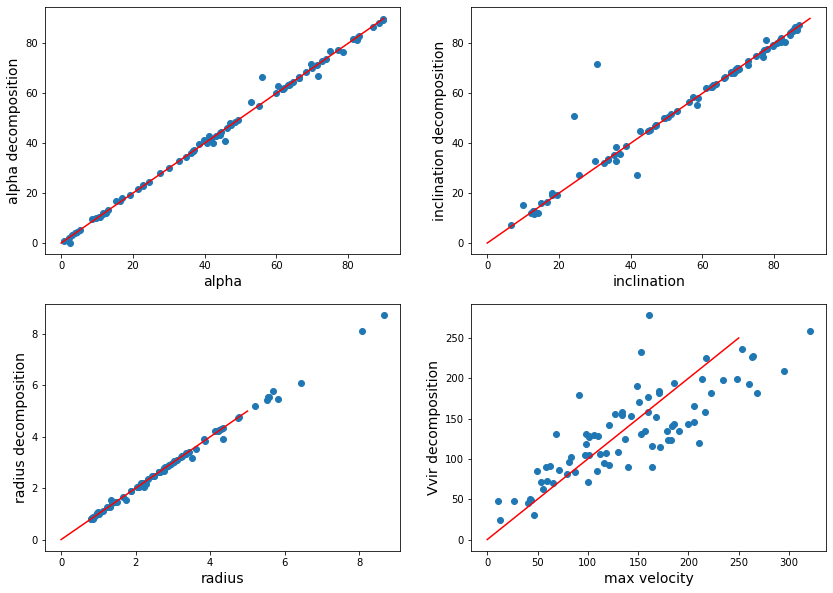

In [1351]:
plt.figure(figsize = (14,10))
#plt.suptitle("The 82 good runs with SNR>3", size = 20)
plt.subplot(221)
plt.scatter(compare["alpha"], compare["alpha_decomp"])
plt.plot([0,90], [0,90], c = 'r')
plt.xlabel("alpha", size = 14)
plt.ylabel("alpha decomposition", size = 14)

plt.subplot(222)
plt.scatter(compare["inclination"], compare["inclination_decomp"])
plt.plot([0,90], [0,90], c = 'r')
plt.xlabel("inclination", size = 14)
plt.ylabel("inclination decomposition", size = 14)

plt.subplot(223)
plt.scatter(compare["radius"], compare["radius_decomp"])
plt.plot([0,5], [0,5], c = 'r')
plt.xlabel("radius", size = 14)
plt.ylabel("radius decomposition", size = 14)

plt.subplot(224)
plt.scatter(compare["maximum_velocity"], compare["virial_velocity_decomp"])
plt.plot([0,250], [0,250], c = 'r')
plt.xlabel("max velocity", size = 14)
plt.ylabel("Vvir decomposition", size = 14)

Text(0, 0.5, 'sed logM*')

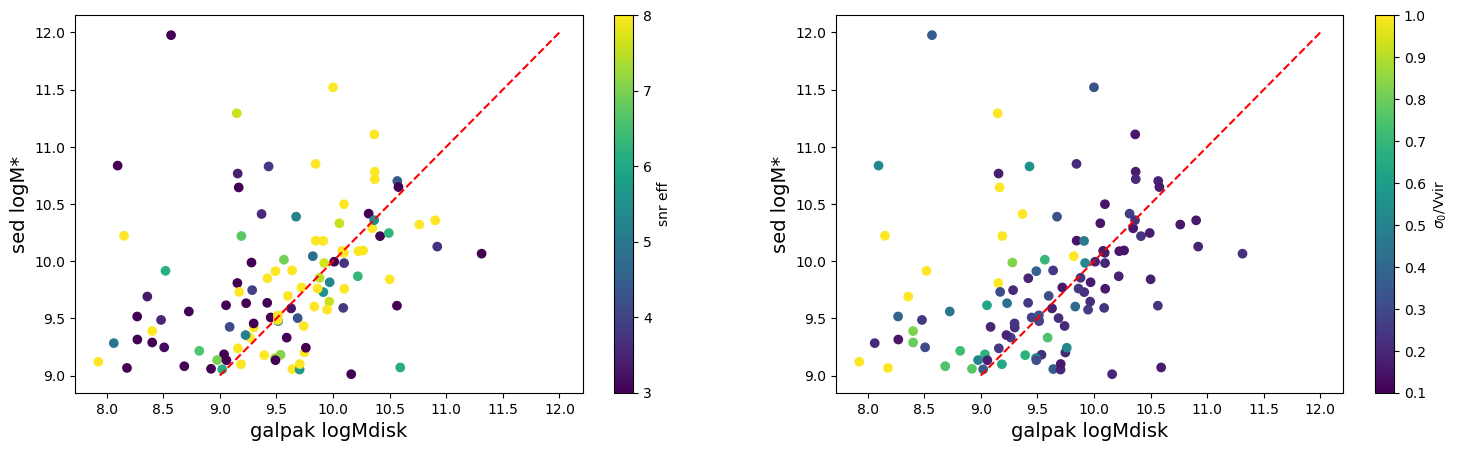

In [1355]:
plt.figure(dpi = 100, figsize = (18, 5))
plt.subplot(121)
plt.scatter(isol_good_runs["log_Mdisk"], isol_good_runs["sed_logMass"], \
            c = isol_good_runs["snr_eff"], vmin = 3, vmax = 8, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.plot([9,12], [9,12], c = "r", linestyle = "--")
plt.colorbar(label = "snr eff")
plt.xlabel("galpak logMdisk", size = 14)
plt.ylabel("sed logM*", size = 14)
plt.subplot(122)
plt.scatter(isol_good_runs["log_Mdisk"], isol_good_runs["sed_logMass"], \
            c = isol_good_runs["velocity_dispersion_2Rd"]/(isol_good_runs["v22"]+0.01), vmin = 0.1, vmax = 1, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.plot([9,12], [9,12], c = "r", linestyle = "--")
plt.colorbar(label = "$\sigma_(2Re)$/V(2.2Rd)")
plt.xlabel("galpak logMdisk", size = 14)
plt.ylabel("sed logM*", size = 14)

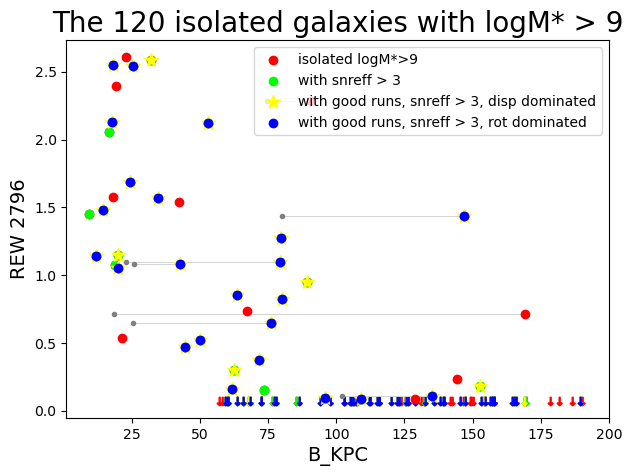

In [1366]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies with logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(isol_snr3_abs["B_KPC"], isol_snr3_abs["REW_2796"], c = 'lime', marker = "o",\
                 label = "with snreff > 3", zorder = 3)

plt.scatter(isol_snr3_good_runs_abs["B_KPC"], isol_snr3_good_runs_abs["REW_2796"], c = 'yellow', marker = "*",\
                 label = "with good runs, snreff > 3, disp dominated", zorder = 3, s = 100)

plt.scatter(isol_snr3_good_runs_rot_abs["B_KPC"], isol_snr3_good_runs_rot_abs["REW_2796"], c = 'b',\
                 label = "with good runs, snreff > 3, rot dominated", zorder = 3)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")

plt.scatter(isol_snr3_noabs["B_KPC"], isol_snr3_noabs["detection_limit_p75"], c = "lime",\
             marker = "$\downarrow$")

plt.scatter(isol_snr3_good_runs_noabs["B_KPC"], isol_snr3_good_runs_noabs["detection_limit_p75"], c = "yellow",\
             marker = "$\downarrow$")

plt.scatter(isol_snr3_good_runs_rot_noabs["B_KPC"], isol_snr3_good_runs_rot_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

In [1371]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(closest_9)) + " closest galaxies with logM* > 9", size = 20)
plt.scatter(closest_9_abs["B_KPC"], closest_9_abs["REW_2796"], c = 'b',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(closest_9_noabs["B_KPC"], closest_9_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")

#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B [KPC]", size = 14)
plt.ylabel("$W^{2796}_r$", size = 14)
#plt.legend()

Text(0, 0.5, '$W^{2796}_r$')

In [1824]:
for c in closest_9.columns:
    print(c)

Unnamed: 0
ID
field_id
DATASET
FROM
Z
ZCONF
is_QSO
is_star
DR1_id
DR1_nbmatch
RA
DEC
B_KPC
B_ARCSEC
REFSPEC
REFCENTER
FELINE_ID
WHITE_ID
WHITE_ID.1
MANUAL_ID
fel_ID
FEL_score
FEL_sigma
WHITE_ID.2
WHITE_ID.3
wh_SDSS_r
wh_SDSS_i
sp_F775W
sp_SDSS_r
sp_SDSS_i
SDSS_r
SDSS_r_ERR
SDSS_i
SDSS_i_ERR
MAG_F775W
MAG_F775W_ERR
OII3726_FLUX
OII3726_FLUX_ERR
OII3726_EQW
OII3726_FLUX_EQW
OII3729_FLUX
OII3729_FLUX_ERR
OII3729_EQW
OII3729_EQW_ERR
MGII2796_EMI_FLUX
MGII2796_EMI_FLUX_ERR
MGII2796_ABS_EQW
MGII2796_ABS_EQW_ERR
MGII2803_EMI_FLUX
MGII2803_EMI_FLUX_ERR
MGII2803_ABS_EQW
MGII2803_ABS_EQW_ERR
sed_logMass
sed_logMass_l95
sed_logMass_u95
sed_rchisq
sed_ebv
sed_ebv_l95
sed_ebv_u95
sed_age
sed_age_l95
sed_age_u95
sed_metallicity
sed_tau
sed_tau_l95
sed_tau_u95
sed_curr_sfr
sed_curr_sfr_l95
sed_curr_sfr_u95
sed_sfr_100
sed_sfr_100_l95
sed_sfr_100_u95
photoz_zbest
photoz_zbest_l95
photoz_zbest_u95
photoz_rchisq
EXPTIME(s)
PSF_qso
Comments_qso
zqso_sdss
depth_qso
ebv_sfd_qso
ebv_sandf_qso
ebv_planck_qso

Text(0, 0.5, '$W^{2796}_r$')

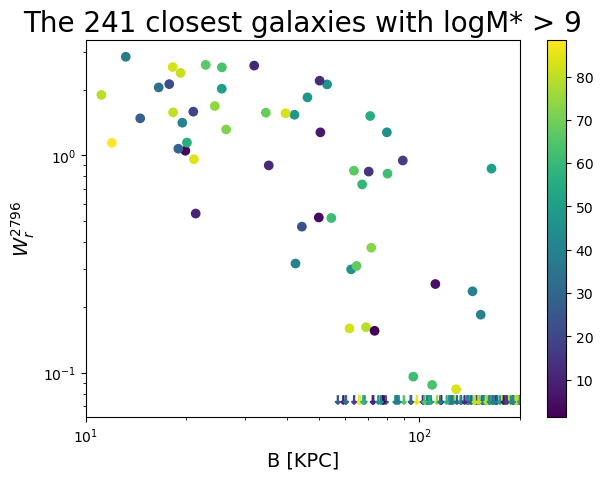

In [1840]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(closest_9)) + " closest galaxies with logM* > 9", size = 20)
plt.scatter(closest_9_abs["B_KPC"], closest_9_abs["REW_2796"],\
                 label = "isolated logM*>9", zorder = 2,\
           c = closest_9_abs["alpha"])
plt.colorbar()

plt.scatter(closest_9_noabs["B_KPC"], closest_9_noabs["detection_limit_p75"],\
             marker = "$\downarrow$", c = closest_9_noabs["alpha"])

#plt.colorbar(label = "N2000")
plt.xlim((10, 200))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("B [KPC]", size = 14)
plt.ylabel("$W^{2796}_r$", size = 14)
#plt.legend()

(0.0, 2.5)

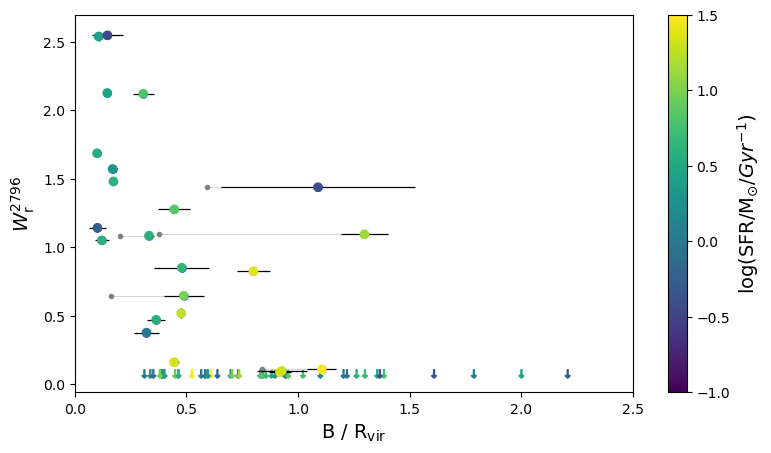

In [1370]:
plt.figure(dpi = 100, figsize = (9, 5))
#plt.title("The " + str(len(isol_good_runs)) + " good runs", size = 20)

dv = 0.5e6
for i, g in isol_snr3_good_runs_rot_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin/g["Rvir"], bmax/g["Rvir"], color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"]/g["Rvir"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.errorbar(np.array(isol_snr3_good_runs_rot_abs["B_KPC"]/isol_snr3_good_runs_rot_abs["Rvir"]), \
             np.array(isol_snr3_good_runs_rot_abs["REW_2796"]),\
             xerr = np.array(isol_snr3_good_runs_rot_abs["B_KPC"]/(isol_snr3_good_runs_rot_abs["Rvir"]**2)*isol_snr3_good_runs_rot_abs["Rvir_err"]),\
             yerr = np.array(isol_snr3_good_runs_rot_abs["sig_REW_2796"]),\
             linestyle = "none", linewidth = 0.9, ecolor = "black", marker = "o", markersize = 5,\
            color = "blue")
plt.scatter(isol_snr3_good_runs_rot_abs["B_KPC"]/isol_snr3_good_runs_rot_abs["Rvir"], isol_snr3_good_runs_rot_abs["REW_2796"],\
             label = "with good runs and snreff > 3", zorder = 3, \
            c = np.log10(isol_snr3_good_runs_rot_abs["SFR_gilbank"]), vmin = -1, vmax = 1.5)
cb = plt.colorbar()
cb.set_label(label = "log(SFR/M$_{\odot}/Gyr^{-1}$)", size = 14)
plt.scatter(isol_snr3_good_runs_rot_noabs["B_KPC"]/isol_snr3_good_runs_rot_noabs["Rvir"],\
            isol_snr3_good_runs_rot_noabs["detection_limit_p75"], c = np.log10(isol_snr3_good_runs_rot_noabs["SFR_gilbank"]),\
             marker = "$\downarrow$", vmin = -1, vmax = 1.5)


plt.xlabel("B / R$_{\mathrm{vir}}$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
#plt.xscale("log")
#plt.yscale("log")
plt.xlim((0,2.5))
#plt.legend()

la fonction est f = B/Rvir, l'erreur sur cette derniere est donc:
Df(B/Rvir) = |df/dRvir| x DRvir
or ici df/dRvir = -B/Rvir^2

In [1841]:
plt.figure(dpi = 100, figsize = (9, 5))
#plt.title("The " + str(len(isol_good_runs)) + " good runs", size = 20)

dv = 0.5e6
for i, g in isol_snr3_good_runs_rot_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin/g["Rvir"], bmax/g["Rvir"], color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"]/g["Rvir"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.errorbar(np.array(isol_snr3_good_runs_rot_abs["B_KPC"]/isol_snr3_good_runs_rot_abs["Rvir"]), \
             np.array(isol_snr3_good_runs_rot_abs["REW_2796"]),\
             xerr = np.array(isol_snr3_good_runs_rot_abs["B_KPC"]/(isol_snr3_good_runs_rot_abs["Rvir"]**2)*isol_snr3_good_runs_rot_abs["Rvir_err"]),\
             yerr = np.array(isol_snr3_good_runs_rot_abs["sig_REW_2796"]),\
             linestyle = "none", linewidth = 0.9, ecolor = "black", marker = "o", markersize = 5,\
            color = "blue")
plt.scatter(isol_snr3_good_runs_rot_abs["B_KPC"]/isol_snr3_good_runs_rot_abs["Rvir"], isol_snr3_good_runs_rot_abs["REW_2796"],\
             label = "with good runs and snreff > 3", zorder = 3, \
            c = np.log10(isol_snr3_good_runs_rot_abs["SFR_gilbank"]), vmin = -1, vmax = 1.5)
cb = plt.colorbar()
cb.set_label(label = "log(SFR/M$_{\odot}/Gyr^{-1}$)", size = 14)
plt.scatter(isol_snr3_good_runs_rot_noabs["B_KPC"]/isol_snr3_good_runs_rot_noabs["Rvir"],\
            isol_snr3_good_runs_rot_noabs["detection_limit_p75"], c = np.log10(isol_snr3_good_runs_rot_noabs["SFR_gilbank"]),\
             marker = "$\downarrow$", vmin = -1, vmax = 1.5)


plt.xlabel("B / R$_{\mathrm{vir}}$", size = 14)
plt.ylabel("$W^{2796}_{\mathrm{r}}$", size = 14)
plt.xscale("log")
plt.yscale("log")
plt.xlim((0,2.5))
#plt.legend()

/tmp/ipykernel_3292137/4196866751.py:37: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim((0,2.5))


(0.05029507790589258, 2.5)

In [989]:
RR = isol_good_runs.copy()

proxy_neighb = []
dv = 0.5e6
for i, g in isol_good_runs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    k4 = R_all["ID"] != g["ID"]
    K = R_all[k1 & k2 & k3 & k4]
    proxy_neighb.append(len(K))
RR["proxy_neighb"] = np.array(proxy_neighb)

In [990]:
p0 = RR["proxy_neighb"] == 0
p1 = RR["v22"]/RR["velocity_dispersion_2Re"] > 2
p3 = RR["bool_absorption"] == 1

RR_filt = RR[p1]
RR_filt_abs = RR[p1 & p3]
RR_filt_noabs = RR[p1 & ~p3]

81


(0.0, 3.0)

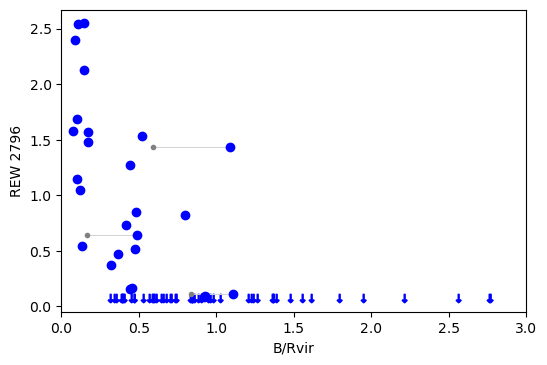

In [991]:
plt.figure(dpi = 100, figsize = (6, 4))
print(len(RR_filt))
dv = 0.5e6
for i, g in RR_filt_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin/g["Rvir"], bmax/g["Rvir"], color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"]/g["Rvir"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
plt.scatter(RR_filt_abs["B_KPC"]/RR_filt_abs["Rvir"], RR_filt_abs["REW_2796"],\
                 label = "with good runs and snreff > 3", zorder = 2, c = "blue")
plt.scatter(RR_filt_noabs["B_KPC"]/RR_filt_noabs["Rvir"],\
            RR_filt_noabs["detection_limit_p75"], \
             marker = "$\downarrow$", c = "blue")
plt.xlabel("B/Rvir")
plt.ylabel("REW 2796")
#plt.xscale("log")
#plt.yscale("log")
plt.xlim((0, 3))

Text(0, 0.5, 'REW 2796')

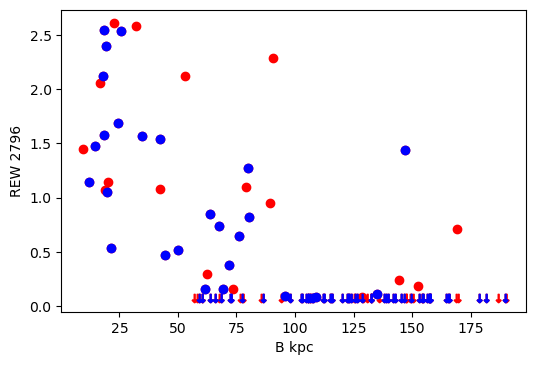

In [992]:
plt.figure(dpi = 100, figsize = (6, 4))

plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"],\
                 label = "with good runs and snreff > 3",c = "r")
plt.scatter(RR_filt_abs["B_KPC"], RR_filt_abs["REW_2796"],\
                 label = "with good runs and snreff > 3", zorder = 2, c = "blue")
plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"],\
                 label = "with good runs and snreff > 3",c = "r", marker = "$\downarrow$",)
plt.scatter(RR_filt_noabs["B_KPC"],\
            RR_filt_noabs["detection_limit_p75"], \
             marker = "$\downarrow$", c = "blue")

plt.xlabel("B kpc")
plt.ylabel("REW 2796")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim((0, 1.5))

In [993]:
tt = isol_good_runs.sort_values(by=["REW_2796"], ascending = False)
tt = tt[tt["bool_absorption"] == 1]
tt["hz"] = 0.15*tt["radius"]
tt["B_Rvir"] = tt["B_KPC"]/tt["Rvir"]
#tt["sigma1_rvir"] = tt["hz"]*tt["virial_velocuty"]/tt["Rvir"] 
tt[["ID", "B_KPC", "Rvir", "REW_2796", "virial_velocity", "velocity_dispersion", "B_Rvir", "REW_2796", \
   "sed_logMass", "log_Mdisk"]]

ID   B_KPC        Rvir  REW_2796  virial_velocity  \
1295  24044   22.87  120.380045     2.606       134.224173   
1634  28065   31.96   34.420178     2.587        47.664175   
1581  28002   18.20  124.438552     2.547       107.975625   
1110  22066   25.57  239.365267     2.539       225.825158   
314   13088   19.23  222.134574     2.394       209.221719   
1397  25095   17.78  122.188556     2.126       123.310866   
98    11121   52.86  172.226184     2.120       190.745462   
354   13128   24.35  243.820407     1.686       181.986106   
447   14120   18.26  249.328498     1.577       277.901230   
294   13063   34.64  204.616661     1.571       181.266555   
922   20064   42.21   81.401209     1.537       107.157692   
1802  30047   14.55   84.045760     1.480        92.683729   
750   18057  146.96  134.889493     1.438       104.642992   
1303  24052   79.85  179.216405     1.276       236.034773   
1033  21117   20.09   99.091332     1.145        96.085582   
755   18063   11.96  117.896850     1.142       107.428903   
588   16076   79.21   61.043615     1.094        69.899341   
1038  21122   42.50  127.778440     1.084       130.641831   
509   15040   19.87  164.284410     1.050       151.677742   
935   20077   89.15   60.385317     0.947        85.008835   
1722  29059   63.63  132.716349     0.850       129.456173   
865   19103   80.22  100.208022     0.824       106.679859   
1289  24038   67.33  160.390789     0.735       210.468291   
125   11149  169.17  105.903319     0.715        84.079087   
675   17068   75.93  155.481237     0.646       197.830831   
742   18049   21.34  162.853421     0.540       125.731899   
1994  32055   49.92  104.700939     0.518       115.919969   
1224  23122   44.42  121.793337     0.470       134.384368   
1204  23102   71.71  223.247475     0.376       199.008877   
1092  22048   62.41   22.262555     0.299        24.653800   
645   17034  144.25   78.300130     0.237        66.988932   
931   20073  152.65  146.458986     0.185       126.721853   
687   17080   69.16  152.104556     0.162       170.281769   
910   20052   61.71  138.732796     0.160       158.426274   
1927  31104  135.02  121.989211     0.108       157.758733   
924   20066   95.85  103.354029     0.096       141.424520   
474   14148  109.13  118.682550     0.088       135.233275   
679   17072  128.79   87.375430     0.084        82.555031   

      velocity_dispersion    B_Rvir  REW_2796  sed_logMass  log_Mdisk  
1295            42.588308  0.189982     2.606     9.614550   9.054545  
1634            47.397578  0.928525     2.587    10.222157   8.153564  
1581            21.743430  0.146257     2.547     9.729368   9.913751  
1110            17.067203  0.106824     2.539    10.246100  10.492193  
314             41.339803  0.086569     2.394    10.218640  10.414875  
1397            12.041368  0.145513     2.126    10.090308  10.080805  
98              62.336222  0.306922     2.120     9.983906   9.921454  
354              5.828881  0.099869     1.686    10.287496  10.345810  
447             94.821569  0.073237     1.577    10.065442  11.311959  
294              8.889362  0.169292     1.571    10.320016  10.761908  
922             32.104008  0.518543     1.537     9.632615   9.232044  
1802             5.575761  0.173120     1.480     9.100941   9.706034  
750             15.518370  1.089484     1.438     9.476273   9.514662  
1303            26.284214  0.445551     1.276     9.983195  10.097353  
1033            89.977714  0.202742     1.145    10.412265   9.368292  
755             11.535959  0.101445     1.142     9.587306   9.629013  
588             50.068193  1.297597     1.094    10.012802   9.565685  
1038            41.344133  0.332607     1.084     9.178402   9.392160  
509             23.186524  0.120949     1.050     9.854501   9.880930  
935             82.796176  1.476352     0.947    11.292372   9.148901  
1722            22.079166  0.479444     0.850     9.485826   9.511535  
865   

In [994]:
plt.scatter(tt["sed_logMass"], tt["log_Mdisk"], c = tt["velocity_dispersion"]/tt["virial_velocity"], \
           vmin = 0.1, vmax = 1)
plt.plot([9,11], [9, 11], c = "r")

In [995]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_good_runs)) + " good runs", size = 20)

dv = 0.5e6
for i, g in isol_good_runs_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin/g["Rvir"], bmax/g["Rvir"], color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"]/g["Rvir"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_good_runs_abs["B_KPC"]/isol_good_runs_abs["Rvir"], isol_good_runs_abs["REW_2796"],\
                 label = "with good runs and snreff > 3", zorder = 2, \
            c = isol_good_runs_abs["virial_velocity"], vmin = 50, vmax = 250)
plt.colorbar(label = "log(SFR)")
plt.scatter(isol_good_runs_noabs["B_KPC"]/isol_good_runs_noabs["Rvir"],\
            isol_good_runs_noabs["detection_limit_p75"], c = isol_good_runs_noabs["virial_velocity"],\
             marker = "$\downarrow$", vmin = 50, vmax = 250)


plt.xlabel("B / Rvir", size = 14)
plt.ylabel("REW 2796", size = 14)
#plt.xscale("log")
#plt.yscale("log")
plt.xlim((0,2))
#plt.legend()

(0.0, 2.0)

In [996]:
fig = plt.figure(figsize = (7,7), dpi = 100)
#plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = "blue", label = "all")
#plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"],c = "blue", marker = "$\downarrow$")

ymin = -0.6
ymax = 3.
xmin = 0
xmax = 5
massmin = 9
massmax = 12
ss_min = 0.02
ss_max = 0.1
vmin = -0.5
vmax = 1.2

for i, g in isol_good_runs.iterrows():
    xx = (g["B_KPC"]/g["Rvir"] - xmin)/(xmax - xmin)
    yy = (g["REW_2796"] - ymin)/(ymax - ymin)
    if g["REW_2796"] == 0:
        randy = random.uniform(-0.5, -0.05)
        yy = (randy - ymin)/(ymax - ymin)
    
    mass = g["sed_logMass"]
    incl = g["inclination"]
    alpha = g["alpha"]
    logSFR = np.log10(g["SFR_gilbank"])
    z = g["Z"]
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    ss = 0.05
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=alpha,\
                        edgecolor = plt.cm.viridis((logSFR - vmin) / (vmax - vmin)), fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
    else:
        plt.scatter(xx, yy)
    
#plotting the 0 line
plt.axhline(-ymin/(ymax - ymin), c = "gray", linewidth = 0.5)

# Now for the axis:
step = 5
xdata = np.linspace(0, 1, 5)
xvalues = np.linspace(xmin, xmax, 5)
ydata = np.linspace(0,1, 8)
yvalues = np.round(np.linspace(ymin, ymax, 8),2)
    
plt.xlim((0, 1))
plt.ylim((0, 1))
# Set custom tick values for the x-axis
plt.xticks(xdata, xvalues)
plt.yticks(ydata, yvalues)

plt.xlabel("B/Rvir")
plt.ylabel("REW 2796")

Text(0, 0.5, 'REW 2796')

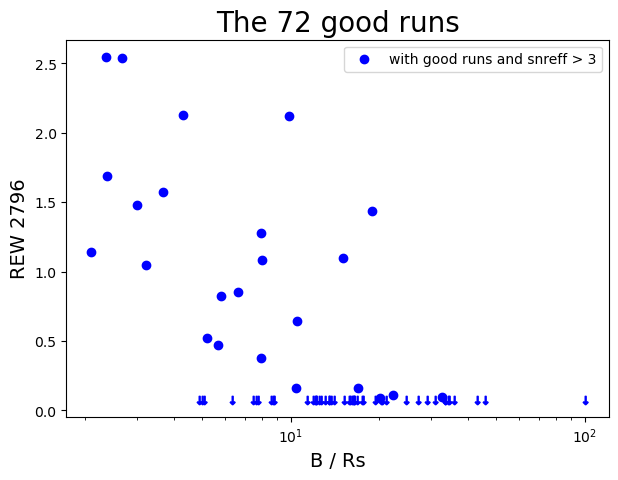

In [997]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_snr3_good_runs_rot)) + " good runs", size = 20)

dv = 0.5e6
#for i, g in isol_9_abs.iterrows():
#    z_abs = g["z_absorption"]
#    dz = dv*(1+z_abs)/const.c.value 
#    k1 = np.abs(R_all["Z"] - z_abs) < dz
#    k2 = R_all["field_id"] == g["field_id"]
#    k3 = R_all["B_KPC"] <= g["B_KPC"]
#    K = R_all[k1 & k2 & k3]
#    bmin = np.min(K["B_KPC"])
#    bmax = np.max(K["B_KPC"])
#    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
#    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_snr3_good_runs_abs["B_KPC"]/isol_snr3_good_runs_abs["rs_kpc"], \
            isol_snr3_good_runs_abs["REW_2796"], c = 'b',\
                 label = "with good runs and snreff > 3", zorder = 2)

plt.scatter(isol_snr3_good_runs_noabs["B_KPC"]/isol_snr3_good_runs_noabs["rs_kpc"],\
            isol_snr3_good_runs_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
#plt.xlim((1, 200))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B / Rs", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

### The Behroozi relations (M* vs Mhalo)

From Behroozi 2019:


Text(0, 0.5, '$\\log(M*/M_{\\odot})$')

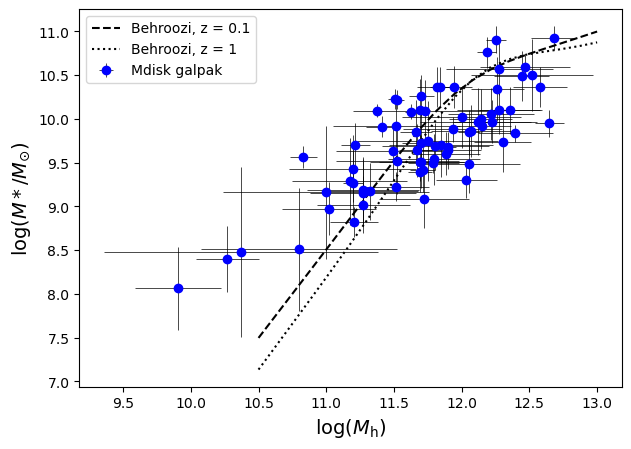

In [998]:
logMh = np.linspace(10.5,13.,20)
logMstar_1 = gt.Behroozi_2019_inv(logMh, 1)
logMstar_01 = gt.Behroozi_2019_inv(logMh, 0.1)

plt.figure(figsize = (7,5), dpi = 100)
plt.errorbar(np.array(isol_snr3_good_runs_rot["log_Mvir"]), np.array(isol_snr3_good_runs_rot["log_Mdisk"]),\
             xerr = np.array(isol_snr3_good_runs_rot["log_Mvir_err"]), \
             yerr = np.array(isol_snr3_good_runs_rot["log_Mdisk_err"]), \
             label = "Mdisk galpak", linestyle = "none", color = "blue", marker = "o", ecolor = "black", \
            linewidth = 0.5)
plt.plot(logMh, logMstar_01, c = "black", linestyle = "--", label = "Behroozi, z = 0.1")
plt.plot(logMh, logMstar_1, c = "black", linestyle = "dotted", label = "Behroozi, z = 1")
plt.legend()
plt.xlabel("$\log(M_{\mathrm{h}})$", size = 14)
plt.ylabel("$\log(M*/M_{\odot})$", size = 14)


# RF with galpak derived parameters Mvir, Rvir, rs etc.

In [1006]:
R_RF = gt.build_RF_param(isol_incl_good_runs, R, Mh = 1e12, dv = 0.5e6)

In [1007]:
R_RF_X = R_RF[["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "alpha", "Rvir",\
               "n_gal_win", "max_mass_win", "max_logSFR_win", \
             "max_logSSFR_win", "B_heaviest"]]
R_RF_Y = R_RF[["bool_absorption"]]

In [1008]:
RF = RandomForestClassifier(n_estimators=500)
RF.fit(R_RF_X, R_RF_Y)

/tmp/ipykernel_3292137/537642333.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(R_RF_X, R_RF_Y)


RandomForestClassifier(n_estimators=500)

Text(0, 0.5, 'feature importance')

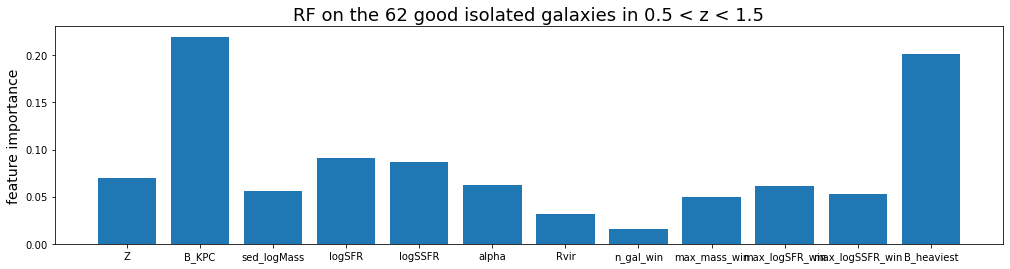

In [1009]:
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF))+" good isolated galaxies in 0.5 < z < 1.5", size = 18)
plt.bar(range(len(R_RF_X.columns)), RF.feature_importances_, tick_label = R_RF_X.columns)
plt.ylabel("feature importance", size = 14)

In [1017]:
R_RF2 = R_RF.copy()
R_RF2["B_Rvir"] = R_RF2["B_KPC"]/R_RF2["Rvir"]

In [1026]:
R_RF2_X = R_RF2[["Z", "B_KPC", "B_Rvir", "sed_logMass", "logSFR", "logSSFR", "alpha", "Rvir", "rs_kpc",\
               "n_gal_win", "max_mass_win", "max_logSFR_win", "B_closest", "mass_closest", \
             "max_logSSFR_win", "B_heaviest"]]
R_RF2_Y = R_RF2[["bool_absorption"]]

In [1027]:
RF2 = RandomForestClassifier(n_estimators=500)
RF2.fit(R_RF2_X, R_RF2_Y)

/tmp/ipykernel_3292137/1393631412.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF2.fit(R_RF2_X, R_RF2_Y)


RandomForestClassifier(n_estimators=500)

Text(0, 0.5, 'feature importance')

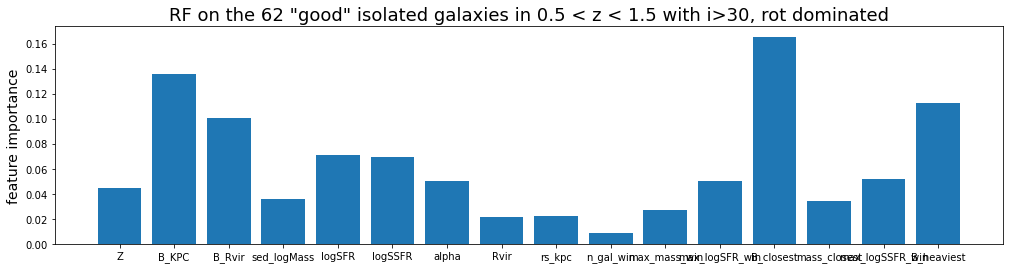

In [1028]:
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF2))+" \"good\" isolated galaxies in 0.5 < z < 1.5 with i>30, rot dominated", size = 18)
plt.bar(range(len(R_RF2_X.columns)), RF2.feature_importances_, tick_label = R_RF2_X.columns)
plt.ylabel("feature importance", size = 14)

Text(0, 0.5, 'alpha')

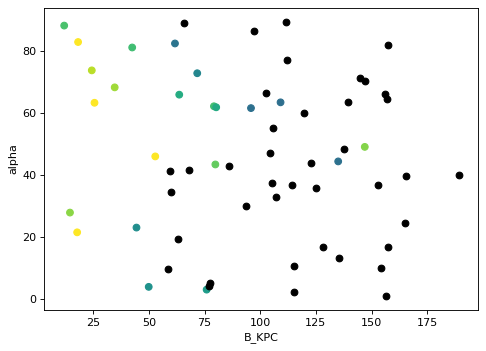

In [1032]:
plt.figure(figsize = (7,5), dpi = 80)
plt.scatter(isol_incl_good_runs_abs["B_KPC"], isol_incl_good_runs_abs["alpha"], \
            c = isol_incl_good_runs_abs["REW_2796"], vmin = -1, vmax = 2)
plt.scatter(isol_incl_good_runs_noabs["B_KPC"], isol_incl_good_runs_noabs["alpha"], \
            c = "black")
plt.xlabel("B_KPC")
plt.ylabel("alpha")

(0.0, 2.0)

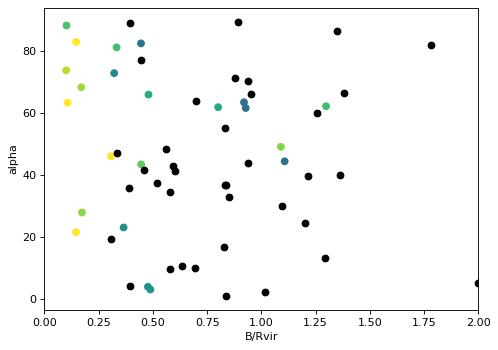

In [1040]:
plt.figure(figsize = (7,5), dpi = 80)
plt.scatter(isol_incl_good_runs_abs["B_KPC"]/isol_incl_good_runs_abs["Rvir"], isol_incl_good_runs_abs["alpha"], \
            c = isol_incl_good_runs_abs["REW_2796"], vmin = -1, vmax = 2)
plt.scatter(isol_incl_good_runs_noabs["B_KPC"]/isol_incl_good_runs_noabs["Rvir"], isol_incl_good_runs_noabs["alpha"], \
            c = "black")
plt.xlabel("B/Rvir")
plt.ylabel("alpha")
plt.xlim((0,2))

(-1.5, 2.5)

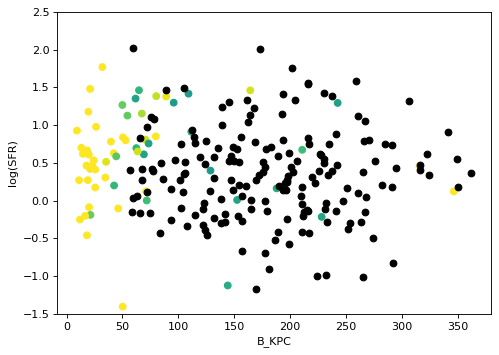

In [1162]:
plt.figure(figsize = (7,5), dpi = 80)
plt.scatter(closest_9_abs["B_KPC"], np.log10(closest_9_abs["SFR_gilbank"]), \
            c = closest_9_abs["REW_2796"], vmin = -1, vmax = 1)
plt.scatter(closest_9_noabs["B_KPC"], np.log10(closest_9_noabs["SFR_gilbank"]), \
            c = "black")
plt.xlabel("B_KPC")
plt.ylabel("log(SFR)")
plt.ylim((-1.5,2.5))
#plt.xlim((0,200))

(-1.5, 3.0)

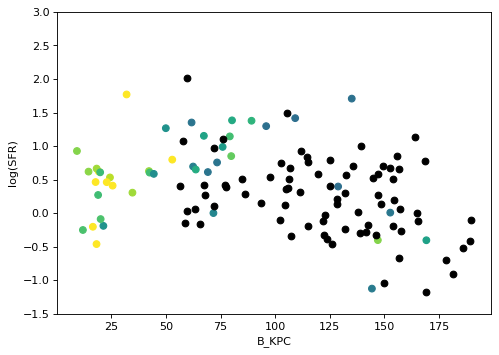

In [1059]:
plt.figure(figsize = (7,5), dpi = 80)
plt.scatter(isol_9_abs["B_KPC"], np.log10(isol_9_abs["SFR_gilbank"]), \
            c = isol_9_abs["REW_2796"], vmin = -1, vmax = 2)
plt.scatter(isol_9_noabs["B_KPC"], np.log10(isol_9_noabs["SFR_gilbank"]), \
            c = "black")
plt.xlabel("B_KPC")
plt.ylabel("log(SFR)")
plt.ylim((-1.5,3))

Text(0, 0.5, 'log(SFR)')

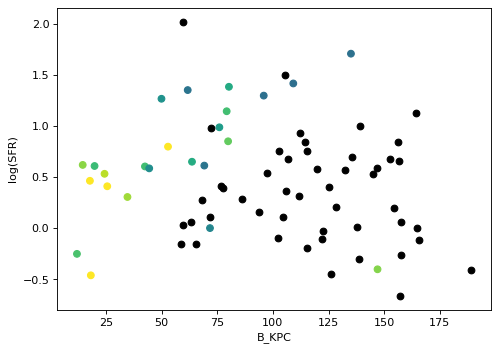

In [1052]:
plt.figure(figsize = (7,5), dpi = 80)
plt.scatter(isol_snr3_good_runs_abs["B_KPC"], np.log10(isol_snr3_good_runs_abs["SFR_gilbank"]), \
            c = isol_snr3_good_runs_abs["REW_2796"], vmin = -1, vmax = 2)
plt.scatter(isol_snr3_good_runs_noabs["B_KPC"], np.log10(isol_snr3_good_runs_noabs["SFR_gilbank"]), \
            c = "black")
plt.xlabel("B_KPC")
plt.ylabel("log(SFR)")
#plt.xlim((0,2))

Text(0, 0.5, 'log(SFR)')

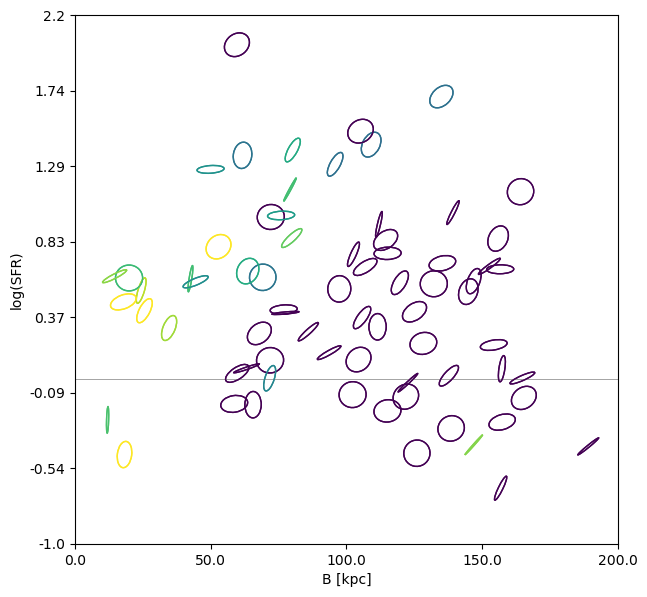

In [1070]:
fig = plt.figure(figsize = (7,7), dpi = 100)
#plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = "blue", label = "all")
#plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"],c = "blue", marker = "$\downarrow$")

ymin = -1
ymax = 2.2
xmin = 0
xmax = 200
massmin = 9
massmax = 12
ss_min = 0.02
ss_max = 0.1
vmin = -1
vmax = 2

for i, g in isol_snr3_good_runs.iterrows():
    xx = (g["B_KPC"] - xmin)/(xmax - xmin)
    yy = (np.log10(g["SFR_gilbank"]) - ymin)/(ymax - ymin)
    #if g["REW_2796"] == 0:
    #    randy = random.uniform(-0.5, -0.05)
    #    yy = (randy - ymin)/(ymax - ymin)
    
    mass = g["sed_logMass"]
    incl = g["inclination"]
    alpha = g["alpha"]
    logSFR = np.log10(g["SFR_gilbank"])
    z = g["Z"]
    REW = g["REW_2796"]
    if REW == 0:
        REW = -1
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    ss = 0.05
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=alpha,\
                        edgecolor = plt.cm.viridis((REW - vmin) / (vmax - vmin)), fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
    else:
        plt.scatter(xx, yy)
    
#plotting the 0 line
plt.axhline(-ymin/(ymax - ymin), c = "gray", linewidth = 0.5)

# Now for the axis:
step = 5
xdata = np.linspace(0, 1, 5)
xvalues = np.linspace(xmin, xmax, 5)
ydata = np.linspace(0,1, 8)
yvalues = np.round(np.linspace(ymin, ymax, 8),2)
    
plt.xlim((0, 1))
plt.ylim((0, 1))
# Set custom tick values for the x-axis
plt.xticks(xdata, xvalues)
plt.yticks(ydata, yvalues)

plt.xlabel("B [kpc]")
plt.ylabel("log(SFR)")

(0.0, 2.0)

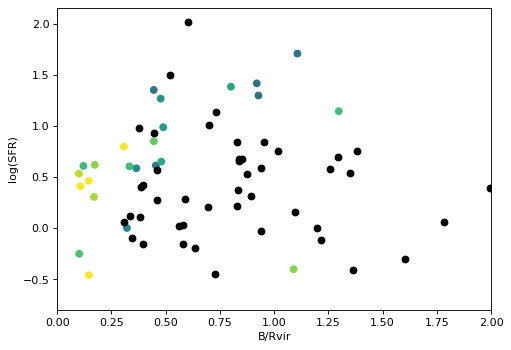

In [1053]:
plt.figure(figsize = (7,5), dpi = 80)
plt.scatter(isol_snr3_good_runs_abs["B_KPC"]/isol_snr3_good_runs_abs["Rvir"], isol_snr3_good_runs_abs["logSFR"], \
            c = isol_snr3_good_runs_abs["REW_2796"], vmin = -1, vmax = 2)
plt.scatter(isol_snr3_good_runs_noabs["B_KPC"]/isol_snr3_good_runs_noabs["Rvir"], isol_snr3_good_runs_noabs["logSFR"], \
            c = "black")
plt.xlabel("B/Rvir")
plt.ylabel("log(SFR)")
plt.xlim((0,2))

Text(0, 0.5, 'log(sSFR)')

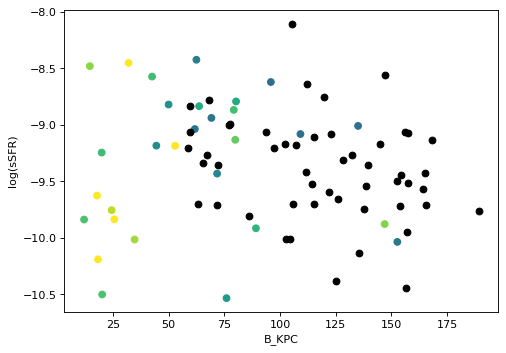

In [1048]:
plt.figure(figsize = (7,5), dpi = 80)
plt.scatter(isol_good_runs_abs["B_KPC"], np.log10(isol_good_runs_abs["SFR_gilbank"]/(10**isol_good_runs_abs["sed_logMass"])), \
            c = isol_good_runs_abs["REW_2796"], vmin = -1, vmax = 2)
plt.scatter(isol_good_runs_noabs["B_KPC"], np.log10(isol_good_runs_noabs["SFR_gilbank"]/(10**isol_good_runs_noabs["sed_logMass"])), \
            c = "black")
plt.xlabel("B_KPC")
plt.ylabel("log(sSFR)")
#plt.xlim((0,2))

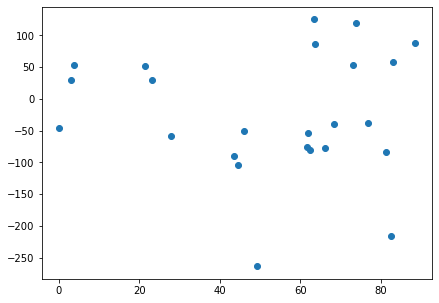

In [1076]:
plt.figure(figsize = (7,5))
plt.scatter(isol_snr3_good_runs_abs["alpha"],\
           const.c.value*(isol_snr3_good_runs_abs["z_absorption"] - isol_snr3_good_runs_abs["Z"])/(1+isol_snr3_good_runs_abs["Z"])/1e3)

In [1163]:
plt.figure(figsize = (7,5))
plt.scatter(isol_snr3_good_runs_abs["alpha"],\
           isol_snr3_good_runs_abs["vel_absorption_dist"]/1e3, c = isol_snr3_good_runs_abs["B_KPC"])
plt.colorbar()
plt.xlabel("alpha")
plt.ylabel("Dv abs (km/s)")

Text(0, 0.5, 'Dv abs (km/s)')

# Cusp / Core investigation

In [1762]:
pixel_size = 0.2 #arcsec
fov_size = 60
Npix = fov_size/pixel_size
print("Nb of pixel = ", Npix)

Nb of pixel =  300.0


In [241]:
pix_size = 0.2 * u.arcsec.to(u.rad)
isol_9["pixel_size"] = pix_size * cosmo.angular_diameter_distance(isol_9["Z"]).values*1000


/tmp/ipykernel_279039/4179263110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isol_9["pixel_size"] = pix_size * cosmo.angular_diameter_distance(isol_9["Z"]).values*1000


In [242]:
### plt.figure(figsize = (6,5))
plt.scatter(isol_9["rs_kpc"]/isol_9["pixel_size"], isol_9["radius"])
plt.plot([1,10],[1,10], c = "black", linestyle = "-.")
plt.axhline(1, c = "r", linestyle = "--")
plt.axvline(1, c = "r", linestyle = "--")
plt.xlabel("rs [pix]", size = 14)
plt.ylabel("Re [pix]", size = 14)
plt.xscale("log")
plt.yscale("log")

In [243]:
pix_size = 0.2 * u.arcsec.to(u.rad)
isol_good_runs["pixel_size"] = pix_size * cosmo.angular_diameter_distance(isol_good_runs["Z"]).values*1000
k1 = isol_good_runs["rs_kpc"]/isol_good_runs["pixel_size"] > 1
k2 = isol_good_runs["radius"] > 1

selec = isol_good_runs[k1 & k2]

/tmp/ipykernel_279039/1732213700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isol_good_runs["pixel_size"] = pix_size * cosmo.angular_diameter_distance(isol_good_runs["Z"]).values*1000


In [244]:
len(selec)

72

Text(0, 0.5, 'logSFR')

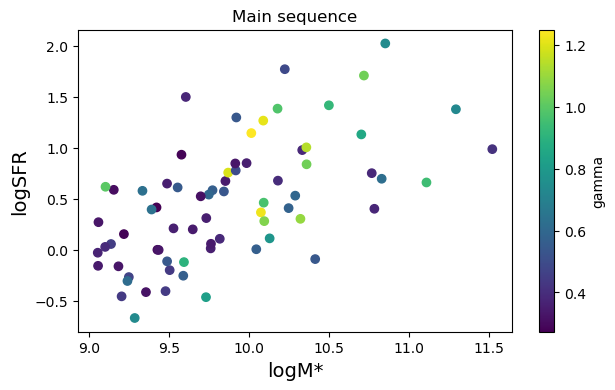

In [245]:
plt.figure(dpi = 100, figsize = (7, 4))
plt.title("Main sequence")
plt.scatter(selec["sed_logMass"], np.log10(selec["SFR_gilbank"]), \
            c = selec["gamma"], \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "gamma")
plt.xlabel("logM*", size = 14)
plt.ylabel("logSFR", size = 14)

In [246]:
plt.figure(dpi = 100, figsize = (7, 4))
plt.scatter(isol_good_runs["log_X"], isol_good_runs["gamma"], \
            c = np.log10(isol_good_runs["SFR_gilbank"]), \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "SFR")
plt.xlabel("log(X)", size = 14)
plt.ylabel("gamma", size = 14)

Text(0, 0.5, 'gamma')

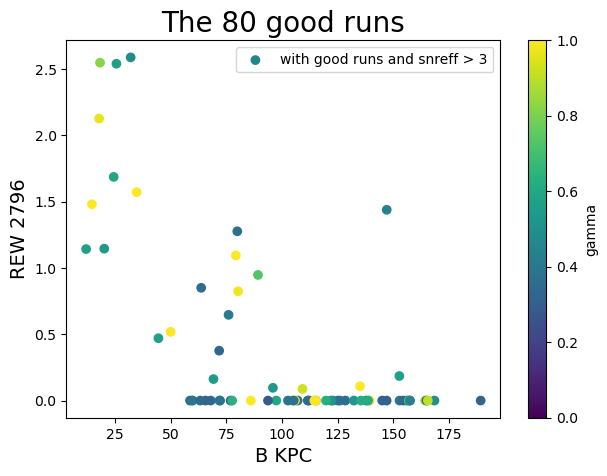

In [247]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_good_runs)) + " good runs", size = 20)

plt.scatter(selec["B_KPC"], selec["REW_2796"], \
            c = selec["gamma"], vmin = 0, vmax = 1, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "gamma")
#plt.scatter(isol_good_runs_noabs["B_KPC"],\
#            isol_good_runs_noabs["detection_limit_p75"], c = isol_good_runs_noabs["gamma"],\
#             marker = "$\downarrow$", vmin = 0, vmax = 1)
#plt.colorbar(label = "N2000")
#plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

Text(0, 0.5, 'REW 2796')

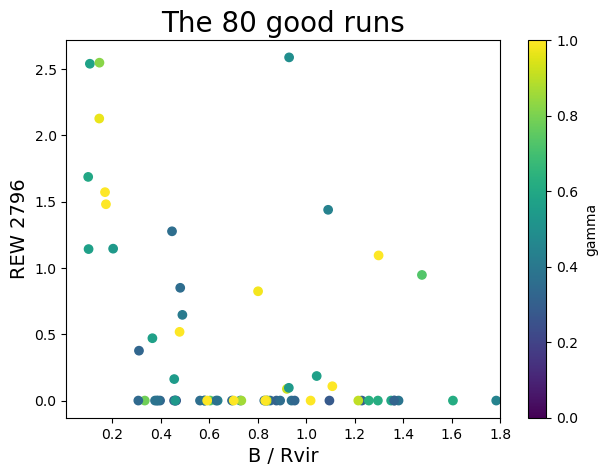

In [248]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_good_runs)) + " good runs", size = 20)

plt.scatter(selec["B_KPC"]/selec["Rvir"], selec["REW_2796"], \
            c = selec["gamma"], vmin = 0, vmax = 1, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "gamma")
#plt.scatter(isol_good_runs_noabs["B_KPC"]/isol_good_runs_noabs["Rvir"],\
#            isol_good_runs_noabs["detection_limit_p75"], c = isol_good_runs_noabs["gamma"],\
#             marker = "$\downarrow$", vmin = 0, vmax = 1)
#plt.colorbar(label = "N2000")
plt.xlim((0.01, 1.8))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B / Rvir", size = 14)
plt.ylabel("REW 2796", size = 14)
#plt.legend()

In [249]:
plt.figure(dpi = 100, figsize = (7, 4))
plt.scatter(np.log10(selec["SFR_gilbank"]), selec["gamma"], \
            c = selec["sed_logMass"], vmin = 9, vmax = 11, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "logM*")
plt.xlabel("log(SFR)", size = 14)
plt.ylabel("gamma (inner slope)", size = 14)

Text(0, 0.5, 'gamma (inner slope)')

Text(0, 0.5, 'gamma (inner slope)')

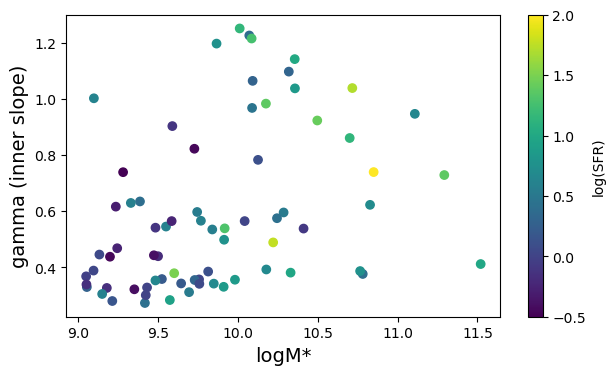

In [250]:
plt.figure(dpi = 100, figsize = (7, 4))
plt.scatter(selec["sed_logMass"], selec["gamma"], \
            c = np.log10(selec["SFR_gilbank"]), vmin = -0.5, vmax = 2, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "log(SFR)")
plt.xlabel("logM*", size = 14)
plt.ylabel("gamma (inner slope)", size = 14)

Text(0, 0.5, 'log(SFR/[M$_\\odot$ yr$^{-1}$])')

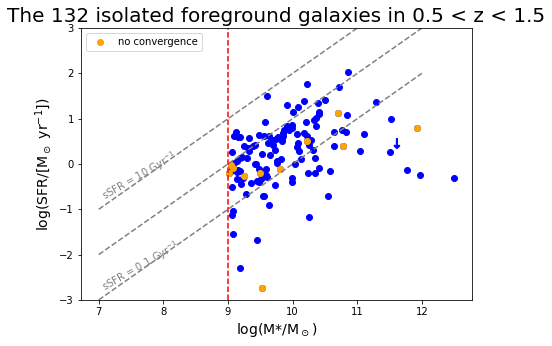

In [29]:
k1 = np.log10(isol_zselec["SFR_gilbank"]) < -3
plt.figure(figsize = (7,5))
isol_noSFR = isol_zselec[k1]

logmm = np.array([7,12])
sSFR_1 = np.log10(1e-9*10**logmm)
sSFR_01 = np.log10(0.1e-9*10**logmm)
sSFR_10 = np.log10(1e-8*10**logmm)


#sSFR = SFR/M
#SFR = M*sSFR
plt.title("The " + str(len(isol_zselec)) + " isolated foreground galaxies in 0.5 < z < 1.5", size = 20)

plt.scatter(isol_zselec["sed_logMass"], np.log10(isol_zselec["SFR_gilbank"]), c = "blue")
plt.scatter(isol_noSFR["sed_logMass"], np.log10(isol_noSFR["SFR_gilbank_lim"]), marker = "$\downarrow$",\
            s = 100, c = "blue")
plt.scatter(isol_9_noconvergence["sed_logMass"], np.log10(isol_9_noconvergence["SFR_gilbank"]), c = "orange",\
            label = "no convergence")
plt.plot(logmm, sSFR_01, c = 'grey', linestyle = "--")
plt.plot(logmm, sSFR_1, c = 'grey', linestyle = "--")
plt.plot(logmm, sSFR_10, c = 'grey', linestyle = "--")


plt.text(7, -0.8, 'sSFR = 10 Gyr$^{-1}$', fontsize = 10, color = 'gray', rotation = 30)
plt.text(7, -2.8, 'sSFR = 0.1 Gyr$^{-1}$', fontsize = 10, color = 'gray', rotation = 30)

plt.axvline(9, c = "r", linestyle = "--")

plt.legend()
plt.ylim((-3,3))
plt.xlabel("log(M*/M$_\odot$)", size = 14)
plt.ylabel("log(SFR/[M$_\odot$ yr$^{-1}$])", size = 14)

In [102]:
input_path = "/muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/"
output_path = "/muse/MG2QSO/private/analysis/galpak_dr2/"
gt.build_velocity_map_on_ids(input_path, output_path, isol_9, snr_min=1, ssmooth = 2)


1 / 121
J0014m0028_source-11083 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0014m0028/products/sources/J0014m0028_source-11083.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11083/
SKIP job: folder already exists

2 / 121
J0014m0028_source-11097 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0014m0028/products/sources/J0014m0028_source-11097.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11097/
SKIP job: folder already exists

3 / 121
J0014m0028_source-11117 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0014m0028/products/sources/J0014m0028_source-11117.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11117/
SKIP job: folder already exists

4 / 121
J0014m0028_source-11121 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0014m0028/products/sources/J0014m0028_source-11121.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11121/
SKIP job: folder already exists

5 / 121
J0014m0028_source-1

INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/J0134p0051_source-17056_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/J0134p0051_source-17056_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/camel_OII/camel_17056_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/camel_OII/camel_17056_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/J0134p0051_source-17056_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7095355e-04
 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04
 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04
 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04
 2.7095355e-04 2.7095355e-04 2.7095355e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
37 / 121
J0134p0051_source-17066 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17066.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17066/
SKIP job: folder already exists

38 / 121
J0134p0051_source-17068 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17068.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/
Z =  1.2738838912160313  OII SNR =  5.589354941852932 3.066384479665708
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/J0134p0051_source-17068_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/J0134p0051_source-17068_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/camel_OII/camel_17068_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/camel_OII/camel_17068_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/J0134p0051_source-17068_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.7930626e-04
 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04
 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04
 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04
 3.7930626e-04 3.7930626e-04 3.7930626e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
39 / 121
J0134p0051_source-17072 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17072.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/
Z =  0.8204597746459383  OII SNR =  7.787689944393904e-09 2.5006025633945295
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/J0134p0051_source-17072_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/J0134p0051_source-17072_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/camel_OII/camel_17072_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/camel_OII/camel_17072_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/J0134p0051_source-17072_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0367065e-04
 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04
 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04
 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04
 3.0367065e-04 3.0367065e-04 3.0367065e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
40 / 121
J0134p0051_source-17073 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17073.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/
Z =  0.5493053301884707  OII SNR =  12.1637034297972 15.54080341039456
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/J0134p0051_source-17073_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/J0134p0051_source-17073_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/camel_OII/camel_17073_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/camel_OII/camel_17073_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/J0134p0051_source-17073_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5843942e-04
 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04
 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04
 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04
 2.5843942e-04 2.5843942e-04 2.5843942e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
41 / 121
J0134p0051_source-17078 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17078.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/
Z =  1.152612361944307  OII SNR =  4.7407797044475295 5.2595573350206495
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/J0134p0051_source-17078_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/J0134p0051_source-17078_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/camel_OII/camel_17078_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/camel_OII/camel_17078_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/J0134p0051_source-17078_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.5907698e-04
 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04
 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04
 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04
 3.5907698e-04 3.5907698e-04 3.5907698e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
42 / 121
J0134p0051_source-17080 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17080.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17080/
SKIP job: folder already exists

43 / 121
J0134p0051_source-17085 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17085.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/
Z =  0.9069270118196766  OII SNR =  4.718234286550704 6.536288199813875
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/J0134p0051_source-17085_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/J0134p0051_source-17085_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/camel_OII/camel_17085_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/camel_OII/camel_17085_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/J0134p0051_source-17085_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.1809424e-04
 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04
 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04
 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04
 3.1809424e-04 3.1809424e-04 3.1809424e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
44 / 121
J0134p0051_source-17102 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17102.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/
Z =  1.0494557988450057  OII SNR =  10.331648510390087 14.933050921705856
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/J0134p0051_source-17102_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/J0134p0051_source-17102_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/camel_OII/camel_17102_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/camel_OII/camel_17102_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/J0134p0051_source-17102_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.4186945e-04
 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04
 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04
 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04
 3.4186945e-04 3.4186945e-04 3.4186945e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
45 / 121
J0145p1056_source-18049 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0145p1056/products/sources/J0145p1056_source-18049.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18049/
SKIP job: folder already exists

46 / 121
J0145p1056_source-18057 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0145p1056/products/sources/J0145p1056_source-18057.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/
Z =  0.5561446700661763  OII SNR =  11.57749102475491 13.446260269584572
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/J0145p1056_source-18057_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/J0145p1056_source-18057_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/camel_OII/camel_18057_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/camel_OII/camel_18057_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/J0145p1056_source-18057_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 2.595803e-04
 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04
 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04
 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04
 2.595803e-04 2.595803e-04 2.595803e-04 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000

Progress =>  99%
47 / 121
J0145p1056_source-18063 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0145p1056/products/sources/J0145p1056_source-18063.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18063/
SKIP job: folder already exists

48 / 121
J0145p1056_source-18097 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0145p1056/products/sources/J0145p1056_source-18097.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/
Z =  0.4503058307458605  OII SNR =  14.30818213989088 19.80299085600116
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/J0145p1056_source-18097_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/J0145p1056_source-18097_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/camel_OII/camel_18097_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/camel_OII/camel_18097_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/J0145p1056_source-18097_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.4192533e-04
 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04
 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04
 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04
 2.4192533e-04 2.4192533e-04 2.4192533e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
49 / 121
J0800p1849_source-19044 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0800p1849/products/sources/J0800p1849_source-19044.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/
Z =  0.5414187718818959  OII SNR =  3.017028799160395e-11 10.497966451586686
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/J0800p1849_source-19044_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/J0800p1849_source-19044_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/camel_OII/camel_19044_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/camel_OII/camel_19044_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/J0800p1849_source-19044_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5712387e-04
 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04
 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04
 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04
 2.5712387e-04 2.5712387e-04 2.5712387e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
50 / 121
J0800p1849_source-19060 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0800p1849/products/sources/J0800p1849_source-19060.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/
Z =  0.5731902710988328  OII SNR =  37.261065320243986 46.43157324288884
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/J0800p1849_source-19060_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/J0800p1849_source-19060_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/camel_OII/camel_19060_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/camel_OII/camel_19060_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/J0800p1849_source-19060_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6242365e-04
 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04
 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04
 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04
 2.6242365e-04 2.6242365e-04 2.6242365e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
51 / 121
J0800p1849_source-19072 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0800p1849/products/sources/J0800p1849_source-19072.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/
Z =  0.5159009541194857  OII SNR =  10.2299405304229 14.411940084620522
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/J0800p1849_source-19072_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/J0800p1849_source-19072_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/camel_OII/camel_19072_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/camel_OII/camel_19072_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/J0800p1849_source-19072_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5286723e-04
 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04
 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04
 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04
 2.5286723e-04 2.5286723e-04 2.5286723e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
52 / 121
J0800p1849_source-19103 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0800p1849/products/sources/J0800p1849_source-19103.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19103/
SKIP job: folder already exists

53 / 121
J0838p0257_source-20044 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20044.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/
Z =  0.5323554072495573  OII SNR =  29.050931783889144 37.13574615524429
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/J0838p0257_source-20044_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/J0838p0257_source-20044_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/camel_OII/camel_20044_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/camel_OII/camel_20044_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/J0838p0257_source-20044_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5561202e-04
 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04
 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04
 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04
 2.5561202e-04 2.5561202e-04 2.5561202e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
54 / 121
J0838p0257_source-20052 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20052.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20052/
SKIP job: folder already exists

55 / 121
J0838p0257_source-20064 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20064.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20064/
SKIP job: folder already exists

56 / 121
J0838p0257_source-20066 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20066.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20066/
SKIP job: folder already exists

57 / 121
J0838p0257_source-20073 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20073.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/
Z =  0.6993776276950481  OII SNR =  1.34

INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/J0838p0257_source-20073_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/J0838p0257_source-20073_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/camel_OII/camel_20073_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/camel_OII/camel_20073_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/J0838p0257_source-20073_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.8347297e-04
 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04
 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04
 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04
 2.8347297e-04 2.8347297e-04 2.8347297e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
58 / 121
J0838p0257_source-20074 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20074.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/
Z =  0.557573613326029  OII SNR =  3.4643970187995525 6.966402934822298
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/J0838p0257_source-20074_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/J0838p0257_source-20074_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/camel_OII/camel_20074_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/camel_OII/camel_20074_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/J0838p0257_source-20074_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5981865e-04
 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04
 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04
 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04
 2.5981865e-04 2.5981865e-04 2.5981865e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
59 / 121
J0838p0257_source-20077 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20077.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20077/
SKIP job: folder already exists

60 / 121
J0937p0656_source-21107 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21107.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/
Z =  0.6372818500824569  OII SNR =  5.882462707377714 12.472100657568529
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/J0937p0656_source-21107_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/J0937p0656_source-21107_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/camel_OII/camel_21107_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/camel_OII/camel_21107_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/J0937p0656_source-21107_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7311477e-04
 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04
 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04
 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04
 2.7311477e-04 2.7311477e-04 2.7311477e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
61 / 121
J0937p0656_source-21111 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21111.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21111/
SKIP job: folder already exists

62 / 121
J0937p0656_source-21117 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21117.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21117/
SKIP job: folder already exists

63 / 121
J0937p0656_source-21122 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21122.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/
Z =  0.9337211739809126  OII SNR =  41.930702668221286 49.080458848388886
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/J0937p0656_source-21122_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/J0937p0656_source-21122_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/camel_OII/camel_21122_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/camel_OII/camel_21122_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/J0937p0656_source-21122_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.2256378e-04
 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04
 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04
 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04
 3.2256378e-04 3.2256378e-04 3.2256378e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
64 / 121
J0937p0656_source-21126 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21126.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21126/
SKIP job: folder already exists

65 / 121
J0937p0656_source-21127 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21127.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21127/
SKIP job: folder already exists

66 / 121
J1039p0714_source-22044 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1039p0714/products/sources/J1039p0714_source-22044.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/
Z =  0.48419110183221403  OII SNR =  1.5241474801672963 3.615355643587156
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/J1039p0714_source-22044_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/J1039p0714_source-22044_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/camel_OII/camel_22044_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/camel_OII/camel_22044_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/J1039p0714_source-22044_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.4757773e-04
 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04
 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04
 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04
 2.4757773e-04 2.4757773e-04 2.4757773e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
67 / 121
J1039p0714_source-22047 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1039p0714/products/sources/J1039p0714_source-22047.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/
Z =  0.5116155743931956  OII SNR =  22.642380698238558 26.859928455523708
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/J1039p0714_source-22047_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/J1039p0714_source-22047_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/camel_OII/camel_22047_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/camel_OII/camel_22047_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/J1039p0714_source-22047_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 2.521524e-04
 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04
 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04
 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04
 2.521524e-04 2.521524e-04 2.521524e-04 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000

Progress =>  99%
68 / 121
J1039p0714_source-22048 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1039p0714/products/sources/J1039p0714_source-22048.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22048/
SKIP job: folder already exists

69 / 121
J1039p0714_source-22066 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1039p0714/products/sources/J1039p0714_source-22066.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22066/
SKIP job: folder already exists

70 / 121
J1107p1021_source-23086 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23086.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23086/
SKIP job: folder already exists

71 / 121
J1107p1021_source-23089 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23089.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/
Z =  0.6269678311417359  OII SNR =  14.1

INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/J1107p1021_source-23089_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/J1107p1021_source-23089_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/camel_OII/camel_23089_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/camel_OII/camel_23089_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/J1107p1021_source-23089_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 2.713943e-04
 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04
 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04
 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04
 2.713943e-04 2.713943e-04 2.713943e-04 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000

/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1100: RuntimeWarning: invalid value encountered in true_divide
  perrorcube = perrorcube * np.sqrt(fnormmap / dofmap)
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1124: RuntimeWarning: invalid value encountered in true_divide
  chi2map = fnormmap / dofmap
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1167: RuntimeWarning: divide by zero encountered in true_divide
  fluxmaps[comp * els.index + i, :, :] = np.sum(intmaps[comp * els.index + i, :, :] * np.exp(-0.5 * (wave.reshape(wave.size, 1, 1) - linewave[i] * (1 + zmap[comp * els.index + i, :, :])) ** 2 / ((dzmap * linewave[i]) ** 2 + conf['SPSF'] ** 2)) * sclp * lconvfac, axis=0)
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1176: RuntimeWarning: invalid value encountered in true_divide
  efluxmaps[comp * els.index + i, :, :] = np.sqrt(np.pi * 2) * np.sqrt((eintmaps[comp * els.index + i, :, :] * np.sqrt((linewave[i] * dzmap) ** 2 + conf['SPSF'] ** 2))


72 / 121
J1107p1021_source-23092 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23092.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/
Z =  1.1086764932399396  OII SNR =  27.15793828814189 27.222995896814727
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/J1107p1021_source-23092_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/J1107p1021_source-23092_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/camel_OII/camel_23092_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/camel_OII/camel_23092_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/J1107p1021_source-23092_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.5174805e-04
 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04
 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04
 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04
 3.5174805e-04 3.5174805e-04 3.5174805e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

/muse/MG2QSO/private/analysis/galpak_dr2/galpak_tools.py:1612: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.imshow(img_vel*m, vmin = -150, vmax = 150, cmap = "bwr", extent = extent_kpc)



73 / 121
J1107p1021_source-23098 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23098.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23098/
SKIP job: folder already exists

74 / 121
J1107p1021_source-23102 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23102.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23102/
SKIP job: folder already exists

75 / 121
J1107p1021_source-23120 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23120.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23120/
SKIP job: folder already exists

76 / 121
J1107p1021_source-23121 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23121.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/
Z =  1.0347980869333222  OII SNR =  14.000094028607982 1

INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/J1107p1021_source-23121_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/J1107p1021_source-23121_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/camel_OII/camel_23121_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/camel_OII/camel_23121_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/J1107p1021_source-23121_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 3.394244e-04
 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04
 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04
 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04
 3.394244e-04 3.394244e-04 3.394244e-04 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000

Progress =>  99%
77 / 121
J1107p1021_source-23122 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23122.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23122/
SKIP job: folder already exists

78 / 121
J1107p1757_source-24036 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24036.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/
Z =  0.7837018715983339  OII SNR =  12.068474486141438 15.784812564323445
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/J1107p1757_source-24036_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/J1107p1757_source-24036_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/camel_OII/camel_24036_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/camel_OII/camel_24036_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/J1107p1757_source-24036_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.9753908e-04
 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04
 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04
 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04
 2.9753908e-04 2.9753908e-04 2.9753908e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
79 / 121
J1107p1757_source-24038 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24038.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/
Z =  1.3252558401987105  OII SNR =  1.0647827804294106e-09 1.49132868194516
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/J1107p1757_source-24038_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/J1107p1757_source-24038_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/camel_OII/camel_24038_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/camel_OII/camel_24038_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/J1107p1757_source-24038_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.8787563e-04
 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04
 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04
 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04
 3.8787563e-04 3.8787563e-04 3.8787563e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
80 / 121
J1107p1757_source-24043 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24043.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/
Z =  0.9405979023291593  OII SNR =  7.189989339630425 5.962550023525321
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/J1107p1757_source-24043_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/J1107p1757_source-24043_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/camel_OII/camel_24043_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/camel_OII/camel_24043_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/J1107p1757_source-24043_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.2371088e-04
 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04
 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04
 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04
 3.2371088e-04 3.2371088e-04 3.2371088e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
81 / 121
J1107p1757_source-24044 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24044.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24044/
SKIP job: folder already exists

82 / 121
J1107p1757_source-24052 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24052.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24052/
SKIP job: folder already exists

83 / 121
J1107p1757_source-24053 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24053.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/
Z =  0.6542989558817398  OII SNR =  2.5699185107529274 5.3295088999172995
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/J1107p1757_source-24053_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/J1107p1757_source-24053_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/camel_OII/camel_24053_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/camel_OII/camel_24053_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/J1107p1757_source-24053_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7595338e-04
 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04
 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04
 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04
 2.7595338e-04 2.7595338e-04 2.7595338e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
84 / 121
J1236p0725_source-25070 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1236p0725/products/sources/J1236p0725_source-25070.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/
Z =  0.40417186381683723  OII SNR =  7.181319607064329 7.182512022037632
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/J1236p0725_source-25070_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/J1236p0725_source-25070_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/camel_OII/camel_25070_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/camel_OII/camel_25070_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/J1236p0725_source-25070_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.3422972e-04
 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04
 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04
 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04
 2.3422972e-04 2.3422972e-04 2.3422972e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1100: RuntimeWarning: invalid value encountered in true_divide
  perrorcube = perrorcube * np.sqrt(fnormmap / dofmap)
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1124: RuntimeWarning: invalid value encountered in true_divide
  chi2map = fnormmap / dofmap
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1167: RuntimeWarning: divide by zero encountered in true_divide
  fluxmaps[comp * els.index + i, :, :] = np.sum(intmaps[comp * els.index + i, :, :] * np.exp(-0.5 * (wave.reshape(wave.size, 1, 1) - linewave[i] * (1 + zmap[comp * els.index + i, :, :])) ** 2 / ((dzmap * linewave[i]) ** 2 + conf['SPSF'] ** 2)) * sclp * lconvfac, axis=0)
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1176: RuntimeWarning: invalid value encountered in true_divide
  efluxmaps[comp * els.index + i, :, :] = np.sqrt(np.pi * 2) * np.sqrt((eintmaps[comp * els.index + i, :, :] * np.sqrt((linewave[i] * dzmap) ** 2 + conf['SPSF'] ** 2))


85 / 121
J1236p0725_source-25087 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1236p0725/products/sources/J1236p0725_source-25087.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/
Z =  1.039851920494741  OII SNR =  4.397613676481636 5.572426696910609
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/J1236p0725_source-25087_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/J1236p0725_source-25087_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/camel_OII/camel_25087_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/camel_OII/camel_25087_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/J1236p0725_source-25087_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.4026743e-04
 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04
 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04
 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04
 3.4026743e-04 3.4026743e-04 3.4026743e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
86 / 121
J1236p0725_source-25095 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1236p0725/products/sources/J1236p0725_source-25095.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25095/
SKIP job: folder already exists

87 / 121
J1314p0657_source-26056 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1314p0657/products/sources/J1314p0657_source-26056.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26056/
SKIP job: folder already exists

88 / 121
J1314p0657_source-26092 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1314p0657/products/sources/J1314p0657_source-26092.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26092/
Z =  1.2992865297006566  OII SNR =  6.581786724403898e-36 3.276723875241795e-33
before condition

89 / 121
J1314p0657_source-26095 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1314p0657/products/sources/J1314p0657_source-26095.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/

INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/J1314p0657_source-26095_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/J1314p0657_source-26095_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/camel_OII/camel_26095_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/camel_OII/camel_26095_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/J1314p0657_source-26095_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7271753e-04
 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04
 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04
 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04
 2.7271753e-04 2.7271753e-04 2.7271753e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
90 / 121
J1352p0614_source-27041 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1352p0614/products/sources/J1352p0614_source-27041.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/
Z =  0.5657445413666569  OII SNR =  26.003408039130086 35.836016388467534
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/J1352p0614_source-27041_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/J1352p0614_source-27041_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/camel_OII/camel_27041_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/camel_OII/camel_27041_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/J1352p0614_source-27041_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6118165e-04
 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04
 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04
 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04
 2.6118165e-04 2.6118165e-04 2.6118165e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
91 / 121
J1352p0614_source-27042 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1352p0614/products/sources/J1352p0614_source-27042.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/
Z =  0.4443032557041102  OII SNR =  23.96522087133996 36.70817766829081
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/J1352p0614_source-27042_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/J1352p0614_source-27042_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/camel_OII/camel_27042_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/camel_OII/camel_27042_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/J1352p0614_source-27042_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.4092404e-04
 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04
 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04
 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04
 2.4092404e-04 2.4092404e-04 2.4092404e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
92 / 121
J1352p0614_source-27066 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1352p0614/products/sources/J1352p0614_source-27066.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27066/


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



pa:  223.3974371867539  alpha :  46.121708438140615
3.7223509999999993 -0.474349 3.7205875 -0.4743638


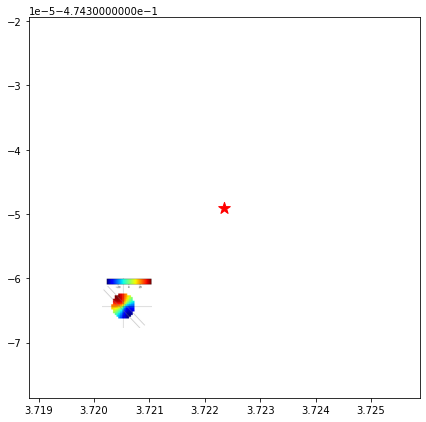

pa:  302.7109240495342  alpha :  68.40552919723638
3.89656555 -7.850853769444444 3.8968159 -7.8495916


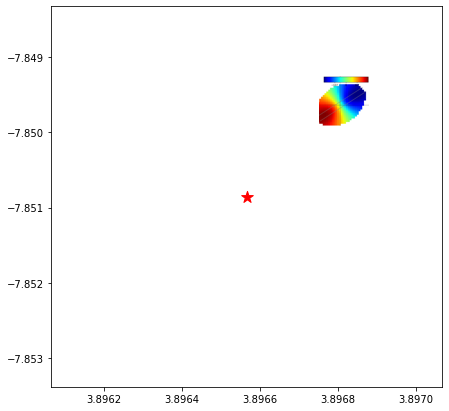

pa:  290.9754972717435  alpha :  73.94836101559741
3.89656555 -7.850853769444444 3.8972148 -7.8500011


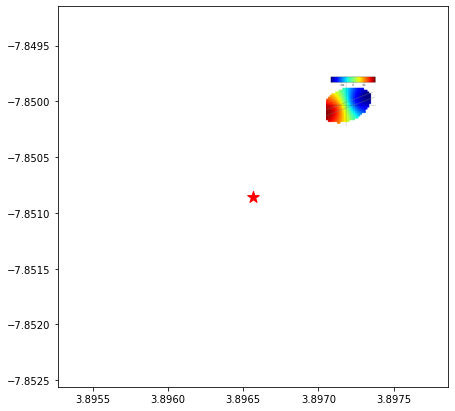

pa:  202.1502904234109  alpha :  2.364641822872187
15.884617 13.542654 15.8849235 13.5433074


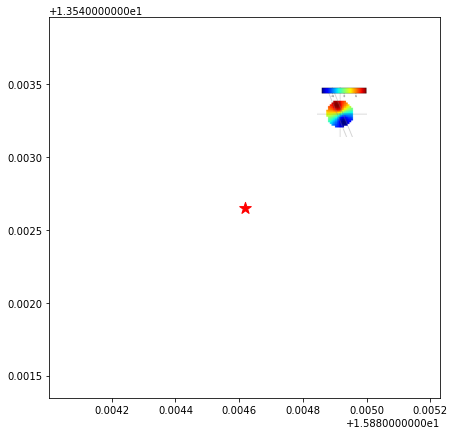

pa:  288.2719637699968  alpha :  62.11830571423221
22.901861 13.058628 22.9014124 13.061209


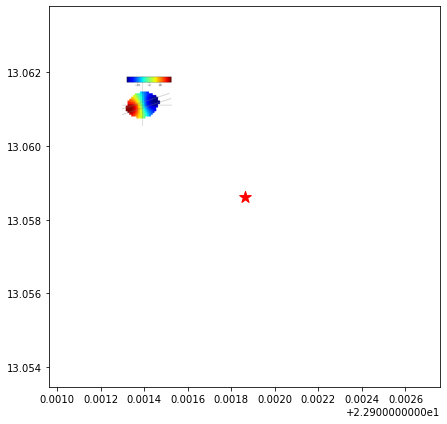

pa:  202.12420390537991  alpha :  3.1722395105149843
23.524047004166665 0.852611735 23.5232489 0.8502878


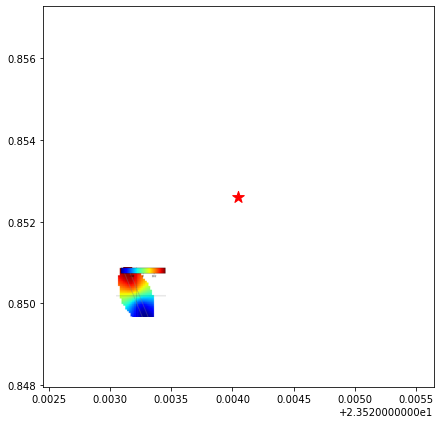

pa:  288.8645861367652  alpha :  78.71046752269069
23.524047004166665 0.852611735 23.5243502 0.8548914


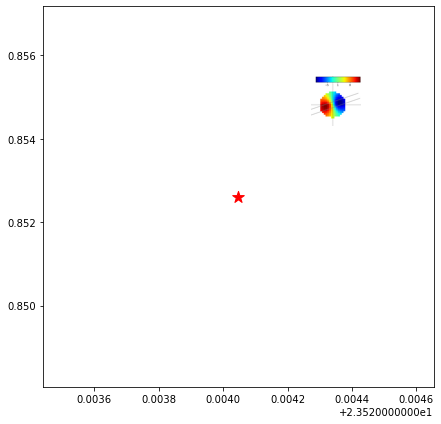

pa:  10.67418260690679  alpha :  88.54427527879662
26.304623025 10.940741853055556 26.3050614 10.940672


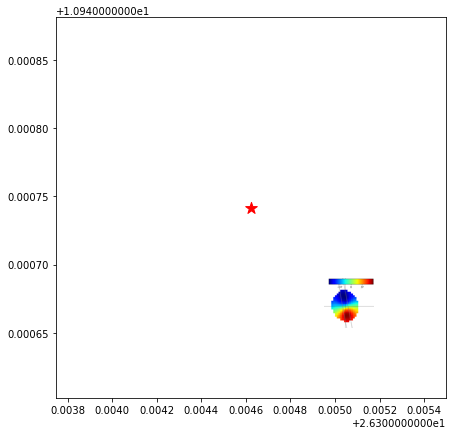

pa:  223.15455890706147  alpha :  61.840441554995664
120.01896938333331 18.826411901944443 120.0162024 18.8271134


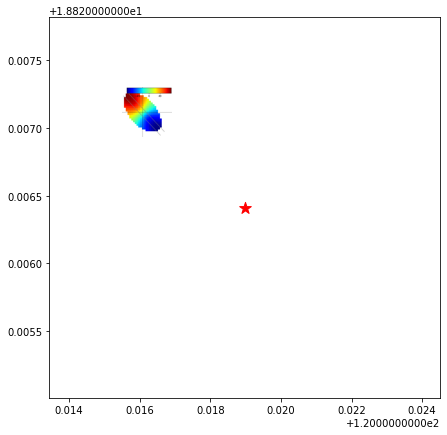

pa:  260.311333895343  alpha :  82.66601778595498
129.716895 2.951016 129.7174933 2.9490644


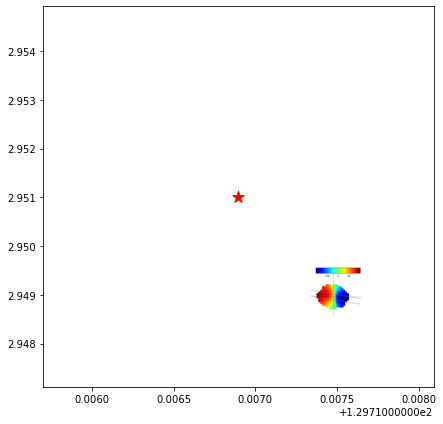

pa:  318.0811809474456  alpha :  61.55847148301351
129.716895 2.951016 129.7198903 2.9517329


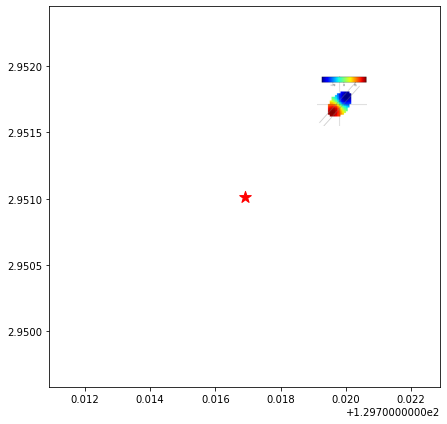

pa:  251.0595606408501  alpha :  17.0497457853471
129.716895 2.951016 129.7197524 2.9511102


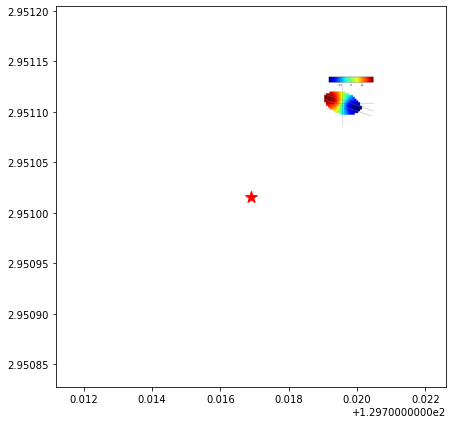

pa:  136.2824929130325  alpha :  56.02406468011657
144.45661099999998 6.948964 144.4559092 6.9488444


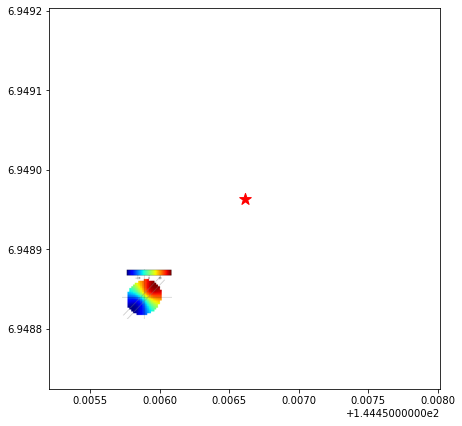

pa:  279.0202488155256  alpha :  82.44595807280439
144.45661099999998 6.948964 144.4566486 6.9504222


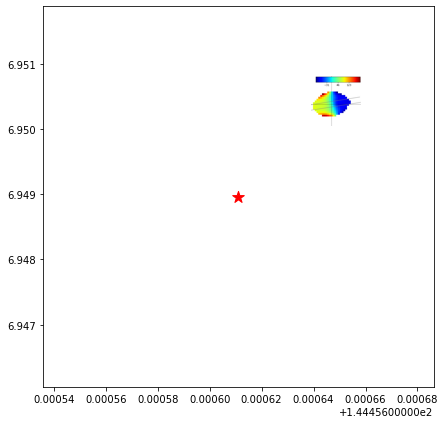

pa:  53.836740478981  alpha :  45.753635471603616
159.902785 7.240934 159.9007154 7.2412809


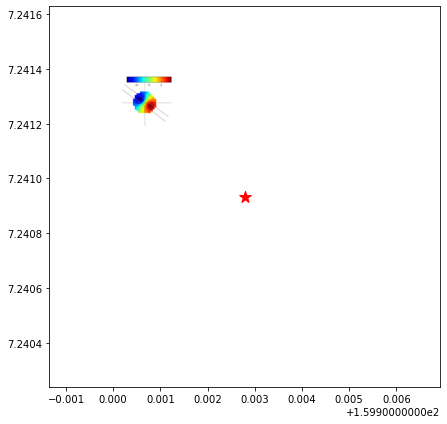

pa:  12.284543408223414  alpha :  63.390035385540216
159.902785 7.240934 159.9035011 7.2403609


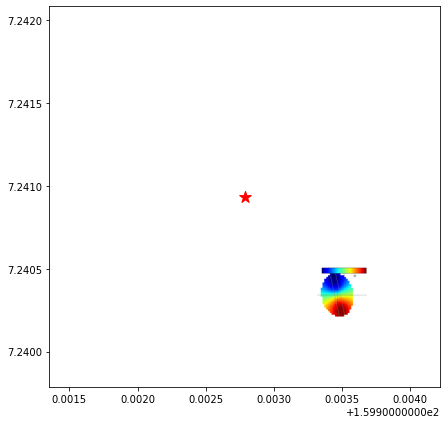

pa:  65.6010093782407  alpha :  72.77437622538275
166.9280910291667 10.357311003333333 166.9298816 10.3553288


pa:  152.403592089432  alpha :  22.920620626907063
166.9280910291667 10.357311003333333 166.9279681 10.3587895


pa:  151.0228312588192  alpha :  44.307979065428896
166.89691266666665 17.958742746666665 166.8976276 17.9612235


pa:  87.91966080409186  alpha :  21.553074386549014
189.101638 7.430986 189.1010706 7.4307398


pa:  22.142649533354533  alpha :  83.07529979377145
209.53954077916663 11.766004500277775 209.5389281 11.7663379


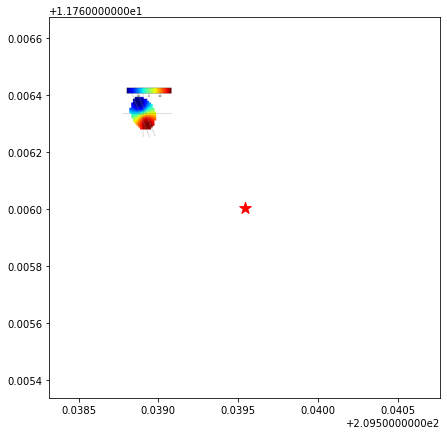

pa:  283.8864493116238  alpha :  10.546568175500283
209.53954077916663 11.766004500277775 209.5385877 11.7664284


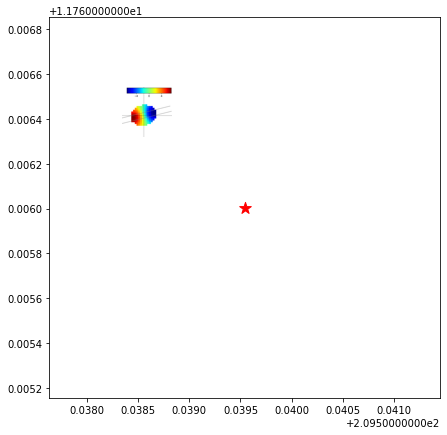

pa:  240.36652600732657  alpha :  66.20767928024259
216.408566 12.155327 216.4083337 12.1575468


pa:  140.86451789734008  alpha :  27.5707054721897
227.25050800416665 15.109663842777778 227.2504071 15.1101399


pa:  230.90919286521623  alpha :  3.818177385001349
328.0001577583333 6.421211285 328.001526 6.422173


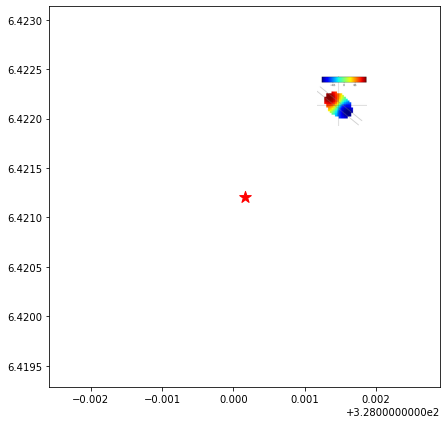

In [255]:
run_dir = "/muse/MG2QSO/private/analysis/galpak_dr2/"

for i, r in isol_good_runs_100_abs.iterrows():
    field_id = r["field_id"]
    src_id = r["ID"] 
    run_name = r["run_name"]
    z_src = r["Z"]
    REW2796 =r["REW_2796"]
    B_KPC = r["B_KPC"]
    incl = r["inclination"]
    alpha = r["alpha"]
    radius = r["radius"]
    snr_eff = r["snr_eff"]
    #score = r["galpak_score"]
    #score_auto = r["score_auto"]
    #primary = r["primary"]
    primary_auto = r["primary_auto"]
    isolated_auto = r["isolated_auto"]
    logMass = r["sed_logMass"]

    run_path = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"+str(run_name)+"/"        
    img_model = plt.imread(run_path + "run_obs_maps.png")
    img_model = img_model[50:320, 430:730]
    print("pa: ", r["pa"], " alpha : ", r["alpha"])
    
    #plt.figure(figsize = (7,7))
    fig, ax = plt.subplots(figsize = (7,7))
    img = Image.open(run_path + "run_obs_maps.png")
    img = img.crop((500, 80, 700 , 280))
    img.thumbnail((50, 50))  # Redimensionnement de l'image
    imagebox = OffsetImage(img)
    print(r["ra_qso"], r["dec_qso"],r["RA"], r["DEC"])
    ax.scatter(r["ra_qso"], r["dec_qso"], marker = "*", s = 150, color = "r", zorder = 2)
    ab = AnnotationBbox(imagebox, (r["RA"], r["DEC"]), frameon=False)
    ax.add_artist(ab)
    ax.set_xlim((r["ra_qso"]-2*np.abs(r["ra_qso"] - r["RA"]),r["ra_qso"]+2*np.abs(r["ra_qso"] - r["RA"])))
    ax.set_ylim((r["dec_qso"]-2*np.abs(r["dec_qso"] - r["DEC"]),r["dec_qso"]+2*np.abs(r["dec_qso"] - r["DEC"])))
    plt.show()

In [256]:
field_cube_path = "/muse/MG2QSO/private/production_dr2/J0800p1849/J0800p1849_dr2_zap.fits"
cube = Cube(field_cube_path)
ima_wli = cube.sum(axis=0)

In [257]:
dir = "/muse/MG2QSO/private/production_dr2/"
for i, r in isol_good_runs_100_abs.iterrows():
    field_id = r["field_id"]
    src_id = r["ID"] 
    run_name = r["run_name"]
    z_src = r["Z"]
    REW2796 =r["REW_2796"]
    B_KPC = r["B_KPC"]
    incl = r["inclination"]
    alpha = r["alpha"]
    radius = r["radius"]
    snr_eff = r["snr_eff"]
    #score = r["galpak_score"]
    #score_auto = r["score_auto"]
    #primary = r["primary"]
    primary_auto = r["primary_auto"]
    isolated_auto = r["isolated_auto"]
    logMass = r["sed_logMass"]
    
    field_cube_path = dir + field_id +"/" + field_id +"_dr2_zap.fits"
    cube = Cube(field_cube_path)
    ima_wli = cube.sum(axis=0)


    L_central_oii = 3726*(1+z_src)
    central_pix = int(np.round(cube.wave.pixel(L_central_oii)))
    min_pix = central_pix - 16
    max_pix = central_pix + 15
    # the pixel index of the left continuum
    left_min = central_pix - 150
    right_max =  central_pix + 150

    # the left, right and central cube:
    cube_left = cube[left_min: min_pix, :, :]
    cube_right = cube[max_pix: right_max, :, :]
    cube_oii = cube[min_pix: max_pix, :, :]

    # the continuum estimation:
    cont_left = cube_left.mean(axis=0)
    cont_right = cube_right.mean(axis=0)
    cont_mean = 0.5 * (cont_left + cont_right)

    # continuum substraction:
    cube_oii_nocont = cube_oii - cont_mean
    ima_oii_nocont = cube_oii_nocont.sum(axis=0)
    
    #get catalog galaxy:
    pixcoord = cube.wcs.sky2pix([r["DEC"], r["RA"]])[0]
    decpix = pixcoord[0]
    rapix = pixcoord[1]
    qso_pixcoord = cube.wcs.sky2pix([r["dec_qso"], r["ra_qso"]])[0]
    qso_decpix = qso_pixcoord[0]
    qso_rapix = qso_pixcoord[1]
    
    #plot
    label = "pa = " + str(np.round(r["pa"])) + "\n"+\
            "alpha = "+ str(np.round(r["alpha"]))
    plt.figure(figsize = (8,8))
    plt.title = str(r["alpha"])
    ima_oii_nocont.plot(scale='arcsinh', colorbar='none', vmin = 0, vmax = 1000)
    plt.scatter(rapix, decpix, marker = "o", facecolors = "none", edgecolors = "red", s = 800,\
                label = label)
    plt.scatter(qso_rapix, qso_decpix, marker = "*", c = "r")
    #plt.patches.Ellipse((rapix, decpix),10, 3)
    #matplotlib.patches.Ellipse((rapix, decpix),10, 3)
    plt.legend()
    

KeyboardInterrupt: 

/tmp/ipykernel_279039/3427706098.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (7,7))


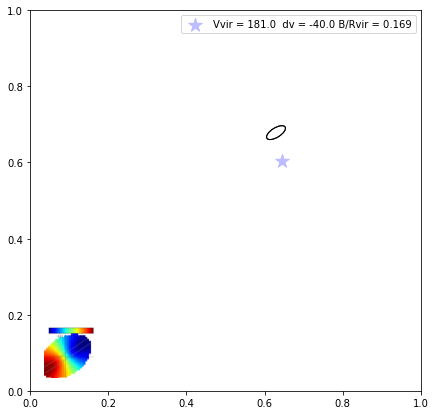

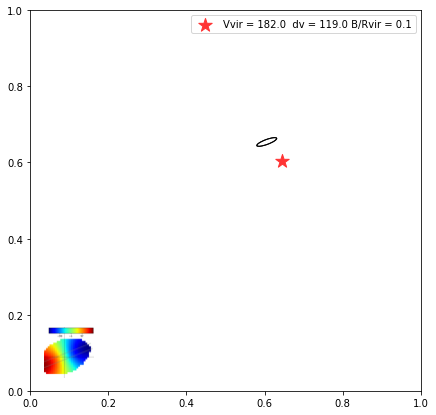

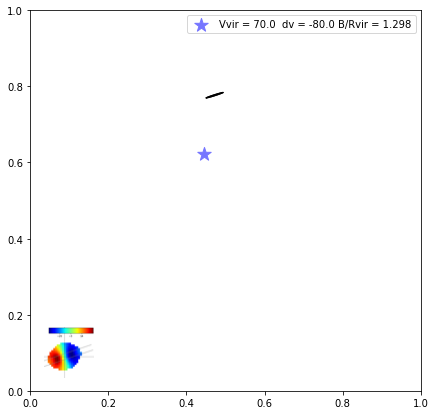

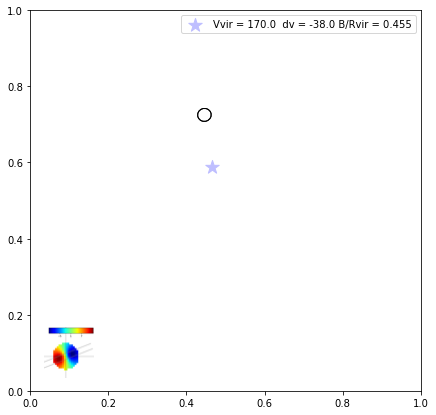

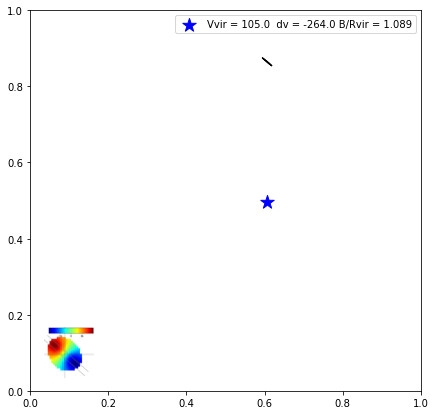

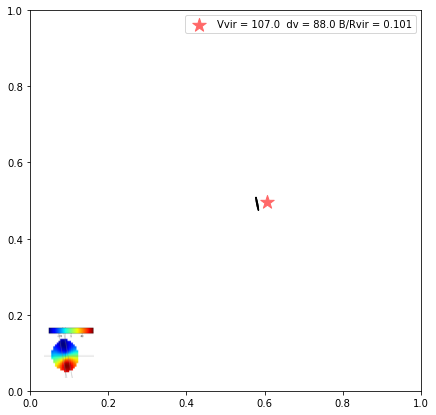

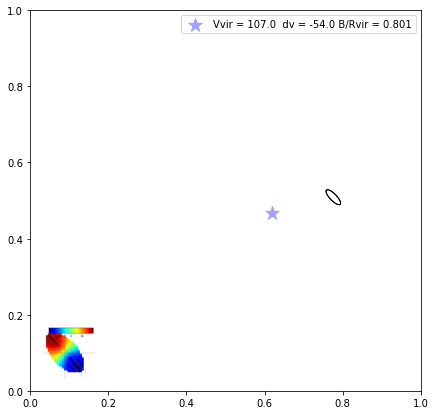

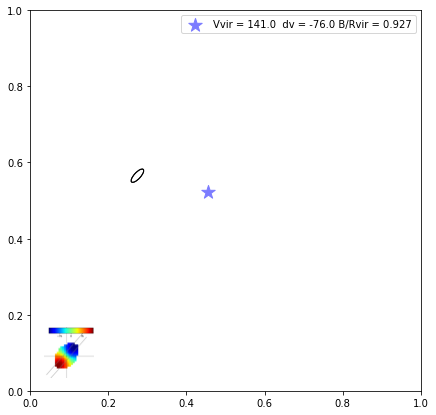

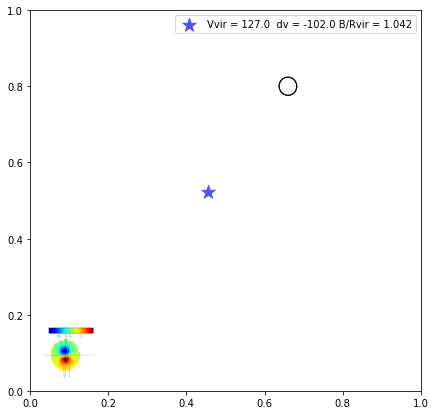

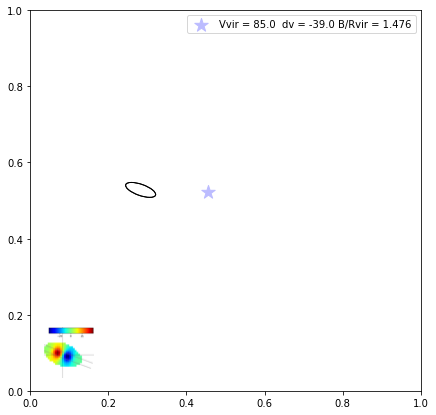

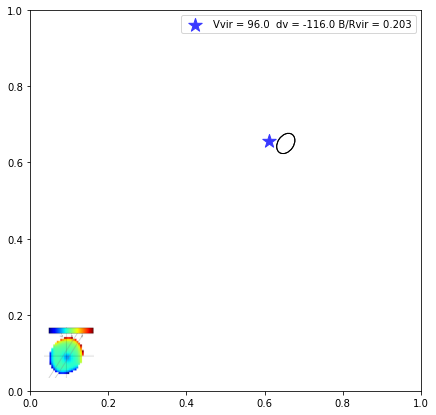

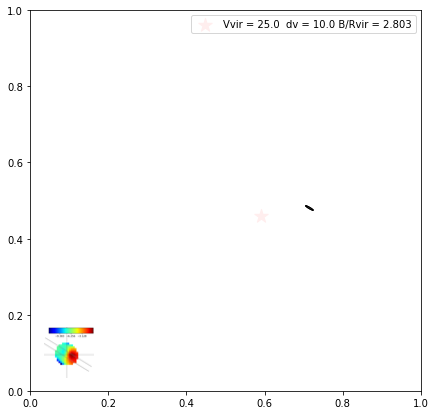

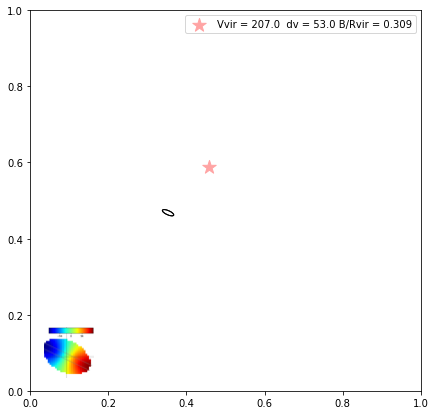

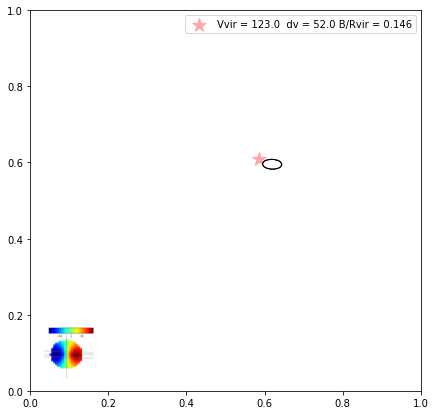

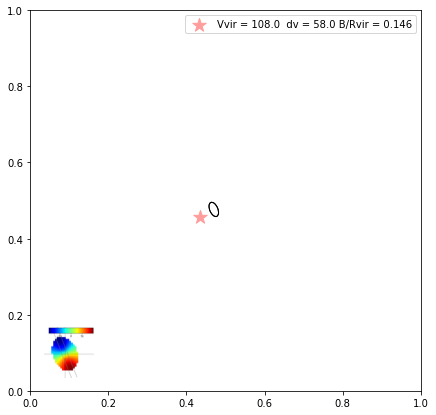

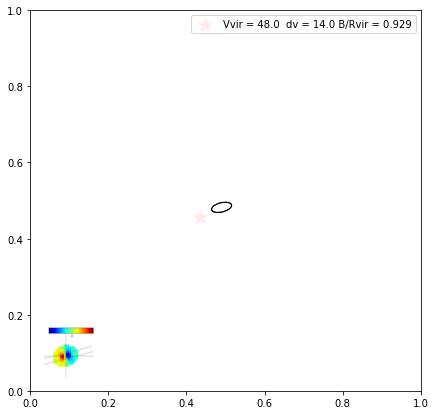

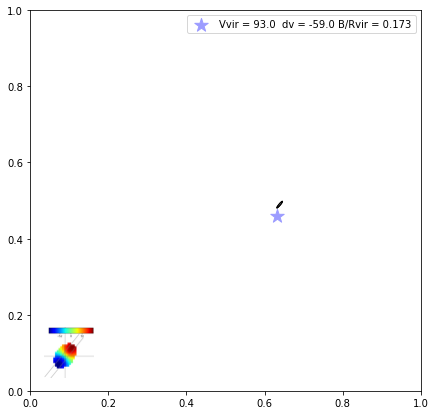

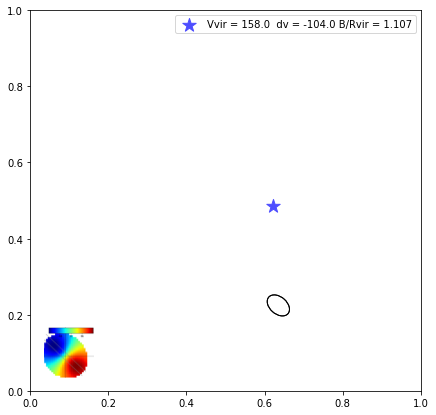

In [265]:
dir = "/muse/MG2QSO/private/production_dr2/"
for i, r in isol_good_runs_abs.iterrows():
    field_id = r["field_id"]
    src_id = r["ID"] 
    run_name = r["run_name"]
    z_src = r["Z"]
    REW2796 =r["REW_2796"]
    B_KPC = r["B_KPC"]
    incl = r["inclination"]
    alpha = r["alpha"]
    pa = r["pa"]
    radius = r["radius"]
    snr_eff = r["snr_eff"]
    #score = r["galpak_score"]
    #score_auto = r["score_auto"]
    #primary = r["primary"]
    primary_auto = r["primary_auto"]
    isolated_auto = r["isolated_auto"]
    mass = r["sed_logMass"]
    logSFR = np.log10(r["SFR_gilbank"])
    z = r["Z"]
    
    
    ymin = 0
    ymax = 300
    xmin = 0
    xmax = 300
    massmin = 9
    massmax = 12
    ss_min = 0.02
    ss_max = 0.1
    vmin = -0.5
    vmax = 1.2
    
    field_cube_path = dir + field_id +"/" + field_id +"_dr2_zap.fits"
    cube = Cube(field_cube_path)
    #ima_wli = cube.sum(axis=0)
    
    pixcoord = cube.wcs.sky2pix([r["DEC"], r["RA"]])[0]
    decpix = pixcoord[0]
    rapix = pixcoord[1]
    qso_pixcoord = cube.wcs.sky2pix([r["dec_qso"], r["ra_qso"]])[0]
    qso_decpix = qso_pixcoord[0]
    qso_rapix = qso_pixcoord[1]
    
    xx = (rapix - xmin)/(xmax - xmin)
    yy = (decpix - ymin)/(ymax - ymin)
    qso_xx = (qso_rapix - xmin)/(xmax - xmin)
    qso_yy = (qso_decpix - ymin)/(ymax - ymin)
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    #w = 20
    #h = 10
    
    #plt.figure(figsize = (7,7))

    
    fig, ax = plt.subplots(figsize = (7,7))
    #print(r["Z"], r["z_absorption"])
    dv = const.c.value*(r["z_absorption"] - r["Z"])/(1+r["Z"])/1e3
    Brvir = np.round(r["B_KPC"]/r["Rvir"], 3)
    label = "Vvir = " + str(np.round(r["virial_velocity"])) + "  dv = "+ str(np.round(dv))+ " B/Rvir = "+str(Brvir)
    ax.scatter(qso_xx, qso_yy, marker = "*", c = dv, cmap = "bwr", vmin = -150, vmax = 150, s = 200, label = label)
    
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=pa+90,fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
        #plt.scatter(xx, yy)
    else:
        ax.scatter(xx, yy)
    
    run_dir = "/muse/MG2QSO/private/analysis/galpak_dr2/"
    run_path = run_dir + field_id +"/"+field_id +"_source-"+str(src_id)+"/"+str(run_name)+"/"
    img = Image.open(run_path + "run_obs_maps.png")
    img = img.crop((500, 80, 700 , 280))
    img.thumbnail((50, 50))  # Redimensionnement de l'image
    imagebox = OffsetImage(img)
    
    ab = AnnotationBbox(imagebox, (0.1, 0.1), frameon=False)
    ax.add_artist(ab)
    label = "pa = " + str(np.round(r["pa"])) + "\n"+\
            "alpha = "+ str(np.round(r["alpha"]))
    
    #plt.patches.Ellipse((rapix, decpix),10, 3)
    #matplotlib.patches.Ellipse((rapix, decpix),10, 3)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.legend()
    